In [1]:
# For using package modified in local repo 
using Pkg

push!(LOAD_PATH, "C://Users//jerem//OneDrive//Desktop//GitHub//Code//FinalCode")

4-element Array{String,1}:
 "@"
 "@v#.#"
 "@stdlib"
 "C://Users//jerem//OneDrive//Desktop//GitHub//Code//FinalCode"

In [2]:
using ForwardDiff, Plots, Statistics, LinearAlgebra, OnlineStats, Distributions, Random, CUDA, CSV, DataFrames

using Sofia, Geraldine

# Backend
plotly()

┌ Info: Precompiling Geraldine [c0fffcf4-b2fb-46e8-8a34-03ca56aefa66]
└ @ Base loading.jl:1278
  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken fo

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** i

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

┌ Warning: Package Geraldine does not have Pkg in its dependencies:
│ - If you have Geraldine checked out for development and have
│   added Pkg as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with Geraldine
└ Loading Pkg into Geraldine from project dependency

Plots.PlotlyBackend()

In [87]:
include("Rosenbrock_Generalized_Stochastic_2.jl")

Hessian_vector_product_RGS (generic function with 2 methods)

In [88]:
struct Model_RSG{U <: IsUpdatable, T} <: Sofia.AbstractStochasticModel{U}
    samples::Matrix{T}
    
    function Model_RSG(samples::Matrix{T}, upd::Bool = false) where T
        UPD = upd ? Updatable : NotUpdatable
        return new{UPD, T}(samples)
    end
end

In [97]:
dim = 2
nb_pop = 100_000

sigma = 0.001
samples = rand(Normal(1.0, sigma), dim-1, nb_pop)

mo_RSG = Model_RSG(Matrix(samples))

Model_RSG{NotUpdatable,Float64}([1.001397869930049 1.0012308019317753 … 0.9996786767224134 0.9999511887219563])

In [98]:
beta = rand(dim);
N = 100;

In [99]:
function Sofia.Nobs(mo::Model_RSG)
   return size(mo.samples, 2) 
end

Sofia.Nobs(mo_RSG)

100000

In [100]:
function Sofia.F(x::Array{T,1}, mo::Model_RSG; sample=1:Sofia.Nobs(mo)) where T
    return Rosenbrock_Generalized_Stochastic_2(x, mo.samples[:, sample])
end

F(beta, mo_RSG)

26.657503343418547

In [101]:
function Sofia.Fs(x::Array{T,1}, mo::Model_RSG; sample=1:Sofia.Nobs(mo)) where T
    return Rosenbrock_Generalized_Stochastic_2_inds(x, mo.samples[:, sample])
end

@show mean(Sofia.Fs(beta, mo_RSG)) - F(beta, mo_RSG)

Sofia.Fs(beta, mo_RSG; sample = 1:2)

mean(Sofia.Fs(beta, mo_RSG)) - F(beta, mo_RSG) = -3.659295089164516e-13


2-element Array{Float64,1}:
 26.85750443375039
 26.833565966174383

In [102]:
# ------------------- gradient -----------------------
function Sofia.grad!(x::Vector, mo::Model_RSG, stack::Vector ; sample=1:Nobs(mo))
    stack[:] = Rosenbrock_Generalized_Stochastic_Grad_2(x, mo.samples[:, sample])[:]
end

function Sofia.grad(x::Vector, mo::Model_RSG ; sample=1:Nobs(mo))
    return Rosenbrock_Generalized_Stochastic_Grad_2(x, mo.samples[:, sample])
end

function Sofia.grads(x::Vector, mo::Model_RSG ; sample=1:Nobs(mo))
    return Rosenbrock_Generalized_Stochastic_Grad_2_inds(x, mo.samples[:, sample])
end

function Sofia.grads!(x::Vector, mo::Model_RSG, stack::Array{Vector, 1}; sample=1:Nobs(mo))
    result = Rosenbrock_Generalized_Stochastic_Grad_2_inds(x, mo.samples[:, sample])
    for i in 1:length(sample)
        stack[i] = result[:, i]
    end
end

In [103]:
Ftemp = t -> Sofia.F(t, mo_RSG ; sample=1:N)

Ftemp(rand(dim))

9.751486227262284

In [104]:
stack = Array{Float64, 1}(undef, dim)
Sofia.grad!(beta, mo_RSG, stack; sample=1:N)

# vector stack
show(stdout, "text/plain", stack)

# diff with forward diff
ForwardDiff.gradient(t -> Sofia.F(t, mo_RSG ; sample=1:N), beta) - Sofia.grad(beta, mo_RSG; sample=1:N)

2-element Array{Float64,1}:
  171.39006112131574
 -103.20631040053378

2-element Array{Float64,1}:
 0.0
 0.0

In [105]:
# diff with forward diff
ForwardDiff.gradient(t -> Sofia.F(t, mo_RSG ; sample=1:N), beta) - Sofia.grad(beta, mo_RSG;sample=1:N)

2-element Array{Float64,1}:
 0.0
 0.0

In [106]:
# ----------------- Hessian ---------------------------

function Sofia.H!(x::Vector, mo::Model_RSG, stack::Matrix; sample=1:Nobs(mo))
    stack[:,:] = Rosenbrock_Generalized_Stochastic_Hessian_2(x, mo.samples[:, sample])[:,:]
end

function Sofia.Hdotv(x::Vector, mo::Model_RSG, v::Vector; sample=1:Nobs(mo))
    return Hessian_vector_product_RGS(x, mo.samples[:, sample], v)
end

function Sofia.Hdotv!(x::Vector, mo::Model_RSG, v::Vector, stack::Vector; sample=1:Nobs(mo))
    stack[:] = Hdotv(x, mo, v; sample = sample)
end

In [107]:
v = rand(dim)

Hdotv(beta, mo_RSG, v; sample=1:N) - ForwardDiff.hessian(t -> Sofia.F(t, mo_RSG; sample=1:N), beta)*v

2-element Array{Float64,1}:
 0.0
 0.0

# Minimization 

In [127]:
################################################################################
#                   Tests minimization

# parameter dimension
dim = 2

# initilization vector
x0 = rand(Normal(20, 1), dim)

# population size
nb_pop = 100_000

# sample for model
m = 1.0
σ = 0.5
samples = rand(Normal(m, σ), dim-1, nb_pop) 

# Creation model
mo_RSG = Model_RSG(samples)

eps = 1e-8

1.0e-8

Algorithm of type : SGDConstStep{Float64}
Nmax reached ? 
k = 0  and  max = 10000
Nmax reached ? 
k = 1  and  max = 10000
Nmax reached ? 
k = 2  and  max = 10000
Nmax reached ? 
k = 3  and  max = 10000
Nmax reached ? 
k = 4  and  max = 10000
Nmax reached ? 
k = 5  and  max = 10000
Nmax reached ? 
k = 6  and  max = 10000
Nmax reached ? 
k = 7  and  max = 10000
Nmax reached ? 
k = 8  and  max = 10000
Nmax reached ? 
k = 9  and  max = 10000
Nmax reached ? 
k = 10  and  max = 10000
Nmax reached ? 
k = 11  and  max = 10000
Nmax reached ? 
k = 12  and  max = 10000
Nmax reached ? 
k = 13  and  max = 10000
Nmax reached ? 
k = 14  and  max = 10000
Nmax reached ? 
k = 15  and  max = 10000
Nmax reached ? 
k = 16  and  max = 10000
Nmax reached ? 
k = 17  and  max = 10000
Nmax reached ? 
k = 18  and  max = 10000
Nmax reached ? 
k = 19  and  max = 10000
Nmax reached ? 
k = 20  and  max = 10000
Nmax reached ? 
k = 21  and  max = 10000
Nmax reached ? 
k = 22  and  max = 10000
Nmax reached ? 
k = 23  a

k = 200  and  max = 10000
Nmax reached ? 
k = 201  and  max = 10000
Nmax reached ? 
k = 202  and  max = 10000
Nmax reached ? 
k = 203  and  max = 10000
Nmax reached ? 
k = 204  and  max = 10000
Nmax reached ? 
k = 205  and  max = 10000
Nmax reached ? 
k = 206  and  max = 10000
Nmax reached ? 
k = 207  and  max = 10000
Nmax reached ? 
k = 208  and  max = 10000
Nmax reached ? 
k = 209  and  max = 10000
Nmax reached ? 
k = 210  and  max = 10000
Nmax reached ? 
k = 211  and  max = 10000
Nmax reached ? 
k = 212  and  max = 10000
Nmax reached ? 
k = 213  and  max = 10000
Nmax reached ? 
k = 214  and  max = 10000
Nmax reached ? 
k = 215  and  max = 10000
Nmax reached ? 
k = 216  and  max = 10000
Nmax reached ? 
k = 217  and  max = 10000
Nmax reached ? 
k = 218  and  max = 10000
Nmax reached ? 
k = 219  and  max = 10000
Nmax reached ? 
k = 220  and  max = 10000
Nmax reached ? 
k = 221  and  max = 10000
Nmax reached ? 
k = 222  and  max = 10000
Nmax reached ? 
k = 223  and  max = 10000
Nmax rea

Nmax reached ? 
k = 403  and  max = 10000
Nmax reached ? 
k = 404  and  max = 10000
Nmax reached ? 
k = 405  and  max = 10000
Nmax reached ? 
k = 406  and  max = 10000
Nmax reached ? 
k = 407  and  max = 10000
Nmax reached ? 
k = 408  and  max = 10000
Nmax reached ? 
k = 409  and  max = 10000
Nmax reached ? 
k = 410  and  max = 10000
Nmax reached ? 
k = 411  and  max = 10000
Nmax reached ? 
k = 412  and  max = 10000
Nmax reached ? 
k = 413  and  max = 10000
Nmax reached ? 
k = 414  and  max = 10000
Nmax reached ? 
k = 415  and  max = 10000
Nmax reached ? 
k = 416  and  max = 10000
Nmax reached ? 
k = 417  and  max = 10000
Nmax reached ? 
k = 418  and  max = 10000
Nmax reached ? 
k = 419  and  max = 10000
Nmax reached ? 
k = 420  and  max = 10000
Nmax reached ? 
k = 421  and  max = 10000
Nmax reached ? 
k = 422  and  max = 10000
Nmax reached ? 
k = 423  and  max = 10000
Nmax reached ? 
k = 424  and  max = 10000
Nmax reached ? 
k = 425  and  max = 10000
Nmax reached ? 
k = 426  and  max 

Nmax reached ? 
k = 609  and  max = 10000
Nmax reached ? 
k = 610  and  max = 10000
Nmax reached ? 
k = 611  and  max = 10000
Nmax reached ? 
k = 612  and  max = 10000
Nmax reached ? 
k = 613  and  max = 10000
Nmax reached ? 
k = 614  and  max = 10000
Nmax reached ? 
k = 615  and  max = 10000
Nmax reached ? 
k = 616  and  max = 10000
Nmax reached ? 
k = 617  and  max = 10000
Nmax reached ? 
k = 618  and  max = 10000
Nmax reached ? 
k = 619  and  max = 10000
Nmax reached ? 
k = 620  and  max = 10000
Nmax reached ? 
k = 621  and  max = 10000
Nmax reached ? 
k = 622  and  max = 10000
Nmax reached ? 
k = 623  and  max = 10000
Nmax reached ? 
k = 624  and  max = 10000
Nmax reached ? 
k = 625  and  max = 10000
Nmax reached ? 
k = 626  and  max = 10000
Nmax reached ? 
k = 627  and  max = 10000
Nmax reached ? 
k = 628  and  max = 10000
Nmax reached ? 
k = 629  and  max = 10000
Nmax reached ? 
k = 630  and  max = 10000
Nmax reached ? 
k = 631  and  max = 10000
Nmax reached ? 
k = 632  and  max 

k = 849  and  max = 10000
Nmax reached ? 
k = 850  and  max = 10000
Nmax reached ? 
k = 851  and  max = 10000
Nmax reached ? 
k = 852  and  max = 10000
Nmax reached ? 
k = 853  and  max = 10000
Nmax reached ? 
k = 854  and  max = 10000
Nmax reached ? 
k = 855  and  max = 10000
Nmax reached ? 
k = 856  and  max = 10000
Nmax reached ? 
k = 857  and  max = 10000
Nmax reached ? 
k = 858  and  max = 10000
Nmax reached ? 
k = 859  and  max = 10000
Nmax reached ? 
k = 860  and  max = 10000
Nmax reached ? 
k = 861  and  max = 10000
Nmax reached ? 
k = 862  and  max = 10000
Nmax reached ? 
k = 863  and  max = 10000
Nmax reached ? 
k = 864  and  max = 10000
Nmax reached ? 
k = 865  and  max = 10000
Nmax reached ? 
k = 866  and  max = 10000
Nmax reached ? 
k = 867  and  max = 10000
Nmax reached ? 
k = 868  and  max = 10000
Nmax reached ? 
k = 869  and  max = 10000
Nmax reached ? 
k = 870  and  max = 10000
Nmax reached ? 
k = 871  and  max = 10000
Nmax reached ? 
k = 872  and  max = 10000
Nmax rea

Nmax reached ? 
k = 1070  and  max = 10000
Nmax reached ? 
k = 1071  and  max = 10000
Nmax reached ? 
k = 1072  and  max = 10000
Nmax reached ? 
k = 1073  and  max = 10000
Nmax reached ? 
k = 1074  and  max = 10000
Nmax reached ? 
k = 1075  and  max = 10000
Nmax reached ? 
k = 1076  and  max = 10000
Nmax reached ? 
k = 1077  and  max = 10000
Nmax reached ? 
k = 1078  and  max = 10000
Nmax reached ? 
k = 1079  and  max = 10000
Nmax reached ? 
k = 1080  and  max = 10000
Nmax reached ? 
k = 1081  and  max = 10000
Nmax reached ? 
k = 1082  and  max = 10000
Nmax reached ? 
k = 1083  and  max = 10000
Nmax reached ? 
k = 1084  and  max = 10000
Nmax reached ? 
k = 1085  and  max = 10000
Nmax reached ? 
k = 1086  and  max = 10000
Nmax reached ? 
k = 1087  and  max = 10000
Nmax reached ? 
k = 1088  and  max = 10000
Nmax reached ? 
k = 1089  and  max = 10000
Nmax reached ? 
k = 1090  and  max = 10000
Nmax reached ? 
k = 1091  and  max = 10000
Nmax reached ? 
k = 1092  and  max = 10000
Nmax reache

k = 1328  and  max = 10000
Nmax reached ? 
k = 1329  and  max = 10000
Nmax reached ? 
k = 1330  and  max = 10000
Nmax reached ? 
k = 1331  and  max = 10000
Nmax reached ? 
k = 1332  and  max = 10000
Nmax reached ? 
k = 1333  and  max = 10000
Nmax reached ? 
k = 1334  and  max = 10000
Nmax reached ? 
k = 1335  and  max = 10000
Nmax reached ? 
k = 1336  and  max = 10000
Nmax reached ? 
k = 1337  and  max = 10000
Nmax reached ? 
k = 1338  and  max = 10000
Nmax reached ? 
k = 1339  and  max = 10000
Nmax reached ? 
k = 1340  and  max = 10000
Nmax reached ? 
k = 1341  and  max = 10000
Nmax reached ? 
k = 1342  and  max = 10000
Nmax reached ? 
k = 1343  and  max = 10000
Nmax reached ? 
k = 1344  and  max = 10000
Nmax reached ? 
k = 1345  and  max = 10000
Nmax reached ? 
k = 1346  and  max = 10000
Nmax reached ? 
k = 1347  and  max = 10000
Nmax reached ? 
k = 1348  and  max = 10000
Nmax reached ? 
k = 1349  and  max = 10000
Nmax reached ? 
k = 1350  and  max = 10000
Nmax reached ? 
k = 1351  a

k = 1523  and  max = 10000
Nmax reached ? 
k = 1524  and  max = 10000
Nmax reached ? 
k = 1525  and  max = 10000
Nmax reached ? 
k = 1526  and  max = 10000
Nmax reached ? 
k = 1527  and  max = 10000
Nmax reached ? 
k = 1528  and  max = 10000
Nmax reached ? 
k = 1529  and  max = 10000
Nmax reached ? 
k = 1530  and  max = 10000
Nmax reached ? 
k = 1531  and  max = 10000
Nmax reached ? 
k = 1532  and  max = 10000
Nmax reached ? 
k = 1533  and  max = 10000
Nmax reached ? 
k = 1534  and  max = 10000
Nmax reached ? 
k = 1535  and  max = 10000
Nmax reached ? 
k = 1536  and  max = 10000
Nmax reached ? 
k = 1537  and  max = 10000
Nmax reached ? 
k = 1538  and  max = 10000
Nmax reached ? 
k = 1539  and  max = 10000
Nmax reached ? 
k = 1540  and  max = 10000
Nmax reached ? 
k = 1541  and  max = 10000
Nmax reached ? 
k = 1542  and  max = 10000
Nmax reached ? 
k = 1543  and  max = 10000
Nmax reached ? 
k = 1544  and  max = 10000
Nmax reached ? 
k = 1545  and  max = 10000
Nmax reached ? 
k = 1546  a

k = 1756  and  max = 10000
Nmax reached ? 
k = 1757  and  max = 10000
Nmax reached ? 
k = 1758  and  max = 10000
Nmax reached ? 
k = 1759  and  max = 10000
Nmax reached ? 
k = 1760  and  max = 10000
Nmax reached ? 
k = 1761  and  max = 10000
Nmax reached ? 
k = 1762  and  max = 10000
Nmax reached ? 
k = 1763  and  max = 10000
Nmax reached ? 
k = 1764  and  max = 10000
Nmax reached ? 
k = 1765  and  max = 10000
Nmax reached ? 
k = 1766  and  max = 10000
Nmax reached ? 
k = 1767  and  max = 10000
Nmax reached ? 
k = 1768  and  max = 10000
Nmax reached ? 
k = 1769  and  max = 10000
Nmax reached ? 
k = 1770  and  max = 10000
Nmax reached ? 
k = 1771  and  max = 10000
Nmax reached ? 
k = 1772  and  max = 10000
Nmax reached ? 
k = 1773  and  max = 10000
Nmax reached ? 
k = 1774  and  max = 10000
Nmax reached ? 
k = 1775  and  max = 10000
Nmax reached ? 
k = 1776  and  max = 10000
Nmax reached ? 
k = 1777  and  max = 10000
Nmax reached ? 
k = 1778  and  max = 10000
Nmax reached ? 
k = 1779  a

k = 1955  and  max = 10000
Nmax reached ? 
k = 1956  and  max = 10000
Nmax reached ? 
k = 1957  and  max = 10000
Nmax reached ? 
k = 1958  and  max = 10000
Nmax reached ? 
k = 1959  and  max = 10000
Nmax reached ? 
k = 1960  and  max = 10000
Nmax reached ? 
k = 1961  and  max = 10000
Nmax reached ? 
k = 1962  and  max = 10000
Nmax reached ? 
k = 1963  and  max = 10000
Nmax reached ? 
k = 1964  and  max = 10000
Nmax reached ? 
k = 1965  and  max = 10000
Nmax reached ? 
k = 1966  and  max = 10000
Nmax reached ? 
k = 1967  and  max = 10000
Nmax reached ? 
k = 1968  and  max = 10000
Nmax reached ? 
k = 1969  and  max = 10000
Nmax reached ? 
k = 1970  and  max = 10000
Nmax reached ? 
k = 1971  and  max = 10000
Nmax reached ? 
k = 1972  and  max = 10000
Nmax reached ? 
k = 1973  and  max = 10000
Nmax reached ? 
k = 1974  and  max = 10000
Nmax reached ? 
k = 1975  and  max = 10000
Nmax reached ? 
k = 1976  and  max = 10000
Nmax reached ? 
k = 1977  and  max = 10000
Nmax reached ? 
k = 1978  a

Nmax reached ? 
k = 2161  and  max = 10000
Nmax reached ? 
k = 2162  and  max = 10000
Nmax reached ? 
k = 2163  and  max = 10000
Nmax reached ? 
k = 2164  and  max = 10000
Nmax reached ? 
k = 2165  and  max = 10000
Nmax reached ? 
k = 2166  and  max = 10000
Nmax reached ? 
k = 2167  and  max = 10000
Nmax reached ? 
k = 2168  and  max = 10000
Nmax reached ? 
k = 2169  and  max = 10000
Nmax reached ? 
k = 2170  and  max = 10000
Nmax reached ? 
k = 2171  and  max = 10000
Nmax reached ? 
k = 2172  and  max = 10000
Nmax reached ? 
k = 2173  and  max = 10000
Nmax reached ? 
k = 2174  and  max = 10000
Nmax reached ? 
k = 2175  and  max = 10000
Nmax reached ? 
k = 2176  and  max = 10000
Nmax reached ? 
k = 2177  and  max = 10000
Nmax reached ? 
k = 2178  and  max = 10000
Nmax reached ? 
k = 2179  and  max = 10000
Nmax reached ? 
k = 2180  and  max = 10000
Nmax reached ? 
k = 2181  and  max = 10000
Nmax reached ? 
k = 2182  and  max = 10000
Nmax reached ? 
k = 2183  and  max = 10000
Nmax reache

Nmax reached ? 
k = 2362  and  max = 10000
Nmax reached ? 
k = 2363  and  max = 10000
Nmax reached ? 
k = 2364  and  max = 10000
Nmax reached ? 
k = 2365  and  max = 10000
Nmax reached ? 
k = 2366  and  max = 10000
Nmax reached ? 
k = 2367  and  max = 10000
Nmax reached ? 
k = 2368  and  max = 10000
Nmax reached ? 
k = 2369  and  max = 10000
Nmax reached ? 
k = 2370  and  max = 10000
Nmax reached ? 
k = 2371  and  max = 10000
Nmax reached ? 
k = 2372  and  max = 10000
Nmax reached ? 
k = 2373  and  max = 10000
Nmax reached ? 
k = 2374  and  max = 10000
Nmax reached ? 
k = 2375  and  max = 10000
Nmax reached ? 
k = 2376  and  max = 10000
Nmax reached ? 
k = 2377  and  max = 10000
Nmax reached ? 
k = 2378  and  max = 10000
Nmax reached ? 
k = 2379  and  max = 10000
Nmax reached ? 
k = 2380  and  max = 10000
Nmax reached ? 
k = 2381  and  max = 10000
Nmax reached ? 
k = 2382  and  max = 10000
Nmax reached ? 
k = 2383  and  max = 10000
Nmax reached ? 
k = 2384  and  max = 10000
Nmax reache

Nmax reached ? 
k = 2554  and  max = 10000
Nmax reached ? 
k = 2555  and  max = 10000
Nmax reached ? 
k = 2556  and  max = 10000
Nmax reached ? 
k = 2557  and  max = 10000
Nmax reached ? 
k = 2558  and  max = 10000
Nmax reached ? 
k = 2559  and  max = 10000
Nmax reached ? 
k = 2560  and  max = 10000
Nmax reached ? 
k = 2561  and  max = 10000
Nmax reached ? 
k = 2562  and  max = 10000
Nmax reached ? 
k = 2563  and  max = 10000
Nmax reached ? 
k = 2564  and  max = 10000
Nmax reached ? 
k = 2565  and  max = 10000
Nmax reached ? 
k = 2566  and  max = 10000
Nmax reached ? 
k = 2567  and  max = 10000
Nmax reached ? 
k = 2568  and  max = 10000
Nmax reached ? 
k = 2569  and  max = 10000
Nmax reached ? 
k = 2570  and  max = 10000
Nmax reached ? 
k = 2571  and  max = 10000
Nmax reached ? 
k = 2572  and  max = 10000
Nmax reached ? 
k = 2573  and  max = 10000
Nmax reached ? 
k = 2574  and  max = 10000
Nmax reached ? 
k = 2575  and  max = 10000
Nmax reached ? 
k = 2576  and  max = 10000
Nmax reache

Nmax reached ? 
k = 2749  and  max = 10000
Nmax reached ? 
k = 2750  and  max = 10000
Nmax reached ? 
k = 2751  and  max = 10000
Nmax reached ? 
k = 2752  and  max = 10000
Nmax reached ? 
k = 2753  and  max = 10000
Nmax reached ? 
k = 2754  and  max = 10000
Nmax reached ? 
k = 2755  and  max = 10000
Nmax reached ? 
k = 2756  and  max = 10000
Nmax reached ? 
k = 2757  and  max = 10000
Nmax reached ? 
k = 2758  and  max = 10000
Nmax reached ? 
k = 2759  and  max = 10000
Nmax reached ? 
k = 2760  and  max = 10000
Nmax reached ? 
k = 2761  and  max = 10000
Nmax reached ? 
k = 2762  and  max = 10000
Nmax reached ? 
k = 2763  and  max = 10000
Nmax reached ? 
k = 2764  and  max = 10000
Nmax reached ? 
k = 2765  and  max = 10000
Nmax reached ? 
k = 2766  and  max = 10000
Nmax reached ? 
k = 2767  and  max = 10000
Nmax reached ? 
k = 2768  and  max = 10000
Nmax reached ? 
k = 2769  and  max = 10000
Nmax reached ? 
k = 2770  and  max = 10000
Nmax reached ? 
k = 2771  and  max = 10000
Nmax reache

Nmax reached ? 
k = 2959  and  max = 10000
Nmax reached ? 
k = 2960  and  max = 10000
Nmax reached ? 
k = 2961  and  max = 10000
Nmax reached ? 
k = 2962  and  max = 10000
Nmax reached ? 
k = 2963  and  max = 10000
Nmax reached ? 
k = 2964  and  max = 10000
Nmax reached ? 
k = 2965  and  max = 10000
Nmax reached ? 
k = 2966  and  max = 10000
Nmax reached ? 
k = 2967  and  max = 10000
Nmax reached ? 
k = 2968  and  max = 10000
Nmax reached ? 
k = 2969  and  max = 10000
Nmax reached ? 
k = 2970  and  max = 10000
Nmax reached ? 
k = 2971  and  max = 10000
Nmax reached ? 
k = 2972  and  max = 10000
Nmax reached ? 
k = 2973  and  max = 10000
Nmax reached ? 
k = 2974  and  max = 10000
Nmax reached ? 
k = 2975  and  max = 10000
Nmax reached ? 
k = 2976  and  max = 10000
Nmax reached ? 
k = 2977  and  max = 10000
Nmax reached ? 
k = 2978  and  max = 10000
Nmax reached ? 
k = 2979  and  max = 10000
Nmax reached ? 
k = 2980  and  max = 10000
Nmax reached ? 
k = 2981  and  max = 10000
Nmax reache

k = 3151  and  max = 10000
Nmax reached ? 
k = 3152  and  max = 10000
Nmax reached ? 
k = 3153  and  max = 10000
Nmax reached ? 
k = 3154  and  max = 10000
Nmax reached ? 
k = 3155  and  max = 10000
Nmax reached ? 
k = 3156  and  max = 10000
Nmax reached ? 
k = 3157  and  max = 10000
Nmax reached ? 
k = 3158  and  max = 10000
Nmax reached ? 
k = 3159  and  max = 10000
Nmax reached ? 
k = 3160  and  max = 10000
Nmax reached ? 
k = 3161  and  max = 10000
Nmax reached ? 
k = 3162  and  max = 10000
Nmax reached ? 
k = 3163  and  max = 10000
Nmax reached ? 
k = 3164  and  max = 10000
Nmax reached ? 
k = 3165  and  max = 10000
Nmax reached ? 
k = 3166  and  max = 10000
Nmax reached ? 
k = 3167  and  max = 10000
Nmax reached ? 
k = 3168  and  max = 10000
Nmax reached ? 
k = 3169  and  max = 10000
Nmax reached ? 
k = 3170  and  max = 10000
Nmax reached ? 
k = 3171  and  max = 10000
Nmax reached ? 
k = 3172  and  max = 10000
Nmax reached ? 
k = 3173  and  max = 10000
Nmax reached ? 
k = 3174  a

k = 3349  and  max = 10000
Nmax reached ? 
k = 3350  and  max = 10000
Nmax reached ? 
k = 3351  and  max = 10000
Nmax reached ? 
k = 3352  and  max = 10000
Nmax reached ? 
k = 3353  and  max = 10000
Nmax reached ? 
k = 3354  and  max = 10000
Nmax reached ? 
k = 3355  and  max = 10000
Nmax reached ? 
k = 3356  and  max = 10000
Nmax reached ? 
k = 3357  and  max = 10000
Nmax reached ? 
k = 3358  and  max = 10000
Nmax reached ? 
k = 3359  and  max = 10000
Nmax reached ? 
k = 3360  and  max = 10000
Nmax reached ? 
k = 3361  and  max = 10000
Nmax reached ? 
k = 3362  and  max = 10000
Nmax reached ? 
k = 3363  and  max = 10000
Nmax reached ? 
k = 3364  and  max = 10000
Nmax reached ? 
k = 3365  and  max = 10000
Nmax reached ? 
k = 3366  and  max = 10000
Nmax reached ? 
k = 3367  and  max = 10000
Nmax reached ? 
k = 3368  and  max = 10000
Nmax reached ? 
k = 3369  and  max = 10000
Nmax reached ? 
k = 3370  and  max = 10000
Nmax reached ? 
k = 3371  and  max = 10000
Nmax reached ? 
k = 3372  a

k = 3557  and  max = 10000
Nmax reached ? 
k = 3558  and  max = 10000
Nmax reached ? 
k = 3559  and  max = 10000
Nmax reached ? 
k = 3560  and  max = 10000
Nmax reached ? 
k = 3561  and  max = 10000
Nmax reached ? 
k = 3562  and  max = 10000
Nmax reached ? 
k = 3563  and  max = 10000
Nmax reached ? 
k = 3564  and  max = 10000
Nmax reached ? 
k = 3565  and  max = 10000
Nmax reached ? 
k = 3566  and  max = 10000
Nmax reached ? 
k = 3567  and  max = 10000
Nmax reached ? 
k = 3568  and  max = 10000
Nmax reached ? 
k = 3569  and  max = 10000
Nmax reached ? 
k = 3570  and  max = 10000
Nmax reached ? 
k = 3571  and  max = 10000
Nmax reached ? 
k = 3572  and  max = 10000
Nmax reached ? 
k = 3573  and  max = 10000
Nmax reached ? 
k = 3574  and  max = 10000
Nmax reached ? 
k = 3575  and  max = 10000
Nmax reached ? 
k = 3576  and  max = 10000
Nmax reached ? 
k = 3577  and  max = 10000
Nmax reached ? 
k = 3578  and  max = 10000
Nmax reached ? 
k = 3579  and  max = 10000
Nmax reached ? 
k = 3580  a

k = 3750  and  max = 10000
Nmax reached ? 
k = 3751  and  max = 10000
Nmax reached ? 
k = 3752  and  max = 10000
Nmax reached ? 
k = 3753  and  max = 10000
Nmax reached ? 
k = 3754  and  max = 10000
Nmax reached ? 
k = 3755  and  max = 10000
Nmax reached ? 
k = 3756  and  max = 10000
Nmax reached ? 
k = 3757  and  max = 10000
Nmax reached ? 
k = 3758  and  max = 10000
Nmax reached ? 
k = 3759  and  max = 10000
Nmax reached ? 
k = 3760  and  max = 10000
Nmax reached ? 
k = 3761  and  max = 10000
Nmax reached ? 
k = 3762  and  max = 10000
Nmax reached ? 
k = 3763  and  max = 10000
Nmax reached ? 
k = 3764  and  max = 10000
Nmax reached ? 
k = 3765  and  max = 10000
Nmax reached ? 
k = 3766  and  max = 10000
Nmax reached ? 
k = 3767  and  max = 10000
Nmax reached ? 
k = 3768  and  max = 10000
Nmax reached ? 
k = 3769  and  max = 10000
Nmax reached ? 
k = 3770  and  max = 10000
Nmax reached ? 
k = 3771  and  max = 10000
Nmax reached ? 
k = 3772  and  max = 10000
Nmax reached ? 
k = 3773  a

k = 4002  and  max = 10000
Nmax reached ? 
k = 4003  and  max = 10000
Nmax reached ? 
k = 4004  and  max = 10000
Nmax reached ? 
k = 4005  and  max = 10000
Nmax reached ? 
k = 4006  and  max = 10000
Nmax reached ? 
k = 4007  and  max = 10000
Nmax reached ? 
k = 4008  and  max = 10000
Nmax reached ? 
k = 4009  and  max = 10000
Nmax reached ? 
k = 4010  and  max = 10000
Nmax reached ? 
k = 4011  and  max = 10000
Nmax reached ? 
k = 4012  and  max = 10000
Nmax reached ? 
k = 4013  and  max = 10000
Nmax reached ? 
k = 4014  and  max = 10000
Nmax reached ? 
k = 4015  and  max = 10000
Nmax reached ? 
k = 4016  and  max = 10000
Nmax reached ? 
k = 4017  and  max = 10000
Nmax reached ? 
k = 4018  and  max = 10000
Nmax reached ? 
k = 4019  and  max = 10000
Nmax reached ? 
k = 4020  and  max = 10000
Nmax reached ? 
k = 4021  and  max = 10000
Nmax reached ? 
k = 4022  and  max = 10000
Nmax reached ? 
k = 4023  and  max = 10000
Nmax reached ? 
k = 4024  and  max = 10000
Nmax reached ? 
k = 4025  a

Nmax reached ? 
k = 4214  and  max = 10000
Nmax reached ? 
k = 4215  and  max = 10000
Nmax reached ? 
k = 4216  and  max = 10000
Nmax reached ? 
k = 4217  and  max = 10000
Nmax reached ? 
k = 4218  and  max = 10000
Nmax reached ? 
k = 4219  and  max = 10000
Nmax reached ? 
k = 4220  and  max = 10000
Nmax reached ? 
k = 4221  and  max = 10000
Nmax reached ? 
k = 4222  and  max = 10000
Nmax reached ? 
k = 4223  and  max = 10000
Nmax reached ? 
k = 4224  and  max = 10000
Nmax reached ? 
k = 4225  and  max = 10000
Nmax reached ? 
k = 4226  and  max = 10000
Nmax reached ? 
k = 4227  and  max = 10000
Nmax reached ? 
k = 4228  and  max = 10000
Nmax reached ? 
k = 4229  and  max = 10000
Nmax reached ? 
k = 4230  and  max = 10000
Nmax reached ? 
k = 4231  and  max = 10000
Nmax reached ? 
k = 4232  and  max = 10000
Nmax reached ? 
k = 4233  and  max = 10000
Nmax reached ? 
k = 4234  and  max = 10000
Nmax reached ? 
k = 4235  and  max = 10000
Nmax reached ? 
k = 4236  and  max = 10000
Nmax reache

k = 4461  and  max = 10000
Nmax reached ? 
k = 4462  and  max = 10000
Nmax reached ? 
k = 4463  and  max = 10000
Nmax reached ? 
k = 4464  and  max = 10000
Nmax reached ? 
k = 4465  and  max = 10000
Nmax reached ? 
k = 4466  and  max = 10000
Nmax reached ? 
k = 4467  and  max = 10000
Nmax reached ? 
k = 4468  and  max = 10000
Nmax reached ? 
k = 4469  and  max = 10000
Nmax reached ? 
k = 4470  and  max = 10000
Nmax reached ? 
k = 4471  and  max = 10000
Nmax reached ? 
k = 4472  and  max = 10000
Nmax reached ? 
k = 4473  and  max = 10000
Nmax reached ? 
k = 4474  and  max = 10000
Nmax reached ? 
k = 4475  and  max = 10000
Nmax reached ? 
k = 4476  and  max = 10000
Nmax reached ? 
k = 4477  and  max = 10000
Nmax reached ? 
k = 4478  and  max = 10000
Nmax reached ? 
k = 4479  and  max = 10000
Nmax reached ? 
k = 4480  and  max = 10000
Nmax reached ? 
k = 4481  and  max = 10000
Nmax reached ? 
k = 4482  and  max = 10000
Nmax reached ? 
k = 4483  and  max = 10000
Nmax reached ? 
k = 4484  a

Nmax reached ? 
k = 4657  and  max = 10000
Nmax reached ? 
k = 4658  and  max = 10000
Nmax reached ? 
k = 4659  and  max = 10000
Nmax reached ? 
k = 4660  and  max = 10000
Nmax reached ? 
k = 4661  and  max = 10000
Nmax reached ? 
k = 4662  and  max = 10000
Nmax reached ? 
k = 4663  and  max = 10000
Nmax reached ? 
k = 4664  and  max = 10000
Nmax reached ? 
k = 4665  and  max = 10000
Nmax reached ? 
k = 4666  and  max = 10000
Nmax reached ? 
k = 4667  and  max = 10000
Nmax reached ? 
k = 4668  and  max = 10000
Nmax reached ? 
k = 4669  and  max = 10000
Nmax reached ? 
k = 4670  and  max = 10000
Nmax reached ? 
k = 4671  and  max = 10000
Nmax reached ? 
k = 4672  and  max = 10000
Nmax reached ? 
k = 4673  and  max = 10000
Nmax reached ? 
k = 4674  and  max = 10000
Nmax reached ? 
k = 4675  and  max = 10000
Nmax reached ? 
k = 4676  and  max = 10000
Nmax reached ? 
k = 4677  and  max = 10000
Nmax reached ? 
k = 4678  and  max = 10000
Nmax reached ? 
k = 4679  and  max = 10000
Nmax reache

Nmax reached ? 
k = 4883  and  max = 10000
Nmax reached ? 
k = 4884  and  max = 10000
Nmax reached ? 
k = 4885  and  max = 10000
Nmax reached ? 
k = 4886  and  max = 10000
Nmax reached ? 
k = 4887  and  max = 10000
Nmax reached ? 
k = 4888  and  max = 10000
Nmax reached ? 
k = 4889  and  max = 10000
Nmax reached ? 
k = 4890  and  max = 10000
Nmax reached ? 
k = 4891  and  max = 10000
Nmax reached ? 
k = 4892  and  max = 10000
Nmax reached ? 
k = 4893  and  max = 10000
Nmax reached ? 
k = 4894  and  max = 10000
Nmax reached ? 
k = 4895  and  max = 10000
Nmax reached ? 
k = 4896  and  max = 10000
Nmax reached ? 
k = 4897  and  max = 10000
Nmax reached ? 
k = 4898  and  max = 10000
Nmax reached ? 
k = 4899  and  max = 10000
Nmax reached ? 
k = 4900  and  max = 10000
Nmax reached ? 
k = 4901  and  max = 10000
Nmax reached ? 
k = 4902  and  max = 10000
Nmax reached ? 
k = 4903  and  max = 10000
Nmax reached ? 
k = 4904  and  max = 10000
Nmax reached ? 
k = 4905  and  max = 10000
Nmax reache

Nmax reached ? 
k = 5074  and  max = 10000
Nmax reached ? 
k = 5075  and  max = 10000
Nmax reached ? 
k = 5076  and  max = 10000
Nmax reached ? 
k = 5077  and  max = 10000
Nmax reached ? 
k = 5078  and  max = 10000
Nmax reached ? 
k = 5079  and  max = 10000
Nmax reached ? 
k = 5080  and  max = 10000
Nmax reached ? 
k = 5081  and  max = 10000
Nmax reached ? 
k = 5082  and  max = 10000
Nmax reached ? 
k = 5083  and  max = 10000
Nmax reached ? 
k = 5084  and  max = 10000
Nmax reached ? 
k = 5085  and  max = 10000
Nmax reached ? 
k = 5086  and  max = 10000
Nmax reached ? 
k = 5087  and  max = 10000
Nmax reached ? 
k = 5088  and  max = 10000
Nmax reached ? 
k = 5089  and  max = 10000
Nmax reached ? 
k = 5090  and  max = 10000
Nmax reached ? 
k = 5091  and  max = 10000
Nmax reached ? 
k = 5092  and  max = 10000
Nmax reached ? 
k = 5093  and  max = 10000
Nmax reached ? 
k = 5094  and  max = 10000
Nmax reached ? 
k = 5095  and  max = 10000
Nmax reached ? 
k = 5096  and  max = 10000
Nmax reache

Nmax reached ? 
k = 5304  and  max = 10000
Nmax reached ? 
k = 5305  and  max = 10000
Nmax reached ? 
k = 5306  and  max = 10000
Nmax reached ? 
k = 5307  and  max = 10000
Nmax reached ? 
k = 5308  and  max = 10000
Nmax reached ? 
k = 5309  and  max = 10000
Nmax reached ? 
k = 5310  and  max = 10000
Nmax reached ? 
k = 5311  and  max = 10000
Nmax reached ? 
k = 5312  and  max = 10000
Nmax reached ? 
k = 5313  and  max = 10000
Nmax reached ? 
k = 5314  and  max = 10000
Nmax reached ? 
k = 5315  and  max = 10000
Nmax reached ? 
k = 5316  and  max = 10000
Nmax reached ? 
k = 5317  and  max = 10000
Nmax reached ? 
k = 5318  and  max = 10000
Nmax reached ? 
k = 5319  and  max = 10000
Nmax reached ? 
k = 5320  and  max = 10000
Nmax reached ? 
k = 5321  and  max = 10000
Nmax reached ? 
k = 5322  and  max = 10000
Nmax reached ? 
k = 5323  and  max = 10000
Nmax reached ? 
k = 5324  and  max = 10000
Nmax reached ? 
k = 5325  and  max = 10000
Nmax reached ? 
k = 5326  and  max = 10000
Nmax reache

k = 5508  and  max = 10000
Nmax reached ? 
k = 5509  and  max = 10000
Nmax reached ? 
k = 5510  and  max = 10000
Nmax reached ? 
k = 5511  and  max = 10000
Nmax reached ? 
k = 5512  and  max = 10000
Nmax reached ? 
k = 5513  and  max = 10000
Nmax reached ? 
k = 5514  and  max = 10000
Nmax reached ? 
k = 5515  and  max = 10000
Nmax reached ? 
k = 5516  and  max = 10000
Nmax reached ? 
k = 5517  and  max = 10000
Nmax reached ? 
k = 5518  and  max = 10000
Nmax reached ? 
k = 5519  and  max = 10000
Nmax reached ? 
k = 5520  and  max = 10000
Nmax reached ? 
k = 5521  and  max = 10000
Nmax reached ? 
k = 5522  and  max = 10000
Nmax reached ? 
k = 5523  and  max = 10000
Nmax reached ? 
k = 5524  and  max = 10000
Nmax reached ? 
k = 5525  and  max = 10000
Nmax reached ? 
k = 5526  and  max = 10000
Nmax reached ? 
k = 5527  and  max = 10000
Nmax reached ? 
k = 5528  and  max = 10000
Nmax reached ? 
k = 5529  and  max = 10000
Nmax reached ? 
k = 5530  and  max = 10000
Nmax reached ? 
k = 5531  a

k = 5709  and  max = 10000
Nmax reached ? 
k = 5710  and  max = 10000
Nmax reached ? 
k = 5711  and  max = 10000
Nmax reached ? 
k = 5712  and  max = 10000
Nmax reached ? 
k = 5713  and  max = 10000
Nmax reached ? 
k = 5714  and  max = 10000
Nmax reached ? 
k = 5715  and  max = 10000
Nmax reached ? 
k = 5716  and  max = 10000
Nmax reached ? 
k = 5717  and  max = 10000
Nmax reached ? 
k = 5718  and  max = 10000
Nmax reached ? 
k = 5719  and  max = 10000
Nmax reached ? 
k = 5720  and  max = 10000
Nmax reached ? 
k = 5721  and  max = 10000
Nmax reached ? 
k = 5722  and  max = 10000
Nmax reached ? 
k = 5723  and  max = 10000
Nmax reached ? 
k = 5724  and  max = 10000
Nmax reached ? 
k = 5725  and  max = 10000
Nmax reached ? 
k = 5726  and  max = 10000
Nmax reached ? 
k = 5727  and  max = 10000
Nmax reached ? 
k = 5728  and  max = 10000
Nmax reached ? 
k = 5729  and  max = 10000
Nmax reached ? 
k = 5730  and  max = 10000
Nmax reached ? 
k = 5731  and  max = 10000
Nmax reached ? 
k = 5732  a

k = 5922  and  max = 10000
Nmax reached ? 
k = 5923  and  max = 10000
Nmax reached ? 
k = 5924  and  max = 10000
Nmax reached ? 
k = 5925  and  max = 10000
Nmax reached ? 
k = 5926  and  max = 10000
Nmax reached ? 
k = 5927  and  max = 10000
Nmax reached ? 
k = 5928  and  max = 10000
Nmax reached ? 
k = 5929  and  max = 10000
Nmax reached ? 
k = 5930  and  max = 10000
Nmax reached ? 
k = 5931  and  max = 10000
Nmax reached ? 
k = 5932  and  max = 10000
Nmax reached ? 
k = 5933  and  max = 10000
Nmax reached ? 
k = 5934  and  max = 10000
Nmax reached ? 
k = 5935  and  max = 10000
Nmax reached ? 
k = 5936  and  max = 10000
Nmax reached ? 
k = 5937  and  max = 10000
Nmax reached ? 
k = 5938  and  max = 10000
Nmax reached ? 
k = 5939  and  max = 10000
Nmax reached ? 
k = 5940  and  max = 10000
Nmax reached ? 
k = 5941  and  max = 10000
Nmax reached ? 
k = 5942  and  max = 10000
Nmax reached ? 
k = 5943  and  max = 10000
Nmax reached ? 
k = 5944  and  max = 10000
Nmax reached ? 
k = 5945  a

k = 6141  and  max = 10000
Nmax reached ? 
k = 6142  and  max = 10000
Nmax reached ? 
k = 6143  and  max = 10000
Nmax reached ? 
k = 6144  and  max = 10000
Nmax reached ? 
k = 6145  and  max = 10000
Nmax reached ? 
k = 6146  and  max = 10000
Nmax reached ? 
k = 6147  and  max = 10000
Nmax reached ? 
k = 6148  and  max = 10000
Nmax reached ? 
k = 6149  and  max = 10000
Nmax reached ? 
k = 6150  and  max = 10000
Nmax reached ? 
k = 6151  and  max = 10000
Nmax reached ? 
k = 6152  and  max = 10000
Nmax reached ? 
k = 6153  and  max = 10000
Nmax reached ? 
k = 6154  and  max = 10000
Nmax reached ? 
k = 6155  and  max = 10000
Nmax reached ? 
k = 6156  and  max = 10000
Nmax reached ? 
k = 6157  and  max = 10000
Nmax reached ? 
k = 6158  and  max = 10000
Nmax reached ? 
k = 6159  and  max = 10000
Nmax reached ? 
k = 6160  and  max = 10000
Nmax reached ? 
k = 6161  and  max = 10000
Nmax reached ? 
k = 6162  and  max = 10000
Nmax reached ? 
k = 6163  and  max = 10000
Nmax reached ? 
k = 6164  a

k = 6338  and  max = 10000
Nmax reached ? 
k = 6339  and  max = 10000
Nmax reached ? 
k = 6340  and  max = 10000
Nmax reached ? 
k = 6341  and  max = 10000
Nmax reached ? 
k = 6342  and  max = 10000
Nmax reached ? 
k = 6343  and  max = 10000
Nmax reached ? 
k = 6344  and  max = 10000
Nmax reached ? 
k = 6345  and  max = 10000
Nmax reached ? 
k = 6346  and  max = 10000
Nmax reached ? 
k = 6347  and  max = 10000
Nmax reached ? 
k = 6348  and  max = 10000
Nmax reached ? 
k = 6349  and  max = 10000
Nmax reached ? 
k = 6350  and  max = 10000
Nmax reached ? 
k = 6351  and  max = 10000
Nmax reached ? 
k = 6352  and  max = 10000
Nmax reached ? 
k = 6353  and  max = 10000
Nmax reached ? 
k = 6354  and  max = 10000
Nmax reached ? 
k = 6355  and  max = 10000
Nmax reached ? 
k = 6356  and  max = 10000
Nmax reached ? 
k = 6357  and  max = 10000
Nmax reached ? 
k = 6358  and  max = 10000
Nmax reached ? 
k = 6359  and  max = 10000
Nmax reached ? 
k = 6360  and  max = 10000
Nmax reached ? 
k = 6361  a

Nmax reached ? 
k = 6554  and  max = 10000
Nmax reached ? 
k = 6555  and  max = 10000
Nmax reached ? 
k = 6556  and  max = 10000
Nmax reached ? 
k = 6557  and  max = 10000
Nmax reached ? 
k = 6558  and  max = 10000
Nmax reached ? 
k = 6559  and  max = 10000
Nmax reached ? 
k = 6560  and  max = 10000
Nmax reached ? 
k = 6561  and  max = 10000
Nmax reached ? 
k = 6562  and  max = 10000
Nmax reached ? 
k = 6563  and  max = 10000
Nmax reached ? 
k = 6564  and  max = 10000
Nmax reached ? 
k = 6565  and  max = 10000
Nmax reached ? 
k = 6566  and  max = 10000
Nmax reached ? 
k = 6567  and  max = 10000
Nmax reached ? 
k = 6568  and  max = 10000
Nmax reached ? 
k = 6569  and  max = 10000
Nmax reached ? 
k = 6570  and  max = 10000
Nmax reached ? 
k = 6571  and  max = 10000
Nmax reached ? 
k = 6572  and  max = 10000
Nmax reached ? 
k = 6573  and  max = 10000
Nmax reached ? 
k = 6574  and  max = 10000
Nmax reached ? 
k = 6575  and  max = 10000
Nmax reached ? 
k = 6576  and  max = 10000
Nmax reache

k = 6763  and  max = 10000
Nmax reached ? 
k = 6764  and  max = 10000
Nmax reached ? 
k = 6765  and  max = 10000
Nmax reached ? 
k = 6766  and  max = 10000
Nmax reached ? 
k = 6767  and  max = 10000
Nmax reached ? 
k = 6768  and  max = 10000
Nmax reached ? 
k = 6769  and  max = 10000
Nmax reached ? 
k = 6770  and  max = 10000
Nmax reached ? 
k = 6771  and  max = 10000
Nmax reached ? 
k = 6772  and  max = 10000
Nmax reached ? 
k = 6773  and  max = 10000
Nmax reached ? 
k = 6774  and  max = 10000
Nmax reached ? 
k = 6775  and  max = 10000
Nmax reached ? 
k = 6776  and  max = 10000
Nmax reached ? 
k = 6777  and  max = 10000
Nmax reached ? 
k = 6778  and  max = 10000
Nmax reached ? 
k = 6779  and  max = 10000
Nmax reached ? 
k = 6780  and  max = 10000
Nmax reached ? 
k = 6781  and  max = 10000
Nmax reached ? 
k = 6782  and  max = 10000
Nmax reached ? 
k = 6783  and  max = 10000
Nmax reached ? 
k = 6784  and  max = 10000
Nmax reached ? 
k = 6785  and  max = 10000
Nmax reached ? 
k = 6786  a

Nmax reached ? 
k = 6978  and  max = 10000
Nmax reached ? 
k = 6979  and  max = 10000
Nmax reached ? 
k = 6980  and  max = 10000
Nmax reached ? 
k = 6981  and  max = 10000
Nmax reached ? 
k = 6982  and  max = 10000
Nmax reached ? 
k = 6983  and  max = 10000
Nmax reached ? 
k = 6984  and  max = 10000
Nmax reached ? 
k = 6985  and  max = 10000
Nmax reached ? 
k = 6986  and  max = 10000
Nmax reached ? 
k = 6987  and  max = 10000
Nmax reached ? 
k = 6988  and  max = 10000
Nmax reached ? 
k = 6989  and  max = 10000
Nmax reached ? 
k = 6990  and  max = 10000
Nmax reached ? 
k = 6991  and  max = 10000
Nmax reached ? 
k = 6992  and  max = 10000
Nmax reached ? 
k = 6993  and  max = 10000
Nmax reached ? 
k = 6994  and  max = 10000
Nmax reached ? 
k = 6995  and  max = 10000
Nmax reached ? 
k = 6996  and  max = 10000
Nmax reached ? 
k = 6997  and  max = 10000
Nmax reached ? 
k = 6998  and  max = 10000
Nmax reached ? 
k = 6999  and  max = 10000
Nmax reached ? 
k = 7000  and  max = 10000
Nmax reache

Nmax reached ? 
k = 7209  and  max = 10000
Nmax reached ? 
k = 7210  and  max = 10000
Nmax reached ? 
k = 7211  and  max = 10000
Nmax reached ? 
k = 7212  and  max = 10000
Nmax reached ? 
k = 7213  and  max = 10000
Nmax reached ? 
k = 7214  and  max = 10000
Nmax reached ? 
k = 7215  and  max = 10000
Nmax reached ? 
k = 7216  and  max = 10000
Nmax reached ? 
k = 7217  and  max = 10000
Nmax reached ? 
k = 7218  and  max = 10000
Nmax reached ? 
k = 7219  and  max = 10000
Nmax reached ? 
k = 7220  and  max = 10000
Nmax reached ? 
k = 7221  and  max = 10000
Nmax reached ? 
k = 7222  and  max = 10000
Nmax reached ? 
k = 7223  and  max = 10000
Nmax reached ? 
k = 7224  and  max = 10000
Nmax reached ? 
k = 7225  and  max = 10000
Nmax reached ? 
k = 7226  and  max = 10000
Nmax reached ? 
k = 7227  and  max = 10000
Nmax reached ? 
k = 7228  and  max = 10000
Nmax reached ? 
k = 7229  and  max = 10000
Nmax reached ? 
k = 7230  and  max = 10000
Nmax reached ? 
k = 7231  and  max = 10000
Nmax reache

k = 7409  and  max = 10000
Nmax reached ? 
k = 7410  and  max = 10000
Nmax reached ? 
k = 7411  and  max = 10000
Nmax reached ? 
k = 7412  and  max = 10000
Nmax reached ? 
k = 7413  and  max = 10000
Nmax reached ? 
k = 7414  and  max = 10000
Nmax reached ? 
k = 7415  and  max = 10000
Nmax reached ? 
k = 7416  and  max = 10000
Nmax reached ? 
k = 7417  and  max = 10000
Nmax reached ? 
k = 7418  and  max = 10000
Nmax reached ? 
k = 7419  and  max = 10000
Nmax reached ? 
k = 7420  and  max = 10000
Nmax reached ? 
k = 7421  and  max = 10000
Nmax reached ? 
k = 7422  and  max = 10000
Nmax reached ? 
k = 7423  and  max = 10000
Nmax reached ? 
k = 7424  and  max = 10000
Nmax reached ? 
k = 7425  and  max = 10000
Nmax reached ? 
k = 7426  and  max = 10000
Nmax reached ? 
k = 7427  and  max = 10000
Nmax reached ? 
k = 7428  and  max = 10000
Nmax reached ? 
k = 7429  and  max = 10000
Nmax reached ? 
k = 7430  and  max = 10000
Nmax reached ? 
k = 7431  and  max = 10000
Nmax reached ? 
k = 7432  a

Nmax reached ? 
k = 7623  and  max = 10000
Nmax reached ? 
k = 7624  and  max = 10000
Nmax reached ? 
k = 7625  and  max = 10000
Nmax reached ? 
k = 7626  and  max = 10000
Nmax reached ? 
k = 7627  and  max = 10000
Nmax reached ? 
k = 7628  and  max = 10000
Nmax reached ? 
k = 7629  and  max = 10000
Nmax reached ? 
k = 7630  and  max = 10000
Nmax reached ? 
k = 7631  and  max = 10000
Nmax reached ? 
k = 7632  and  max = 10000
Nmax reached ? 
k = 7633  and  max = 10000
Nmax reached ? 
k = 7634  and  max = 10000
Nmax reached ? 
k = 7635  and  max = 10000
Nmax reached ? 
k = 7636  and  max = 10000
Nmax reached ? 
k = 7637  and  max = 10000
Nmax reached ? 
k = 7638  and  max = 10000
Nmax reached ? 
k = 7639  and  max = 10000
Nmax reached ? 
k = 7640  and  max = 10000
Nmax reached ? 
k = 7641  and  max = 10000
Nmax reached ? 
k = 7642  and  max = 10000
Nmax reached ? 
k = 7643  and  max = 10000
Nmax reached ? 
k = 7644  and  max = 10000
Nmax reached ? 
k = 7645  and  max = 10000
Nmax reache

Nmax reached ? 
k = 7828  and  max = 10000
Nmax reached ? 
k = 7829  and  max = 10000
Nmax reached ? 
k = 7830  and  max = 10000
Nmax reached ? 
k = 7831  and  max = 10000
Nmax reached ? 
k = 7832  and  max = 10000
Nmax reached ? 
k = 7833  and  max = 10000
Nmax reached ? 
k = 7834  and  max = 10000
Nmax reached ? 
k = 7835  and  max = 10000
Nmax reached ? 
k = 7836  and  max = 10000
Nmax reached ? 
k = 7837  and  max = 10000
Nmax reached ? 
k = 7838  and  max = 10000
Nmax reached ? 
k = 7839  and  max = 10000
Nmax reached ? 
k = 7840  and  max = 10000
Nmax reached ? 
k = 7841  and  max = 10000
Nmax reached ? 
k = 7842  and  max = 10000
Nmax reached ? 
k = 7843  and  max = 10000
Nmax reached ? 
k = 7844  and  max = 10000
Nmax reached ? 
k = 7845  and  max = 10000
Nmax reached ? 
k = 7846  and  max = 10000
Nmax reached ? 
k = 7847  and  max = 10000
Nmax reached ? 
k = 7848  and  max = 10000
Nmax reached ? 
k = 7849  and  max = 10000
Nmax reached ? 
k = 7850  and  max = 10000
Nmax reache

k = 8054  and  max = 10000
Nmax reached ? 
k = 8055  and  max = 10000
Nmax reached ? 
k = 8056  and  max = 10000
Nmax reached ? 
k = 8057  and  max = 10000
Nmax reached ? 
k = 8058  and  max = 10000
Nmax reached ? 
k = 8059  and  max = 10000
Nmax reached ? 
k = 8060  and  max = 10000
Nmax reached ? 
k = 8061  and  max = 10000
Nmax reached ? 
k = 8062  and  max = 10000
Nmax reached ? 
k = 8063  and  max = 10000
Nmax reached ? 
k = 8064  and  max = 10000
Nmax reached ? 
k = 8065  and  max = 10000
Nmax reached ? 
k = 8066  and  max = 10000
Nmax reached ? 
k = 8067  and  max = 10000
Nmax reached ? 
k = 8068  and  max = 10000
Nmax reached ? 
k = 8069  and  max = 10000
Nmax reached ? 
k = 8070  and  max = 10000
Nmax reached ? 
k = 8071  and  max = 10000
Nmax reached ? 
k = 8072  and  max = 10000
Nmax reached ? 
k = 8073  and  max = 10000
Nmax reached ? 
k = 8074  and  max = 10000
Nmax reached ? 
k = 8075  and  max = 10000
Nmax reached ? 
k = 8076  and  max = 10000
Nmax reached ? 
k = 8077  a

k = 8266  and  max = 10000
Nmax reached ? 
k = 8267  and  max = 10000
Nmax reached ? 
k = 8268  and  max = 10000
Nmax reached ? 
k = 8269  and  max = 10000
Nmax reached ? 
k = 8270  and  max = 10000
Nmax reached ? 
k = 8271  and  max = 10000
Nmax reached ? 
k = 8272  and  max = 10000
Nmax reached ? 
k = 8273  and  max = 10000
Nmax reached ? 
k = 8274  and  max = 10000
Nmax reached ? 
k = 8275  and  max = 10000
Nmax reached ? 
k = 8276  and  max = 10000
Nmax reached ? 
k = 8277  and  max = 10000
Nmax reached ? 
k = 8278  and  max = 10000
Nmax reached ? 
k = 8279  and  max = 10000
Nmax reached ? 
k = 8280  and  max = 10000
Nmax reached ? 
k = 8281  and  max = 10000
Nmax reached ? 
k = 8282  and  max = 10000
Nmax reached ? 
k = 8283  and  max = 10000
Nmax reached ? 
k = 8284  and  max = 10000
Nmax reached ? 
k = 8285  and  max = 10000
Nmax reached ? 
k = 8286  and  max = 10000
Nmax reached ? 
k = 8287  and  max = 10000
Nmax reached ? 
k = 8288  and  max = 10000
Nmax reached ? 
k = 8289  a

k = 8466  and  max = 10000
Nmax reached ? 
k = 8467  and  max = 10000
Nmax reached ? 
k = 8468  and  max = 10000
Nmax reached ? 
k = 8469  and  max = 10000
Nmax reached ? 
k = 8470  and  max = 10000
Nmax reached ? 
k = 8471  and  max = 10000
Nmax reached ? 
k = 8472  and  max = 10000
Nmax reached ? 
k = 8473  and  max = 10000
Nmax reached ? 
k = 8474  and  max = 10000
Nmax reached ? 
k = 8475  and  max = 10000
Nmax reached ? 
k = 8476  and  max = 10000
Nmax reached ? 
k = 8477  and  max = 10000
Nmax reached ? 
k = 8478  and  max = 10000
Nmax reached ? 
k = 8479  and  max = 10000
Nmax reached ? 
k = 8480  and  max = 10000
Nmax reached ? 
k = 8481  and  max = 10000
Nmax reached ? 
k = 8482  and  max = 10000
Nmax reached ? 
k = 8483  and  max = 10000
Nmax reached ? 
k = 8484  and  max = 10000
Nmax reached ? 
k = 8485  and  max = 10000
Nmax reached ? 
k = 8486  and  max = 10000
Nmax reached ? 
k = 8487  and  max = 10000
Nmax reached ? 
k = 8488  and  max = 10000
Nmax reached ? 
k = 8489  a

Nmax reached ? 
k = 8682  and  max = 10000
Nmax reached ? 
k = 8683  and  max = 10000
Nmax reached ? 
k = 8684  and  max = 10000
Nmax reached ? 
k = 8685  and  max = 10000
Nmax reached ? 
k = 8686  and  max = 10000
Nmax reached ? 
k = 8687  and  max = 10000
Nmax reached ? 
k = 8688  and  max = 10000
Nmax reached ? 
k = 8689  and  max = 10000
Nmax reached ? 
k = 8690  and  max = 10000
Nmax reached ? 
k = 8691  and  max = 10000
Nmax reached ? 
k = 8692  and  max = 10000
Nmax reached ? 
k = 8693  and  max = 10000
Nmax reached ? 
k = 8694  and  max = 10000
Nmax reached ? 
k = 8695  and  max = 10000
Nmax reached ? 
k = 8696  and  max = 10000
Nmax reached ? 
k = 8697  and  max = 10000
Nmax reached ? 
k = 8698  and  max = 10000
Nmax reached ? 
k = 8699  and  max = 10000
Nmax reached ? 
k = 8700  and  max = 10000
Nmax reached ? 
k = 8701  and  max = 10000
Nmax reached ? 
k = 8702  and  max = 10000
Nmax reached ? 
k = 8703  and  max = 10000
Nmax reached ? 
k = 8704  and  max = 10000
Nmax reache

Nmax reached ? 
k = 8881  and  max = 10000
Nmax reached ? 
k = 8882  and  max = 10000
Nmax reached ? 
k = 8883  and  max = 10000
Nmax reached ? 
k = 8884  and  max = 10000
Nmax reached ? 
k = 8885  and  max = 10000
Nmax reached ? 
k = 8886  and  max = 10000
Nmax reached ? 
k = 8887  and  max = 10000
Nmax reached ? 
k = 8888  and  max = 10000
Nmax reached ? 
k = 8889  and  max = 10000
Nmax reached ? 
k = 8890  and  max = 10000
Nmax reached ? 
k = 8891  and  max = 10000
Nmax reached ? 
k = 8892  and  max = 10000
Nmax reached ? 
k = 8893  and  max = 10000
Nmax reached ? 
k = 8894  and  max = 10000
Nmax reached ? 
k = 8895  and  max = 10000
Nmax reached ? 
k = 8896  and  max = 10000
Nmax reached ? 
k = 8897  and  max = 10000
Nmax reached ? 
k = 8898  and  max = 10000
Nmax reached ? 
k = 8899  and  max = 10000
Nmax reached ? 
k = 8900  and  max = 10000
Nmax reached ? 
k = 8901  and  max = 10000
Nmax reached ? 
k = 8902  and  max = 10000
Nmax reached ? 
k = 8903  and  max = 10000
Nmax reache

Nmax reached ? 
k = 9085  and  max = 10000
Nmax reached ? 
k = 9086  and  max = 10000
Nmax reached ? 
k = 9087  and  max = 10000
Nmax reached ? 
k = 9088  and  max = 10000
Nmax reached ? 
k = 9089  and  max = 10000
Nmax reached ? 
k = 9090  and  max = 10000
Nmax reached ? 
k = 9091  and  max = 10000
Nmax reached ? 
k = 9092  and  max = 10000
Nmax reached ? 
k = 9093  and  max = 10000
Nmax reached ? 
k = 9094  and  max = 10000
Nmax reached ? 
k = 9095  and  max = 10000
Nmax reached ? 
k = 9096  and  max = 10000
Nmax reached ? 
k = 9097  and  max = 10000
Nmax reached ? 
k = 9098  and  max = 10000
Nmax reached ? 
k = 9099  and  max = 10000
Nmax reached ? 
k = 9100  and  max = 10000
Nmax reached ? 
k = 9101  and  max = 10000
Nmax reached ? 
k = 9102  and  max = 10000
Nmax reached ? 
k = 9103  and  max = 10000
Nmax reached ? 
k = 9104  and  max = 10000
Nmax reached ? 
k = 9105  and  max = 10000
Nmax reached ? 
k = 9106  and  max = 10000
Nmax reached ? 
k = 9107  and  max = 10000
Nmax reache

k = 9284  and  max = 10000
Nmax reached ? 
k = 9285  and  max = 10000
Nmax reached ? 
k = 9286  and  max = 10000
Nmax reached ? 
k = 9287  and  max = 10000
Nmax reached ? 
k = 9288  and  max = 10000
Nmax reached ? 
k = 9289  and  max = 10000
Nmax reached ? 
k = 9290  and  max = 10000
Nmax reached ? 
k = 9291  and  max = 10000
Nmax reached ? 
k = 9292  and  max = 10000
Nmax reached ? 
k = 9293  and  max = 10000
Nmax reached ? 
k = 9294  and  max = 10000
Nmax reached ? 
k = 9295  and  max = 10000
Nmax reached ? 
k = 9296  and  max = 10000
Nmax reached ? 
k = 9297  and  max = 10000
Nmax reached ? 
k = 9298  and  max = 10000
Nmax reached ? 
k = 9299  and  max = 10000
Nmax reached ? 
k = 9300  and  max = 10000
Nmax reached ? 
k = 9301  and  max = 10000
Nmax reached ? 
k = 9302  and  max = 10000
Nmax reached ? 
k = 9303  and  max = 10000
Nmax reached ? 
k = 9304  and  max = 10000
Nmax reached ? 
k = 9305  and  max = 10000
Nmax reached ? 
k = 9306  and  max = 10000
Nmax reached ? 
k = 9307  a

Nmax reached ? 
k = 9528  and  max = 10000
Nmax reached ? 
k = 9529  and  max = 10000
Nmax reached ? 
k = 9530  and  max = 10000
Nmax reached ? 
k = 9531  and  max = 10000
Nmax reached ? 
k = 9532  and  max = 10000
Nmax reached ? 
k = 9533  and  max = 10000
Nmax reached ? 
k = 9534  and  max = 10000
Nmax reached ? 
k = 9535  and  max = 10000
Nmax reached ? 
k = 9536  and  max = 10000
Nmax reached ? 
k = 9537  and  max = 10000
Nmax reached ? 
k = 9538  and  max = 10000
Nmax reached ? 
k = 9539  and  max = 10000
Nmax reached ? 
k = 9540  and  max = 10000
Nmax reached ? 
k = 9541  and  max = 10000
Nmax reached ? 
k = 9542  and  max = 10000
Nmax reached ? 
k = 9543  and  max = 10000
Nmax reached ? 
k = 9544  and  max = 10000
Nmax reached ? 
k = 9545  and  max = 10000
Nmax reached ? 
k = 9546  and  max = 10000
Nmax reached ? 
k = 9547  and  max = 10000
Nmax reached ? 
k = 9548  and  max = 10000
Nmax reached ? 
k = 9549  and  max = 10000
Nmax reached ? 
k = 9550  and  max = 10000
Nmax reache

k = 9721  and  max = 10000
Nmax reached ? 
k = 9722  and  max = 10000
Nmax reached ? 
k = 9723  and  max = 10000
Nmax reached ? 
k = 9724  and  max = 10000
Nmax reached ? 
k = 9725  and  max = 10000
Nmax reached ? 
k = 9726  and  max = 10000
Nmax reached ? 
k = 9727  and  max = 10000
Nmax reached ? 
k = 9728  and  max = 10000
Nmax reached ? 
k = 9729  and  max = 10000
Nmax reached ? 
k = 9730  and  max = 10000
Nmax reached ? 
k = 9731  and  max = 10000
Nmax reached ? 
k = 9732  and  max = 10000
Nmax reached ? 
k = 9733  and  max = 10000
Nmax reached ? 
k = 9734  and  max = 10000
Nmax reached ? 
k = 9735  and  max = 10000
Nmax reached ? 
k = 9736  and  max = 10000
Nmax reached ? 
k = 9737  and  max = 10000
Nmax reached ? 
k = 9738  and  max = 10000
Nmax reached ? 
k = 9739  and  max = 10000
Nmax reached ? 
k = 9740  and  max = 10000
Nmax reached ? 
k = 9741  and  max = 10000
Nmax reached ? 
k = 9742  and  max = 10000
Nmax reached ? 
k = 9743  and  max = 10000
Nmax reached ? 
k = 9744  a

Nmax reached ? 
k = 9956  and  max = 10000
Nmax reached ? 
k = 9957  and  max = 10000
Nmax reached ? 
k = 9958  and  max = 10000
Nmax reached ? 
k = 9959  and  max = 10000
Nmax reached ? 
k = 9960  and  max = 10000
Nmax reached ? 
k = 9961  and  max = 10000
Nmax reached ? 
k = 9962  and  max = 10000
Nmax reached ? 
k = 9963  and  max = 10000
Nmax reached ? 
k = 9964  and  max = 10000
Nmax reached ? 
k = 9965  and  max = 10000
Nmax reached ? 
k = 9966  and  max = 10000
Nmax reached ? 
k = 9967  and  max = 10000
Nmax reached ? 
k = 9968  and  max = 10000
Nmax reached ? 
k = 9969  and  max = 10000
Nmax reached ? 
k = 9970  and  max = 10000
Nmax reached ? 
k = 9971  and  max = 10000
Nmax reached ? 
k = 9972  and  max = 10000
Nmax reached ? 
k = 9973  and  max = 10000
Nmax reached ? 
k = 9974  and  max = 10000
Nmax reached ? 
k = 9975  and  max = 10000
Nmax reached ? 
k = 9976  and  max = 10000
Nmax reached ? 
k = 9977  and  max = 10000
Nmax reached ? 
k = 9978  and  max = 10000
Nmax reache

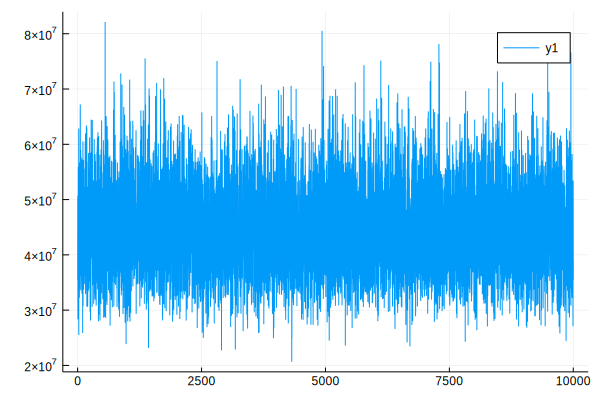

In [128]:
# SGD
verbose = false
iterMax = 10000

mySGD =  SGDConstStep(0.0000000000000001)
accSGD =  Accumulator(ValueAccumulator(),  ParamAccumulator())
samplingStrategy =  RandomSampling(;N = 100, NMax = Nobs(mo_RSG))
state = SGDState(copy(x0), samplingStrategy)

state, accumulatorSGD = mySGD(mo_RSG, state ; sp =  Geraldine.StopParam(eps_g = eps, NMax = iterMax), accumulator = accSGD, verbose = verbose)

resultSGD = Geraldine.structToDict(accumulatorSGD)

paramSGD = resultSGD[:ParamAccumulator]
fSGD = resultSGD[:ValueAccumulator];

plot(fSGD)

Algorithm of type : AdamConstStep{Float64}
Nmax reached ? 
k = 0  and  max = 10000
Nmax reached ? 
k = 1  and  max = 10000
Nmax reached ? 
k = 2  and  max = 10000
Nmax reached ? 
k = 3  and  max = 10000
Nmax reached ? 
k = 4  and  max = 10000
Nmax reached ? 
k = 5  and  max = 10000
Nmax reached ? 
k = 6  and  max = 10000
Nmax reached ? 
k = 7  and  max = 10000
Nmax reached ? 
k = 8  and  max = 10000
Nmax reached ? 
k = 9  and  max = 10000
Nmax reached ? 
k = 10  and  max = 10000
Nmax reached ? 
k = 11  and  max = 10000
Nmax reached ? 
k = 12  and  max = 10000
Nmax reached ? 
k = 13  and  max = 10000
Nmax reached ? 
k = 14  and  max = 10000
Nmax reached ? 
k = 15  and  max = 10000
Nmax reached ? 
k = 16  and  max = 10000
Nmax reached ? 
k = 17  and  max = 10000
Nmax reached ? 
k = 18  and  max = 10000
Nmax reached ? 
k = 19  and  max = 10000
Nmax reached ? 
k = 20  and  max = 10000
Nmax reached ? 
k = 21  and  max = 10000
Nmax reached ? 
k = 22  and  max = 10000
Nmax reached ? 
k = 23  

Nmax reached ? 
k = 198  and  max = 10000
Nmax reached ? 
k = 199  and  max = 10000
Nmax reached ? 
k = 200  and  max = 10000
Nmax reached ? 
k = 201  and  max = 10000
Nmax reached ? 
k = 202  and  max = 10000
Nmax reached ? 
k = 203  and  max = 10000
Nmax reached ? 
k = 204  and  max = 10000
Nmax reached ? 
k = 205  and  max = 10000
Nmax reached ? 
k = 206  and  max = 10000
Nmax reached ? 
k = 207  and  max = 10000
Nmax reached ? 
k = 208  and  max = 10000
Nmax reached ? 
k = 209  and  max = 10000
Nmax reached ? 
k = 210  and  max = 10000
Nmax reached ? 
k = 211  and  max = 10000
Nmax reached ? 
k = 212  and  max = 10000
Nmax reached ? 
k = 213  and  max = 10000
Nmax reached ? 
k = 214  and  max = 10000
Nmax reached ? 
k = 215  and  max = 10000
Nmax reached ? 
k = 216  and  max = 10000
Nmax reached ? 
k = 217  and  max = 10000
Nmax reached ? 
k = 218  and  max = 10000
Nmax reached ? 
k = 219  and  max = 10000
Nmax reached ? 
k = 220  and  max = 10000
Nmax reached ? 
k = 221  and  max 

k = 435  and  max = 10000
Nmax reached ? 
k = 436  and  max = 10000
Nmax reached ? 
k = 437  and  max = 10000
Nmax reached ? 
k = 438  and  max = 10000
Nmax reached ? 
k = 439  and  max = 10000
Nmax reached ? 
k = 440  and  max = 10000
Nmax reached ? 
k = 441  and  max = 10000
Nmax reached ? 
k = 442  and  max = 10000
Nmax reached ? 
k = 443  and  max = 10000
Nmax reached ? 
k = 444  and  max = 10000
Nmax reached ? 
k = 445  and  max = 10000
Nmax reached ? 
k = 446  and  max = 10000
Nmax reached ? 
k = 447  and  max = 10000
Nmax reached ? 
k = 448  and  max = 10000
Nmax reached ? 
k = 449  and  max = 10000
Nmax reached ? 
k = 450  and  max = 10000
Nmax reached ? 
k = 451  and  max = 10000
Nmax reached ? 
k = 452  and  max = 10000
Nmax reached ? 
k = 453  and  max = 10000
Nmax reached ? 
k = 454  and  max = 10000
Nmax reached ? 
k = 455  and  max = 10000
Nmax reached ? 
k = 456  and  max = 10000
Nmax reached ? 
k = 457  and  max = 10000
Nmax reached ? 
k = 458  and  max = 10000
Nmax rea

Nmax reached ? 
k = 633  and  max = 10000
Nmax reached ? 
k = 634  and  max = 10000
Nmax reached ? 
k = 635  and  max = 10000
Nmax reached ? 
k = 636  and  max = 10000
Nmax reached ? 
k = 637  and  max = 10000
Nmax reached ? 
k = 638  and  max = 10000
Nmax reached ? 
k = 639  and  max = 10000
Nmax reached ? 
k = 640  and  max = 10000
Nmax reached ? 
k = 641  and  max = 10000
Nmax reached ? 
k = 642  and  max = 10000
Nmax reached ? 
k = 643  and  max = 10000
Nmax reached ? 
k = 644  and  max = 10000
Nmax reached ? 
k = 645  and  max = 10000
Nmax reached ? 
k = 646  and  max = 10000
Nmax reached ? 
k = 647  and  max = 10000
Nmax reached ? 
k = 648  and  max = 10000
Nmax reached ? 
k = 649  and  max = 10000
Nmax reached ? 
k = 650  and  max = 10000
Nmax reached ? 
k = 651  and  max = 10000
Nmax reached ? 
k = 652  and  max = 10000
Nmax reached ? 
k = 653  and  max = 10000
Nmax reached ? 
k = 654  and  max = 10000
Nmax reached ? 
k = 655  and  max = 10000
Nmax reached ? 
k = 656  and  max 

k = 839  and  max = 10000
Nmax reached ? 
k = 840  and  max = 10000
Nmax reached ? 
k = 841  and  max = 10000
Nmax reached ? 
k = 842  and  max = 10000
Nmax reached ? 
k = 843  and  max = 10000
Nmax reached ? 
k = 844  and  max = 10000
Nmax reached ? 
k = 845  and  max = 10000
Nmax reached ? 
k = 846  and  max = 10000
Nmax reached ? 
k = 847  and  max = 10000
Nmax reached ? 
k = 848  and  max = 10000
Nmax reached ? 
k = 849  and  max = 10000
Nmax reached ? 
k = 850  and  max = 10000
Nmax reached ? 
k = 851  and  max = 10000
Nmax reached ? 
k = 852  and  max = 10000
Nmax reached ? 
k = 853  and  max = 10000
Nmax reached ? 
k = 854  and  max = 10000
Nmax reached ? 
k = 855  and  max = 10000
Nmax reached ? 
k = 856  and  max = 10000
Nmax reached ? 
k = 857  and  max = 10000
Nmax reached ? 
k = 858  and  max = 10000
Nmax reached ? 
k = 859  and  max = 10000
Nmax reached ? 
k = 860  and  max = 10000
Nmax reached ? 
k = 861  and  max = 10000
Nmax reached ? 
k = 862  and  max = 10000
Nmax rea

Nmax reached ? 
k = 1039  and  max = 10000
Nmax reached ? 
k = 1040  and  max = 10000
Nmax reached ? 
k = 1041  and  max = 10000
Nmax reached ? 
k = 1042  and  max = 10000
Nmax reached ? 
k = 1043  and  max = 10000
Nmax reached ? 
k = 1044  and  max = 10000
Nmax reached ? 
k = 1045  and  max = 10000
Nmax reached ? 
k = 1046  and  max = 10000
Nmax reached ? 
k = 1047  and  max = 10000
Nmax reached ? 
k = 1048  and  max = 10000
Nmax reached ? 
k = 1049  and  max = 10000
Nmax reached ? 
k = 1050  and  max = 10000
Nmax reached ? 
k = 1051  and  max = 10000
Nmax reached ? 
k = 1052  and  max = 10000
Nmax reached ? 
k = 1053  and  max = 10000
Nmax reached ? 
k = 1054  and  max = 10000
Nmax reached ? 
k = 1055  and  max = 10000
Nmax reached ? 
k = 1056  and  max = 10000
Nmax reached ? 
k = 1057  and  max = 10000
Nmax reached ? 
k = 1058  and  max = 10000
Nmax reached ? 
k = 1059  and  max = 10000
Nmax reached ? 
k = 1060  and  max = 10000
Nmax reached ? 
k = 1061  and  max = 10000
Nmax reache

Nmax reached ? 
k = 1240  and  max = 10000
Nmax reached ? 
k = 1241  and  max = 10000
Nmax reached ? 
k = 1242  and  max = 10000
Nmax reached ? 
k = 1243  and  max = 10000
Nmax reached ? 
k = 1244  and  max = 10000
Nmax reached ? 
k = 1245  and  max = 10000
Nmax reached ? 
k = 1246  and  max = 10000
Nmax reached ? 
k = 1247  and  max = 10000
Nmax reached ? 
k = 1248  and  max = 10000
Nmax reached ? 
k = 1249  and  max = 10000
Nmax reached ? 
k = 1250  and  max = 10000
Nmax reached ? 
k = 1251  and  max = 10000
Nmax reached ? 
k = 1252  and  max = 10000
Nmax reached ? 
k = 1253  and  max = 10000
Nmax reached ? 
k = 1254  and  max = 10000
Nmax reached ? 
k = 1255  and  max = 10000
Nmax reached ? 
k = 1256  and  max = 10000
Nmax reached ? 
k = 1257  and  max = 10000
Nmax reached ? 
k = 1258  and  max = 10000
Nmax reached ? 
k = 1259  and  max = 10000
Nmax reached ? 
k = 1260  and  max = 10000
Nmax reached ? 
k = 1261  and  max = 10000
Nmax reached ? 
k = 1262  and  max = 10000
Nmax reache

k = 1437  and  max = 10000
Nmax reached ? 
k = 1438  and  max = 10000
Nmax reached ? 
k = 1439  and  max = 10000
Nmax reached ? 
k = 1440  and  max = 10000
Nmax reached ? 
k = 1441  and  max = 10000
Nmax reached ? 
k = 1442  and  max = 10000
Nmax reached ? 
k = 1443  and  max = 10000
Nmax reached ? 
k = 1444  and  max = 10000
Nmax reached ? 
k = 1445  and  max = 10000
Nmax reached ? 
k = 1446  and  max = 10000
Nmax reached ? 
k = 1447  and  max = 10000
Nmax reached ? 
k = 1448  and  max = 10000
Nmax reached ? 
k = 1449  and  max = 10000
Nmax reached ? 
k = 1450  and  max = 10000
Nmax reached ? 
k = 1451  and  max = 10000
Nmax reached ? 
k = 1452  and  max = 10000
Nmax reached ? 
k = 1453  and  max = 10000
Nmax reached ? 
k = 1454  and  max = 10000
Nmax reached ? 
k = 1455  and  max = 10000
Nmax reached ? 
k = 1456  and  max = 10000
Nmax reached ? 
k = 1457  and  max = 10000
Nmax reached ? 
k = 1458  and  max = 10000
Nmax reached ? 
k = 1459  and  max = 10000
Nmax reached ? 
k = 1460  a

Nmax reached ? 
k = 1642  and  max = 10000
Nmax reached ? 
k = 1643  and  max = 10000
Nmax reached ? 
k = 1644  and  max = 10000
Nmax reached ? 
k = 1645  and  max = 10000
Nmax reached ? 
k = 1646  and  max = 10000
Nmax reached ? 
k = 1647  and  max = 10000
Nmax reached ? 
k = 1648  and  max = 10000
Nmax reached ? 
k = 1649  and  max = 10000
Nmax reached ? 
k = 1650  and  max = 10000
Nmax reached ? 
k = 1651  and  max = 10000
Nmax reached ? 
k = 1652  and  max = 10000
Nmax reached ? 
k = 1653  and  max = 10000
Nmax reached ? 
k = 1654  and  max = 10000
Nmax reached ? 
k = 1655  and  max = 10000
Nmax reached ? 
k = 1656  and  max = 10000
Nmax reached ? 
k = 1657  and  max = 10000
Nmax reached ? 
k = 1658  and  max = 10000
Nmax reached ? 
k = 1659  and  max = 10000
Nmax reached ? 
k = 1660  and  max = 10000
Nmax reached ? 
k = 1661  and  max = 10000
Nmax reached ? 
k = 1662  and  max = 10000
Nmax reached ? 
k = 1663  and  max = 10000
Nmax reached ? 
k = 1664  and  max = 10000
Nmax reache

k = 1851  and  max = 10000
Nmax reached ? 
k = 1852  and  max = 10000
Nmax reached ? 
k = 1853  and  max = 10000
Nmax reached ? 
k = 1854  and  max = 10000
Nmax reached ? 
k = 1855  and  max = 10000
Nmax reached ? 
k = 1856  and  max = 10000
Nmax reached ? 
k = 1857  and  max = 10000
Nmax reached ? 
k = 1858  and  max = 10000
Nmax reached ? 
k = 1859  and  max = 10000
Nmax reached ? 
k = 1860  and  max = 10000
Nmax reached ? 
k = 1861  and  max = 10000
Nmax reached ? 
k = 1862  and  max = 10000
Nmax reached ? 
k = 1863  and  max = 10000
Nmax reached ? 
k = 1864  and  max = 10000
Nmax reached ? 
k = 1865  and  max = 10000
Nmax reached ? 
k = 1866  and  max = 10000
Nmax reached ? 
k = 1867  and  max = 10000
Nmax reached ? 
k = 1868  and  max = 10000
Nmax reached ? 
k = 1869  and  max = 10000
Nmax reached ? 
k = 1870  and  max = 10000
Nmax reached ? 
k = 1871  and  max = 10000
Nmax reached ? 
k = 1872  and  max = 10000
Nmax reached ? 
k = 1873  and  max = 10000
Nmax reached ? 
k = 1874  a

k = 2066  and  max = 10000
Nmax reached ? 
k = 2067  and  max = 10000
Nmax reached ? 
k = 2068  and  max = 10000
Nmax reached ? 
k = 2069  and  max = 10000
Nmax reached ? 
k = 2070  and  max = 10000
Nmax reached ? 
k = 2071  and  max = 10000
Nmax reached ? 
k = 2072  and  max = 10000
Nmax reached ? 
k = 2073  and  max = 10000
Nmax reached ? 
k = 2074  and  max = 10000
Nmax reached ? 
k = 2075  and  max = 10000
Nmax reached ? 
k = 2076  and  max = 10000
Nmax reached ? 
k = 2077  and  max = 10000
Nmax reached ? 
k = 2078  and  max = 10000
Nmax reached ? 
k = 2079  and  max = 10000
Nmax reached ? 
k = 2080  and  max = 10000
Nmax reached ? 
k = 2081  and  max = 10000
Nmax reached ? 
k = 2082  and  max = 10000
Nmax reached ? 
k = 2083  and  max = 10000
Nmax reached ? 
k = 2084  and  max = 10000
Nmax reached ? 
k = 2085  and  max = 10000
Nmax reached ? 
k = 2086  and  max = 10000
Nmax reached ? 
k = 2087  and  max = 10000
Nmax reached ? 
k = 2088  and  max = 10000
Nmax reached ? 
k = 2089  a

Nmax reached ? 
k = 2311  and  max = 10000
Nmax reached ? 
k = 2312  and  max = 10000
Nmax reached ? 
k = 2313  and  max = 10000
Nmax reached ? 
k = 2314  and  max = 10000
Nmax reached ? 
k = 2315  and  max = 10000
Nmax reached ? 
k = 2316  and  max = 10000
Nmax reached ? 
k = 2317  and  max = 10000
Nmax reached ? 
k = 2318  and  max = 10000
Nmax reached ? 
k = 2319  and  max = 10000
Nmax reached ? 
k = 2320  and  max = 10000
Nmax reached ? 
k = 2321  and  max = 10000
Nmax reached ? 
k = 2322  and  max = 10000
Nmax reached ? 
k = 2323  and  max = 10000
Nmax reached ? 
k = 2324  and  max = 10000
Nmax reached ? 
k = 2325  and  max = 10000
Nmax reached ? 
k = 2326  and  max = 10000
Nmax reached ? 
k = 2327  and  max = 10000
Nmax reached ? 
k = 2328  and  max = 10000
Nmax reached ? 
k = 2329  and  max = 10000
Nmax reached ? 
k = 2330  and  max = 10000
Nmax reached ? 
k = 2331  and  max = 10000
Nmax reached ? 
k = 2332  and  max = 10000
Nmax reached ? 
k = 2333  and  max = 10000
Nmax reache

k = 2502  and  max = 10000
Nmax reached ? 
k = 2503  and  max = 10000
Nmax reached ? 
k = 2504  and  max = 10000
Nmax reached ? 
k = 2505  and  max = 10000
Nmax reached ? 
k = 2506  and  max = 10000
Nmax reached ? 
k = 2507  and  max = 10000
Nmax reached ? 
k = 2508  and  max = 10000
Nmax reached ? 
k = 2509  and  max = 10000
Nmax reached ? 
k = 2510  and  max = 10000
Nmax reached ? 
k = 2511  and  max = 10000
Nmax reached ? 
k = 2512  and  max = 10000
Nmax reached ? 
k = 2513  and  max = 10000
Nmax reached ? 
k = 2514  and  max = 10000
Nmax reached ? 
k = 2515  and  max = 10000
Nmax reached ? 
k = 2516  and  max = 10000
Nmax reached ? 
k = 2517  and  max = 10000
Nmax reached ? 
k = 2518  and  max = 10000
Nmax reached ? 
k = 2519  and  max = 10000
Nmax reached ? 
k = 2520  and  max = 10000
Nmax reached ? 
k = 2521  and  max = 10000
Nmax reached ? 
k = 2522  and  max = 10000
Nmax reached ? 
k = 2523  and  max = 10000
Nmax reached ? 
k = 2524  and  max = 10000
Nmax reached ? 
k = 2525  a

k = 2703  and  max = 10000
Nmax reached ? 
k = 2704  and  max = 10000
Nmax reached ? 
k = 2705  and  max = 10000
Nmax reached ? 
k = 2706  and  max = 10000
Nmax reached ? 
k = 2707  and  max = 10000
Nmax reached ? 
k = 2708  and  max = 10000
Nmax reached ? 
k = 2709  and  max = 10000
Nmax reached ? 
k = 2710  and  max = 10000
Nmax reached ? 
k = 2711  and  max = 10000
Nmax reached ? 
k = 2712  and  max = 10000
Nmax reached ? 
k = 2713  and  max = 10000
Nmax reached ? 
k = 2714  and  max = 10000
Nmax reached ? 
k = 2715  and  max = 10000
Nmax reached ? 
k = 2716  and  max = 10000
Nmax reached ? 
k = 2717  and  max = 10000
Nmax reached ? 
k = 2718  and  max = 10000
Nmax reached ? 
k = 2719  and  max = 10000
Nmax reached ? 
k = 2720  and  max = 10000
Nmax reached ? 
k = 2721  and  max = 10000
Nmax reached ? 
k = 2722  and  max = 10000
Nmax reached ? 
k = 2723  and  max = 10000
Nmax reached ? 
k = 2724  and  max = 10000
Nmax reached ? 
k = 2725  and  max = 10000
Nmax reached ? 
k = 2726  a

k = 2932  and  max = 10000
Nmax reached ? 
k = 2933  and  max = 10000
Nmax reached ? 
k = 2934  and  max = 10000
Nmax reached ? 
k = 2935  and  max = 10000
Nmax reached ? 
k = 2936  and  max = 10000
Nmax reached ? 
k = 2937  and  max = 10000
Nmax reached ? 
k = 2938  and  max = 10000
Nmax reached ? 
k = 2939  and  max = 10000
Nmax reached ? 
k = 2940  and  max = 10000
Nmax reached ? 
k = 2941  and  max = 10000
Nmax reached ? 
k = 2942  and  max = 10000
Nmax reached ? 
k = 2943  and  max = 10000
Nmax reached ? 
k = 2944  and  max = 10000
Nmax reached ? 
k = 2945  and  max = 10000
Nmax reached ? 
k = 2946  and  max = 10000
Nmax reached ? 
k = 2947  and  max = 10000
Nmax reached ? 
k = 2948  and  max = 10000
Nmax reached ? 
k = 2949  and  max = 10000
Nmax reached ? 
k = 2950  and  max = 10000
Nmax reached ? 
k = 2951  and  max = 10000
Nmax reached ? 
k = 2952  and  max = 10000
Nmax reached ? 
k = 2953  and  max = 10000
Nmax reached ? 
k = 2954  and  max = 10000
Nmax reached ? 
k = 2955  a

Nmax reached ? 
k = 3170  and  max = 10000
Nmax reached ? 
k = 3171  and  max = 10000
Nmax reached ? 
k = 3172  and  max = 10000
Nmax reached ? 
k = 3173  and  max = 10000
Nmax reached ? 
k = 3174  and  max = 10000
Nmax reached ? 
k = 3175  and  max = 10000
Nmax reached ? 
k = 3176  and  max = 10000
Nmax reached ? 
k = 3177  and  max = 10000
Nmax reached ? 
k = 3178  and  max = 10000
Nmax reached ? 
k = 3179  and  max = 10000
Nmax reached ? 
k = 3180  and  max = 10000
Nmax reached ? 
k = 3181  and  max = 10000
Nmax reached ? 
k = 3182  and  max = 10000
Nmax reached ? 
k = 3183  and  max = 10000
Nmax reached ? 
k = 3184  and  max = 10000
Nmax reached ? 
k = 3185  and  max = 10000
Nmax reached ? 
k = 3186  and  max = 10000
Nmax reached ? 
k = 3187  and  max = 10000
Nmax reached ? 
k = 3188  and  max = 10000
Nmax reached ? 
k = 3189  and  max = 10000
Nmax reached ? 
k = 3190  and  max = 10000
Nmax reached ? 
k = 3191  and  max = 10000
Nmax reached ? 
k = 3192  and  max = 10000
Nmax reache

k = 3394  and  max = 10000
Nmax reached ? 
k = 3395  and  max = 10000
Nmax reached ? 
k = 3396  and  max = 10000
Nmax reached ? 
k = 3397  and  max = 10000
Nmax reached ? 
k = 3398  and  max = 10000
Nmax reached ? 
k = 3399  and  max = 10000
Nmax reached ? 
k = 3400  and  max = 10000
Nmax reached ? 
k = 3401  and  max = 10000
Nmax reached ? 
k = 3402  and  max = 10000
Nmax reached ? 
k = 3403  and  max = 10000
Nmax reached ? 
k = 3404  and  max = 10000
Nmax reached ? 
k = 3405  and  max = 10000
Nmax reached ? 
k = 3406  and  max = 10000
Nmax reached ? 
k = 3407  and  max = 10000
Nmax reached ? 
k = 3408  and  max = 10000
Nmax reached ? 
k = 3409  and  max = 10000
Nmax reached ? 
k = 3410  and  max = 10000
Nmax reached ? 
k = 3411  and  max = 10000
Nmax reached ? 
k = 3412  and  max = 10000
Nmax reached ? 
k = 3413  and  max = 10000
Nmax reached ? 
k = 3414  and  max = 10000
Nmax reached ? 
k = 3415  and  max = 10000
Nmax reached ? 
k = 3416  and  max = 10000
Nmax reached ? 
k = 3417  a

k = 3610  and  max = 10000
Nmax reached ? 
k = 3611  and  max = 10000
Nmax reached ? 
k = 3612  and  max = 10000
Nmax reached ? 
k = 3613  and  max = 10000
Nmax reached ? 
k = 3614  and  max = 10000
Nmax reached ? 
k = 3615  and  max = 10000
Nmax reached ? 
k = 3616  and  max = 10000
Nmax reached ? 
k = 3617  and  max = 10000
Nmax reached ? 
k = 3618  and  max = 10000
Nmax reached ? 
k = 3619  and  max = 10000
Nmax reached ? 
k = 3620  and  max = 10000
Nmax reached ? 
k = 3621  and  max = 10000
Nmax reached ? 
k = 3622  and  max = 10000
Nmax reached ? 
k = 3623  and  max = 10000
Nmax reached ? 
k = 3624  and  max = 10000
Nmax reached ? 
k = 3625  and  max = 10000
Nmax reached ? 
k = 3626  and  max = 10000
Nmax reached ? 
k = 3627  and  max = 10000
Nmax reached ? 
k = 3628  and  max = 10000
Nmax reached ? 
k = 3629  and  max = 10000
Nmax reached ? 
k = 3630  and  max = 10000
Nmax reached ? 
k = 3631  and  max = 10000
Nmax reached ? 
k = 3632  and  max = 10000
Nmax reached ? 
k = 3633  a

k = 3851  and  max = 10000
Nmax reached ? 
k = 3852  and  max = 10000
Nmax reached ? 
k = 3853  and  max = 10000
Nmax reached ? 
k = 3854  and  max = 10000
Nmax reached ? 
k = 3855  and  max = 10000
Nmax reached ? 
k = 3856  and  max = 10000
Nmax reached ? 
k = 3857  and  max = 10000
Nmax reached ? 
k = 3858  and  max = 10000
Nmax reached ? 
k = 3859  and  max = 10000
Nmax reached ? 
k = 3860  and  max = 10000
Nmax reached ? 
k = 3861  and  max = 10000
Nmax reached ? 
k = 3862  and  max = 10000
Nmax reached ? 
k = 3863  and  max = 10000
Nmax reached ? 
k = 3864  and  max = 10000
Nmax reached ? 
k = 3865  and  max = 10000
Nmax reached ? 
k = 3866  and  max = 10000
Nmax reached ? 
k = 3867  and  max = 10000
Nmax reached ? 
k = 3868  and  max = 10000
Nmax reached ? 
k = 3869  and  max = 10000
Nmax reached ? 
k = 3870  and  max = 10000
Nmax reached ? 
k = 3871  and  max = 10000
Nmax reached ? 
k = 3872  and  max = 10000
Nmax reached ? 
k = 3873  and  max = 10000
Nmax reached ? 
k = 3874  a

Nmax reached ? 
k = 4070  and  max = 10000
Nmax reached ? 
k = 4071  and  max = 10000
Nmax reached ? 
k = 4072  and  max = 10000
Nmax reached ? 
k = 4073  and  max = 10000
Nmax reached ? 
k = 4074  and  max = 10000
Nmax reached ? 
k = 4075  and  max = 10000
Nmax reached ? 
k = 4076  and  max = 10000
Nmax reached ? 
k = 4077  and  max = 10000
Nmax reached ? 
k = 4078  and  max = 10000
Nmax reached ? 
k = 4079  and  max = 10000
Nmax reached ? 
k = 4080  and  max = 10000
Nmax reached ? 
k = 4081  and  max = 10000
Nmax reached ? 
k = 4082  and  max = 10000
Nmax reached ? 
k = 4083  and  max = 10000
Nmax reached ? 
k = 4084  and  max = 10000
Nmax reached ? 
k = 4085  and  max = 10000
Nmax reached ? 
k = 4086  and  max = 10000
Nmax reached ? 
k = 4087  and  max = 10000
Nmax reached ? 
k = 4088  and  max = 10000
Nmax reached ? 
k = 4089  and  max = 10000
Nmax reached ? 
k = 4090  and  max = 10000
Nmax reached ? 
k = 4091  and  max = 10000
Nmax reached ? 
k = 4092  and  max = 10000
Nmax reache

k = 4264  and  max = 10000
Nmax reached ? 
k = 4265  and  max = 10000
Nmax reached ? 
k = 4266  and  max = 10000
Nmax reached ? 
k = 4267  and  max = 10000
Nmax reached ? 
k = 4268  and  max = 10000
Nmax reached ? 
k = 4269  and  max = 10000
Nmax reached ? 
k = 4270  and  max = 10000
Nmax reached ? 
k = 4271  and  max = 10000
Nmax reached ? 
k = 4272  and  max = 10000
Nmax reached ? 
k = 4273  and  max = 10000
Nmax reached ? 
k = 4274  and  max = 10000
Nmax reached ? 
k = 4275  and  max = 10000
Nmax reached ? 
k = 4276  and  max = 10000
Nmax reached ? 
k = 4277  and  max = 10000
Nmax reached ? 
k = 4278  and  max = 10000
Nmax reached ? 
k = 4279  and  max = 10000
Nmax reached ? 
k = 4280  and  max = 10000
Nmax reached ? 
k = 4281  and  max = 10000
Nmax reached ? 
k = 4282  and  max = 10000
Nmax reached ? 
k = 4283  and  max = 10000
Nmax reached ? 
k = 4284  and  max = 10000
Nmax reached ? 
k = 4285  and  max = 10000
Nmax reached ? 
k = 4286  and  max = 10000
Nmax reached ? 
k = 4287  a

Nmax reached ? 
k = 4473  and  max = 10000
Nmax reached ? 
k = 4474  and  max = 10000
Nmax reached ? 
k = 4475  and  max = 10000
Nmax reached ? 
k = 4476  and  max = 10000
Nmax reached ? 
k = 4477  and  max = 10000
Nmax reached ? 
k = 4478  and  max = 10000
Nmax reached ? 
k = 4479  and  max = 10000
Nmax reached ? 
k = 4480  and  max = 10000
Nmax reached ? 
k = 4481  and  max = 10000
Nmax reached ? 
k = 4482  and  max = 10000
Nmax reached ? 
k = 4483  and  max = 10000
Nmax reached ? 
k = 4484  and  max = 10000
Nmax reached ? 
k = 4485  and  max = 10000
Nmax reached ? 
k = 4486  and  max = 10000
Nmax reached ? 
k = 4487  and  max = 10000
Nmax reached ? 
k = 4488  and  max = 10000
Nmax reached ? 
k = 4489  and  max = 10000
Nmax reached ? 
k = 4490  and  max = 10000
Nmax reached ? 
k = 4491  and  max = 10000
Nmax reached ? 
k = 4492  and  max = 10000
Nmax reached ? 
k = 4493  and  max = 10000
Nmax reached ? 
k = 4494  and  max = 10000
Nmax reached ? 
k = 4495  and  max = 10000
Nmax reache

k = 4668  and  max = 10000
Nmax reached ? 
k = 4669  and  max = 10000
Nmax reached ? 
k = 4670  and  max = 10000
Nmax reached ? 
k = 4671  and  max = 10000
Nmax reached ? 
k = 4672  and  max = 10000
Nmax reached ? 
k = 4673  and  max = 10000
Nmax reached ? 
k = 4674  and  max = 10000
Nmax reached ? 
k = 4675  and  max = 10000
Nmax reached ? 
k = 4676  and  max = 10000
Nmax reached ? 
k = 4677  and  max = 10000
Nmax reached ? 
k = 4678  and  max = 10000
Nmax reached ? 
k = 4679  and  max = 10000
Nmax reached ? 
k = 4680  and  max = 10000
Nmax reached ? 
k = 4681  and  max = 10000
Nmax reached ? 
k = 4682  and  max = 10000
Nmax reached ? 
k = 4683  and  max = 10000
Nmax reached ? 
k = 4684  and  max = 10000
Nmax reached ? 
k = 4685  and  max = 10000
Nmax reached ? 
k = 4686  and  max = 10000
Nmax reached ? 
k = 4687  and  max = 10000
Nmax reached ? 
k = 4688  and  max = 10000
Nmax reached ? 
k = 4689  and  max = 10000
Nmax reached ? 
k = 4690  and  max = 10000
Nmax reached ? 
k = 4691  a

Nmax reached ? 
k = 4871  and  max = 10000
Nmax reached ? 
k = 4872  and  max = 10000
Nmax reached ? 
k = 4873  and  max = 10000
Nmax reached ? 
k = 4874  and  max = 10000
Nmax reached ? 
k = 4875  and  max = 10000
Nmax reached ? 
k = 4876  and  max = 10000
Nmax reached ? 
k = 4877  and  max = 10000
Nmax reached ? 
k = 4878  and  max = 10000
Nmax reached ? 
k = 4879  and  max = 10000
Nmax reached ? 
k = 4880  and  max = 10000
Nmax reached ? 
k = 4881  and  max = 10000
Nmax reached ? 
k = 4882  and  max = 10000
Nmax reached ? 
k = 4883  and  max = 10000
Nmax reached ? 
k = 4884  and  max = 10000
Nmax reached ? 
k = 4885  and  max = 10000
Nmax reached ? 
k = 4886  and  max = 10000
Nmax reached ? 
k = 4887  and  max = 10000
Nmax reached ? 
k = 4888  and  max = 10000
Nmax reached ? 
k = 4889  and  max = 10000
Nmax reached ? 
k = 4890  and  max = 10000
Nmax reached ? 
k = 4891  and  max = 10000
Nmax reached ? 
k = 4892  and  max = 10000
Nmax reached ? 
k = 4893  and  max = 10000
Nmax reache

k = 5120  and  max = 10000
Nmax reached ? 
k = 5121  and  max = 10000
Nmax reached ? 
k = 5122  and  max = 10000
Nmax reached ? 
k = 5123  and  max = 10000
Nmax reached ? 
k = 5124  and  max = 10000
Nmax reached ? 
k = 5125  and  max = 10000
Nmax reached ? 
k = 5126  and  max = 10000
Nmax reached ? 
k = 5127  and  max = 10000
Nmax reached ? 
k = 5128  and  max = 10000
Nmax reached ? 
k = 5129  and  max = 10000
Nmax reached ? 
k = 5130  and  max = 10000
Nmax reached ? 
k = 5131  and  max = 10000
Nmax reached ? 
k = 5132  and  max = 10000
Nmax reached ? 
k = 5133  and  max = 10000
Nmax reached ? 
k = 5134  and  max = 10000
Nmax reached ? 
k = 5135  and  max = 10000
Nmax reached ? 
k = 5136  and  max = 10000
Nmax reached ? 
k = 5137  and  max = 10000
Nmax reached ? 
k = 5138  and  max = 10000
Nmax reached ? 
k = 5139  and  max = 10000
Nmax reached ? 
k = 5140  and  max = 10000
Nmax reached ? 
k = 5141  and  max = 10000
Nmax reached ? 
k = 5142  and  max = 10000
Nmax reached ? 
k = 5143  a

Nmax reached ? 
k = 5319  and  max = 10000
Nmax reached ? 
k = 5320  and  max = 10000
Nmax reached ? 
k = 5321  and  max = 10000
Nmax reached ? 
k = 5322  and  max = 10000
Nmax reached ? 
k = 5323  and  max = 10000
Nmax reached ? 
k = 5324  and  max = 10000
Nmax reached ? 
k = 5325  and  max = 10000
Nmax reached ? 
k = 5326  and  max = 10000
Nmax reached ? 
k = 5327  and  max = 10000
Nmax reached ? 
k = 5328  and  max = 10000
Nmax reached ? 
k = 5329  and  max = 10000
Nmax reached ? 
k = 5330  and  max = 10000
Nmax reached ? 
k = 5331  and  max = 10000
Nmax reached ? 
k = 5332  and  max = 10000
Nmax reached ? 
k = 5333  and  max = 10000
Nmax reached ? 
k = 5334  and  max = 10000
Nmax reached ? 
k = 5335  and  max = 10000
Nmax reached ? 
k = 5336  and  max = 10000
Nmax reached ? 
k = 5337  and  max = 10000
Nmax reached ? 
k = 5338  and  max = 10000
Nmax reached ? 
k = 5339  and  max = 10000
Nmax reached ? 
k = 5340  and  max = 10000
Nmax reached ? 
k = 5341  and  max = 10000
Nmax reache

k = 5522  and  max = 10000
Nmax reached ? 
k = 5523  and  max = 10000
Nmax reached ? 
k = 5524  and  max = 10000
Nmax reached ? 
k = 5525  and  max = 10000
Nmax reached ? 
k = 5526  and  max = 10000
Nmax reached ? 
k = 5527  and  max = 10000
Nmax reached ? 
k = 5528  and  max = 10000
Nmax reached ? 
k = 5529  and  max = 10000
Nmax reached ? 
k = 5530  and  max = 10000
Nmax reached ? 
k = 5531  and  max = 10000
Nmax reached ? 
k = 5532  and  max = 10000
Nmax reached ? 
k = 5533  and  max = 10000
Nmax reached ? 
k = 5534  and  max = 10000
Nmax reached ? 
k = 5535  and  max = 10000
Nmax reached ? 
k = 5536  and  max = 10000
Nmax reached ? 
k = 5537  and  max = 10000
Nmax reached ? 
k = 5538  and  max = 10000
Nmax reached ? 
k = 5539  and  max = 10000
Nmax reached ? 
k = 5540  and  max = 10000
Nmax reached ? 
k = 5541  and  max = 10000
Nmax reached ? 
k = 5542  and  max = 10000
Nmax reached ? 
k = 5543  and  max = 10000
Nmax reached ? 
k = 5544  and  max = 10000
Nmax reached ? 
k = 5545  a

Nmax reached ? 
k = 5715  and  max = 10000
Nmax reached ? 
k = 5716  and  max = 10000
Nmax reached ? 
k = 5717  and  max = 10000
Nmax reached ? 
k = 5718  and  max = 10000
Nmax reached ? 
k = 5719  and  max = 10000
Nmax reached ? 
k = 5720  and  max = 10000
Nmax reached ? 
k = 5721  and  max = 10000
Nmax reached ? 
k = 5722  and  max = 10000
Nmax reached ? 
k = 5723  and  max = 10000
Nmax reached ? 
k = 5724  and  max = 10000
Nmax reached ? 
k = 5725  and  max = 10000
Nmax reached ? 
k = 5726  and  max = 10000
Nmax reached ? 
k = 5727  and  max = 10000
Nmax reached ? 
k = 5728  and  max = 10000
Nmax reached ? 
k = 5729  and  max = 10000
Nmax reached ? 
k = 5730  and  max = 10000
Nmax reached ? 
k = 5731  and  max = 10000
Nmax reached ? 
k = 5732  and  max = 10000
Nmax reached ? 
k = 5733  and  max = 10000
Nmax reached ? 
k = 5734  and  max = 10000
Nmax reached ? 
k = 5735  and  max = 10000
Nmax reached ? 
k = 5736  and  max = 10000
Nmax reached ? 
k = 5737  and  max = 10000
Nmax reache

k = 5919  and  max = 10000
Nmax reached ? 
k = 5920  and  max = 10000
Nmax reached ? 
k = 5921  and  max = 10000
Nmax reached ? 
k = 5922  and  max = 10000
Nmax reached ? 
k = 5923  and  max = 10000
Nmax reached ? 
k = 5924  and  max = 10000
Nmax reached ? 
k = 5925  and  max = 10000
Nmax reached ? 
k = 5926  and  max = 10000
Nmax reached ? 
k = 5927  and  max = 10000
Nmax reached ? 
k = 5928  and  max = 10000
Nmax reached ? 
k = 5929  and  max = 10000
Nmax reached ? 
k = 5930  and  max = 10000
Nmax reached ? 
k = 5931  and  max = 10000
Nmax reached ? 
k = 5932  and  max = 10000
Nmax reached ? 
k = 5933  and  max = 10000
Nmax reached ? 
k = 5934  and  max = 10000
Nmax reached ? 
k = 5935  and  max = 10000
Nmax reached ? 
k = 5936  and  max = 10000
Nmax reached ? 
k = 5937  and  max = 10000
Nmax reached ? 
k = 5938  and  max = 10000
Nmax reached ? 
k = 5939  and  max = 10000
Nmax reached ? 
k = 5940  and  max = 10000
Nmax reached ? 
k = 5941  and  max = 10000
Nmax reached ? 
k = 5942  a

Nmax reached ? 
k = 6118  and  max = 10000
Nmax reached ? 
k = 6119  and  max = 10000
Nmax reached ? 
k = 6120  and  max = 10000
Nmax reached ? 
k = 6121  and  max = 10000
Nmax reached ? 
k = 6122  and  max = 10000
Nmax reached ? 
k = 6123  and  max = 10000
Nmax reached ? 
k = 6124  and  max = 10000
Nmax reached ? 
k = 6125  and  max = 10000
Nmax reached ? 
k = 6126  and  max = 10000
Nmax reached ? 
k = 6127  and  max = 10000
Nmax reached ? 
k = 6128  and  max = 10000
Nmax reached ? 
k = 6129  and  max = 10000
Nmax reached ? 
k = 6130  and  max = 10000
Nmax reached ? 
k = 6131  and  max = 10000
Nmax reached ? 
k = 6132  and  max = 10000
Nmax reached ? 
k = 6133  and  max = 10000
Nmax reached ? 
k = 6134  and  max = 10000
Nmax reached ? 
k = 6135  and  max = 10000
Nmax reached ? 
k = 6136  and  max = 10000
Nmax reached ? 
k = 6137  and  max = 10000
Nmax reached ? 
k = 6138  and  max = 10000
Nmax reached ? 
k = 6139  and  max = 10000
Nmax reached ? 
k = 6140  and  max = 10000
Nmax reache

k = 6328  and  max = 10000
Nmax reached ? 
k = 6329  and  max = 10000
Nmax reached ? 
k = 6330  and  max = 10000
Nmax reached ? 
k = 6331  and  max = 10000
Nmax reached ? 
k = 6332  and  max = 10000
Nmax reached ? 
k = 6333  and  max = 10000
Nmax reached ? 
k = 6334  and  max = 10000
Nmax reached ? 
k = 6335  and  max = 10000
Nmax reached ? 
k = 6336  and  max = 10000
Nmax reached ? 
k = 6337  and  max = 10000
Nmax reached ? 
k = 6338  and  max = 10000
Nmax reached ? 
k = 6339  and  max = 10000
Nmax reached ? 
k = 6340  and  max = 10000
Nmax reached ? 
k = 6341  and  max = 10000
Nmax reached ? 
k = 6342  and  max = 10000
Nmax reached ? 
k = 6343  and  max = 10000
Nmax reached ? 
k = 6344  and  max = 10000
Nmax reached ? 
k = 6345  and  max = 10000
Nmax reached ? 
k = 6346  and  max = 10000
Nmax reached ? 
k = 6347  and  max = 10000
Nmax reached ? 
k = 6348  and  max = 10000
Nmax reached ? 
k = 6349  and  max = 10000
Nmax reached ? 
k = 6350  and  max = 10000
Nmax reached ? 
k = 6351  a

k = 6546  and  max = 10000
Nmax reached ? 
k = 6547  and  max = 10000
Nmax reached ? 
k = 6548  and  max = 10000
Nmax reached ? 
k = 6549  and  max = 10000
Nmax reached ? 
k = 6550  and  max = 10000
Nmax reached ? 
k = 6551  and  max = 10000
Nmax reached ? 
k = 6552  and  max = 10000
Nmax reached ? 
k = 6553  and  max = 10000
Nmax reached ? 
k = 6554  and  max = 10000
Nmax reached ? 
k = 6555  and  max = 10000
Nmax reached ? 
k = 6556  and  max = 10000
Nmax reached ? 
k = 6557  and  max = 10000
Nmax reached ? 
k = 6558  and  max = 10000
Nmax reached ? 
k = 6559  and  max = 10000
Nmax reached ? 
k = 6560  and  max = 10000
Nmax reached ? 
k = 6561  and  max = 10000
Nmax reached ? 
k = 6562  and  max = 10000
Nmax reached ? 
k = 6563  and  max = 10000
Nmax reached ? 
k = 6564  and  max = 10000
Nmax reached ? 
k = 6565  and  max = 10000
Nmax reached ? 
k = 6566  and  max = 10000
Nmax reached ? 
k = 6567  and  max = 10000
Nmax reached ? 
k = 6568  and  max = 10000
Nmax reached ? 
k = 6569  a

Nmax reached ? 
k = 6746  and  max = 10000
Nmax reached ? 
k = 6747  and  max = 10000
Nmax reached ? 
k = 6748  and  max = 10000
Nmax reached ? 
k = 6749  and  max = 10000
Nmax reached ? 
k = 6750  and  max = 10000
Nmax reached ? 
k = 6751  and  max = 10000
Nmax reached ? 
k = 6752  and  max = 10000
Nmax reached ? 
k = 6753  and  max = 10000
Nmax reached ? 
k = 6754  and  max = 10000
Nmax reached ? 
k = 6755  and  max = 10000
Nmax reached ? 
k = 6756  and  max = 10000
Nmax reached ? 
k = 6757  and  max = 10000
Nmax reached ? 
k = 6758  and  max = 10000
Nmax reached ? 
k = 6759  and  max = 10000
Nmax reached ? 
k = 6760  and  max = 10000
Nmax reached ? 
k = 6761  and  max = 10000
Nmax reached ? 
k = 6762  and  max = 10000
Nmax reached ? 
k = 6763  and  max = 10000
Nmax reached ? 
k = 6764  and  max = 10000
Nmax reached ? 
k = 6765  and  max = 10000
Nmax reached ? 
k = 6766  and  max = 10000
Nmax reached ? 
k = 6767  and  max = 10000
Nmax reached ? 
k = 6768  and  max = 10000
Nmax reache

Nmax reached ? 
k = 6938  and  max = 10000
Nmax reached ? 
k = 6939  and  max = 10000
Nmax reached ? 
k = 6940  and  max = 10000
Nmax reached ? 
k = 6941  and  max = 10000
Nmax reached ? 
k = 6942  and  max = 10000
Nmax reached ? 
k = 6943  and  max = 10000
Nmax reached ? 
k = 6944  and  max = 10000
Nmax reached ? 
k = 6945  and  max = 10000
Nmax reached ? 
k = 6946  and  max = 10000
Nmax reached ? 
k = 6947  and  max = 10000
Nmax reached ? 
k = 6948  and  max = 10000
Nmax reached ? 
k = 6949  and  max = 10000
Nmax reached ? 
k = 6950  and  max = 10000
Nmax reached ? 
k = 6951  and  max = 10000
Nmax reached ? 
k = 6952  and  max = 10000
Nmax reached ? 
k = 6953  and  max = 10000
Nmax reached ? 
k = 6954  and  max = 10000
Nmax reached ? 
k = 6955  and  max = 10000
Nmax reached ? 
k = 6956  and  max = 10000
Nmax reached ? 
k = 6957  and  max = 10000
Nmax reached ? 
k = 6958  and  max = 10000
Nmax reached ? 
k = 6959  and  max = 10000
Nmax reached ? 
k = 6960  and  max = 10000
Nmax reache

Nmax reached ? 
k = 7148  and  max = 10000
Nmax reached ? 
k = 7149  and  max = 10000
Nmax reached ? 
k = 7150  and  max = 10000
Nmax reached ? 
k = 7151  and  max = 10000
Nmax reached ? 
k = 7152  and  max = 10000
Nmax reached ? 
k = 7153  and  max = 10000
Nmax reached ? 
k = 7154  and  max = 10000
Nmax reached ? 
k = 7155  and  max = 10000
Nmax reached ? 
k = 7156  and  max = 10000
Nmax reached ? 
k = 7157  and  max = 10000
Nmax reached ? 
k = 7158  and  max = 10000
Nmax reached ? 
k = 7159  and  max = 10000
Nmax reached ? 
k = 7160  and  max = 10000
Nmax reached ? 
k = 7161  and  max = 10000
Nmax reached ? 
k = 7162  and  max = 10000
Nmax reached ? 
k = 7163  and  max = 10000
Nmax reached ? 
k = 7164  and  max = 10000
Nmax reached ? 
k = 7165  and  max = 10000
Nmax reached ? 
k = 7166  and  max = 10000
Nmax reached ? 
k = 7167  and  max = 10000
Nmax reached ? 
k = 7168  and  max = 10000
Nmax reached ? 
k = 7169  and  max = 10000
Nmax reached ? 
k = 7170  and  max = 10000
Nmax reache

k = 7338  and  max = 10000
Nmax reached ? 
k = 7339  and  max = 10000
Nmax reached ? 
k = 7340  and  max = 10000
Nmax reached ? 
k = 7341  and  max = 10000
Nmax reached ? 
k = 7342  and  max = 10000
Nmax reached ? 
k = 7343  and  max = 10000
Nmax reached ? 
k = 7344  and  max = 10000
Nmax reached ? 
k = 7345  and  max = 10000
Nmax reached ? 
k = 7346  and  max = 10000
Nmax reached ? 
k = 7347  and  max = 10000
Nmax reached ? 
k = 7348  and  max = 10000
Nmax reached ? 
k = 7349  and  max = 10000
Nmax reached ? 
k = 7350  and  max = 10000
Nmax reached ? 
k = 7351  and  max = 10000
Nmax reached ? 
k = 7352  and  max = 10000
Nmax reached ? 
k = 7353  and  max = 10000
Nmax reached ? 
k = 7354  and  max = 10000
Nmax reached ? 
k = 7355  and  max = 10000
Nmax reached ? 
k = 7356  and  max = 10000
Nmax reached ? 
k = 7357  and  max = 10000
Nmax reached ? 
k = 7358  and  max = 10000
Nmax reached ? 
k = 7359  and  max = 10000
Nmax reached ? 
k = 7360  and  max = 10000
Nmax reached ? 
k = 7361  a

k = 7531  and  max = 10000
Nmax reached ? 
k = 7532  and  max = 10000
Nmax reached ? 
k = 7533  and  max = 10000
Nmax reached ? 
k = 7534  and  max = 10000
Nmax reached ? 
k = 7535  and  max = 10000
Nmax reached ? 
k = 7536  and  max = 10000
Nmax reached ? 
k = 7537  and  max = 10000
Nmax reached ? 
k = 7538  and  max = 10000
Nmax reached ? 
k = 7539  and  max = 10000
Nmax reached ? 
k = 7540  and  max = 10000
Nmax reached ? 
k = 7541  and  max = 10000
Nmax reached ? 
k = 7542  and  max = 10000
Nmax reached ? 
k = 7543  and  max = 10000
Nmax reached ? 
k = 7544  and  max = 10000
Nmax reached ? 
k = 7545  and  max = 10000
Nmax reached ? 
k = 7546  and  max = 10000
Nmax reached ? 
k = 7547  and  max = 10000
Nmax reached ? 
k = 7548  and  max = 10000
Nmax reached ? 
k = 7549  and  max = 10000
Nmax reached ? 
k = 7550  and  max = 10000
Nmax reached ? 
k = 7551  and  max = 10000
Nmax reached ? 
k = 7552  and  max = 10000
Nmax reached ? 
k = 7553  and  max = 10000
Nmax reached ? 
k = 7554  a

k = 7740  and  max = 10000
Nmax reached ? 
k = 7741  and  max = 10000
Nmax reached ? 
k = 7742  and  max = 10000
Nmax reached ? 
k = 7743  and  max = 10000
Nmax reached ? 
k = 7744  and  max = 10000
Nmax reached ? 
k = 7745  and  max = 10000
Nmax reached ? 
k = 7746  and  max = 10000
Nmax reached ? 
k = 7747  and  max = 10000
Nmax reached ? 
k = 7748  and  max = 10000
Nmax reached ? 
k = 7749  and  max = 10000
Nmax reached ? 
k = 7750  and  max = 10000
Nmax reached ? 
k = 7751  and  max = 10000
Nmax reached ? 
k = 7752  and  max = 10000
Nmax reached ? 
k = 7753  and  max = 10000
Nmax reached ? 
k = 7754  and  max = 10000
Nmax reached ? 
k = 7755  and  max = 10000
Nmax reached ? 
k = 7756  and  max = 10000
Nmax reached ? 
k = 7757  and  max = 10000
Nmax reached ? 
k = 7758  and  max = 10000
Nmax reached ? 
k = 7759  and  max = 10000
Nmax reached ? 
k = 7760  and  max = 10000
Nmax reached ? 
k = 7761  and  max = 10000
Nmax reached ? 
k = 7762  and  max = 10000
Nmax reached ? 
k = 7763  a

Nmax reached ? 
k = 7933  and  max = 10000
Nmax reached ? 
k = 7934  and  max = 10000
Nmax reached ? 
k = 7935  and  max = 10000
Nmax reached ? 
k = 7936  and  max = 10000
Nmax reached ? 
k = 7937  and  max = 10000
Nmax reached ? 
k = 7938  and  max = 10000
Nmax reached ? 
k = 7939  and  max = 10000
Nmax reached ? 
k = 7940  and  max = 10000
Nmax reached ? 
k = 7941  and  max = 10000
Nmax reached ? 
k = 7942  and  max = 10000
Nmax reached ? 
k = 7943  and  max = 10000
Nmax reached ? 
k = 7944  and  max = 10000
Nmax reached ? 
k = 7945  and  max = 10000
Nmax reached ? 
k = 7946  and  max = 10000
Nmax reached ? 
k = 7947  and  max = 10000
Nmax reached ? 
k = 7948  and  max = 10000
Nmax reached ? 
k = 7949  and  max = 10000
Nmax reached ? 
k = 7950  and  max = 10000
Nmax reached ? 
k = 7951  and  max = 10000
Nmax reached ? 
k = 7952  and  max = 10000
Nmax reached ? 
k = 7953  and  max = 10000
Nmax reached ? 
k = 7954  and  max = 10000
Nmax reached ? 
k = 7955  and  max = 10000
Nmax reache

Nmax reached ? 
k = 8134  and  max = 10000
Nmax reached ? 
k = 8135  and  max = 10000
Nmax reached ? 
k = 8136  and  max = 10000
Nmax reached ? 
k = 8137  and  max = 10000
Nmax reached ? 
k = 8138  and  max = 10000
Nmax reached ? 
k = 8139  and  max = 10000
Nmax reached ? 
k = 8140  and  max = 10000
Nmax reached ? 
k = 8141  and  max = 10000
Nmax reached ? 
k = 8142  and  max = 10000
Nmax reached ? 
k = 8143  and  max = 10000
Nmax reached ? 
k = 8144  and  max = 10000
Nmax reached ? 
k = 8145  and  max = 10000
Nmax reached ? 
k = 8146  and  max = 10000
Nmax reached ? 
k = 8147  and  max = 10000
Nmax reached ? 
k = 8148  and  max = 10000
Nmax reached ? 
k = 8149  and  max = 10000
Nmax reached ? 
k = 8150  and  max = 10000
Nmax reached ? 
k = 8151  and  max = 10000
Nmax reached ? 
k = 8152  and  max = 10000
Nmax reached ? 
k = 8153  and  max = 10000
Nmax reached ? 
k = 8154  and  max = 10000
Nmax reached ? 
k = 8155  and  max = 10000
Nmax reached ? 
k = 8156  and  max = 10000
Nmax reache

k = 8330  and  max = 10000
Nmax reached ? 
k = 8331  and  max = 10000
Nmax reached ? 
k = 8332  and  max = 10000
Nmax reached ? 
k = 8333  and  max = 10000
Nmax reached ? 
k = 8334  and  max = 10000
Nmax reached ? 
k = 8335  and  max = 10000
Nmax reached ? 
k = 8336  and  max = 10000
Nmax reached ? 
k = 8337  and  max = 10000
Nmax reached ? 
k = 8338  and  max = 10000
Nmax reached ? 
k = 8339  and  max = 10000
Nmax reached ? 
k = 8340  and  max = 10000
Nmax reached ? 
k = 8341  and  max = 10000
Nmax reached ? 
k = 8342  and  max = 10000
Nmax reached ? 
k = 8343  and  max = 10000
Nmax reached ? 
k = 8344  and  max = 10000
Nmax reached ? 
k = 8345  and  max = 10000
Nmax reached ? 
k = 8346  and  max = 10000
Nmax reached ? 
k = 8347  and  max = 10000
Nmax reached ? 
k = 8348  and  max = 10000
Nmax reached ? 
k = 8349  and  max = 10000
Nmax reached ? 
k = 8350  and  max = 10000
Nmax reached ? 
k = 8351  and  max = 10000
Nmax reached ? 
k = 8352  and  max = 10000
Nmax reached ? 
k = 8353  a

k = 8545  and  max = 10000
Nmax reached ? 
k = 8546  and  max = 10000
Nmax reached ? 
k = 8547  and  max = 10000
Nmax reached ? 
k = 8548  and  max = 10000
Nmax reached ? 
k = 8549  and  max = 10000
Nmax reached ? 
k = 8550  and  max = 10000
Nmax reached ? 
k = 8551  and  max = 10000
Nmax reached ? 
k = 8552  and  max = 10000
Nmax reached ? 
k = 8553  and  max = 10000
Nmax reached ? 
k = 8554  and  max = 10000
Nmax reached ? 
k = 8555  and  max = 10000
Nmax reached ? 
k = 8556  and  max = 10000
Nmax reached ? 
k = 8557  and  max = 10000
Nmax reached ? 
k = 8558  and  max = 10000
Nmax reached ? 
k = 8559  and  max = 10000
Nmax reached ? 
k = 8560  and  max = 10000
Nmax reached ? 
k = 8561  and  max = 10000
Nmax reached ? 
k = 8562  and  max = 10000
Nmax reached ? 
k = 8563  and  max = 10000
Nmax reached ? 
k = 8564  and  max = 10000
Nmax reached ? 
k = 8565  and  max = 10000
Nmax reached ? 
k = 8566  and  max = 10000
Nmax reached ? 
k = 8567  and  max = 10000
Nmax reached ? 
k = 8568  a

Nmax reached ? 
k = 8747  and  max = 10000
Nmax reached ? 
k = 8748  and  max = 10000
Nmax reached ? 
k = 8749  and  max = 10000
Nmax reached ? 
k = 8750  and  max = 10000
Nmax reached ? 
k = 8751  and  max = 10000
Nmax reached ? 
k = 8752  and  max = 10000
Nmax reached ? 
k = 8753  and  max = 10000
Nmax reached ? 
k = 8754  and  max = 10000
Nmax reached ? 
k = 8755  and  max = 10000
Nmax reached ? 
k = 8756  and  max = 10000
Nmax reached ? 
k = 8757  and  max = 10000
Nmax reached ? 
k = 8758  and  max = 10000
Nmax reached ? 
k = 8759  and  max = 10000
Nmax reached ? 
k = 8760  and  max = 10000
Nmax reached ? 
k = 8761  and  max = 10000
Nmax reached ? 
k = 8762  and  max = 10000
Nmax reached ? 
k = 8763  and  max = 10000
Nmax reached ? 
k = 8764  and  max = 10000
Nmax reached ? 
k = 8765  and  max = 10000
Nmax reached ? 
k = 8766  and  max = 10000
Nmax reached ? 
k = 8767  and  max = 10000
Nmax reached ? 
k = 8768  and  max = 10000
Nmax reached ? 
k = 8769  and  max = 10000
Nmax reache

Nmax reached ? 
k = 8959  and  max = 10000
Nmax reached ? 
k = 8960  and  max = 10000
Nmax reached ? 
k = 8961  and  max = 10000
Nmax reached ? 
k = 8962  and  max = 10000
Nmax reached ? 
k = 8963  and  max = 10000
Nmax reached ? 
k = 8964  and  max = 10000
Nmax reached ? 
k = 8965  and  max = 10000
Nmax reached ? 
k = 8966  and  max = 10000
Nmax reached ? 
k = 8967  and  max = 10000
Nmax reached ? 
k = 8968  and  max = 10000
Nmax reached ? 
k = 8969  and  max = 10000
Nmax reached ? 
k = 8970  and  max = 10000
Nmax reached ? 
k = 8971  and  max = 10000
Nmax reached ? 
k = 8972  and  max = 10000
Nmax reached ? 
k = 8973  and  max = 10000
Nmax reached ? 
k = 8974  and  max = 10000
Nmax reached ? 
k = 8975  and  max = 10000
Nmax reached ? 
k = 8976  and  max = 10000
Nmax reached ? 
k = 8977  and  max = 10000
Nmax reached ? 
k = 8978  and  max = 10000
Nmax reached ? 
k = 8979  and  max = 10000
Nmax reached ? 
k = 8980  and  max = 10000
Nmax reached ? 
k = 8981  and  max = 10000
Nmax reache

Nmax reached ? 
k = 9192  and  max = 10000
Nmax reached ? 
k = 9193  and  max = 10000
Nmax reached ? 
k = 9194  and  max = 10000
Nmax reached ? 
k = 9195  and  max = 10000
Nmax reached ? 
k = 9196  and  max = 10000
Nmax reached ? 
k = 9197  and  max = 10000
Nmax reached ? 
k = 9198  and  max = 10000
Nmax reached ? 
k = 9199  and  max = 10000
Nmax reached ? 
k = 9200  and  max = 10000
Nmax reached ? 
k = 9201  and  max = 10000
Nmax reached ? 
k = 9202  and  max = 10000
Nmax reached ? 
k = 9203  and  max = 10000
Nmax reached ? 
k = 9204  and  max = 10000
Nmax reached ? 
k = 9205  and  max = 10000
Nmax reached ? 
k = 9206  and  max = 10000
Nmax reached ? 
k = 9207  and  max = 10000
Nmax reached ? 
k = 9208  and  max = 10000
Nmax reached ? 
k = 9209  and  max = 10000
Nmax reached ? 
k = 9210  and  max = 10000
Nmax reached ? 
k = 9211  and  max = 10000
Nmax reached ? 
k = 9212  and  max = 10000
Nmax reached ? 
k = 9213  and  max = 10000
Nmax reached ? 
k = 9214  and  max = 10000
Nmax reache

Nmax reached ? 
k = 9418  and  max = 10000
Nmax reached ? 
k = 9419  and  max = 10000
Nmax reached ? 
k = 9420  and  max = 10000
Nmax reached ? 
k = 9421  and  max = 10000
Nmax reached ? 
k = 9422  and  max = 10000
Nmax reached ? 
k = 9423  and  max = 10000
Nmax reached ? 
k = 9424  and  max = 10000
Nmax reached ? 
k = 9425  and  max = 10000
Nmax reached ? 
k = 9426  and  max = 10000
Nmax reached ? 
k = 9427  and  max = 10000
Nmax reached ? 
k = 9428  and  max = 10000
Nmax reached ? 
k = 9429  and  max = 10000
Nmax reached ? 
k = 9430  and  max = 10000
Nmax reached ? 
k = 9431  and  max = 10000
Nmax reached ? 
k = 9432  and  max = 10000
Nmax reached ? 
k = 9433  and  max = 10000
Nmax reached ? 
k = 9434  and  max = 10000
Nmax reached ? 
k = 9435  and  max = 10000
Nmax reached ? 
k = 9436  and  max = 10000
Nmax reached ? 
k = 9437  and  max = 10000
Nmax reached ? 
k = 9438  and  max = 10000
Nmax reached ? 
k = 9439  and  max = 10000
Nmax reached ? 
k = 9440  and  max = 10000
Nmax reache

Nmax reached ? 
k = 9640  and  max = 10000
Nmax reached ? 
k = 9641  and  max = 10000
Nmax reached ? 
k = 9642  and  max = 10000
Nmax reached ? 
k = 9643  and  max = 10000
Nmax reached ? 
k = 9644  and  max = 10000
Nmax reached ? 
k = 9645  and  max = 10000
Nmax reached ? 
k = 9646  and  max = 10000
Nmax reached ? 
k = 9647  and  max = 10000
Nmax reached ? 
k = 9648  and  max = 10000
Nmax reached ? 
k = 9649  and  max = 10000
Nmax reached ? 
k = 9650  and  max = 10000
Nmax reached ? 
k = 9651  and  max = 10000
Nmax reached ? 
k = 9652  and  max = 10000
Nmax reached ? 
k = 9653  and  max = 10000
Nmax reached ? 
k = 9654  and  max = 10000
Nmax reached ? 
k = 9655  and  max = 10000
Nmax reached ? 
k = 9656  and  max = 10000
Nmax reached ? 
k = 9657  and  max = 10000
Nmax reached ? 
k = 9658  and  max = 10000
Nmax reached ? 
k = 9659  and  max = 10000
Nmax reached ? 
k = 9660  and  max = 10000
Nmax reached ? 
k = 9661  and  max = 10000
Nmax reached ? 
k = 9662  and  max = 10000
Nmax reache

k = 9880  and  max = 10000
Nmax reached ? 
k = 9881  and  max = 10000
Nmax reached ? 
k = 9882  and  max = 10000
Nmax reached ? 
k = 9883  and  max = 10000
Nmax reached ? 
k = 9884  and  max = 10000
Nmax reached ? 
k = 9885  and  max = 10000
Nmax reached ? 
k = 9886  and  max = 10000
Nmax reached ? 
k = 9887  and  max = 10000
Nmax reached ? 
k = 9888  and  max = 10000
Nmax reached ? 
k = 9889  and  max = 10000
Nmax reached ? 
k = 9890  and  max = 10000
Nmax reached ? 
k = 9891  and  max = 10000
Nmax reached ? 
k = 9892  and  max = 10000
Nmax reached ? 
k = 9893  and  max = 10000
Nmax reached ? 
k = 9894  and  max = 10000
Nmax reached ? 
k = 9895  and  max = 10000
Nmax reached ? 
k = 9896  and  max = 10000
Nmax reached ? 
k = 9897  and  max = 10000
Nmax reached ? 
k = 9898  and  max = 10000
Nmax reached ? 
k = 9899  and  max = 10000
Nmax reached ? 
k = 9900  and  max = 10000
Nmax reached ? 
k = 9901  and  max = 10000
Nmax reached ? 
k = 9902  and  max = 10000
Nmax reached ? 
k = 9903  a

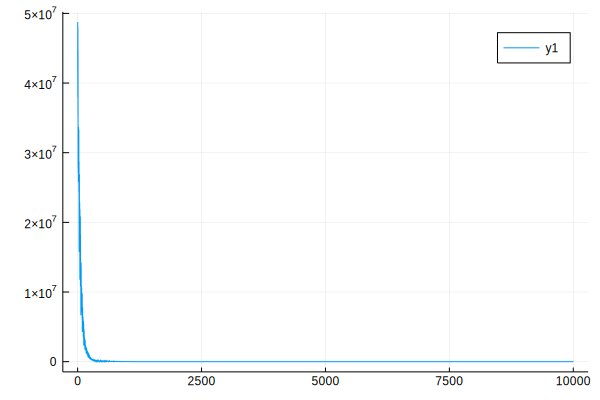

In [129]:
# ADAM
verbose = false
iterMax = 10000

myAdam =  AdamConstStep(0.1, 0.9, 0.99)
accAdam =  Accumulator(ValueAccumulator(),  ParamAccumulator())
samplingStrategy =  RandomSampling(;N = 100, NMax = Nobs(mo_RSG))
state =  AdamState(copy(x0), samplingStrategy)

state, accumulatorAdam = myAdam(mo_RSG, state ; sp =  Geraldine.StopParam(eps_g = eps, NMax = iterMax), accumulator = accAdam, verbose = verbose)

resultAdam = Geraldine.structToDict(accumulatorAdam)

paramAdam = resultAdam[:ParamAccumulator]
fAdam = resultAdam[:ValueAccumulator];

plot(fAdam)

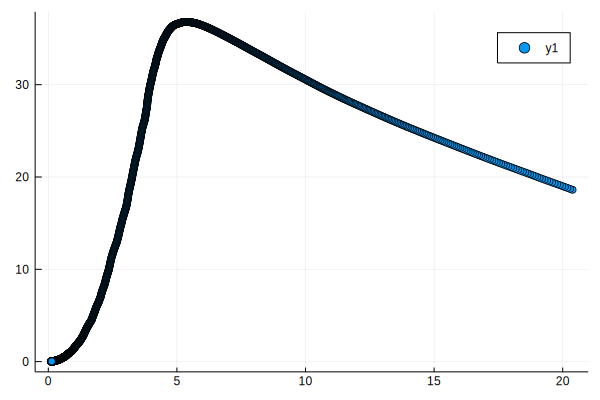

In [147]:
scatter(getindex.(paramAdam, 1), getindex.(paramAdam, 2))

In [159]:
verbose = true
iterMax = 1000

# ---------------- smoothing choice ----------------
# smoothing = Geraldine.NoSmoothing()
smoothing = Geraldine.NaiveSmoothing()
# smoothing = Geraldine.CumulativeDecreaseSmoothing{Float64}(maxIter=5)

varStrategy = Geraldine.TrueVar{Float64}(smoothing)

samplingStrategy = Geraldine.DynamicSampling{Geraldine.IndComRN}(Sofia.Nobs(mo_RSG), varStrategy)


# BTR
accBtr =  Accumulator(ValueAccumulator(), DeltaAccumulator(), FieldAccumulator(:iterCG), ParamAccumulator(), SamplingSize())

btr =  Geraldine.BTRStruct(;Nmax=iterMax, eps_g=eps, sam=typeof(samplingStrategy))

 state, accumulatorBtr = btr(mo_RSG, copy(x0) , samplingStrategy, accumulator = accBtr, verbose = verbose)

 # Collecting results
 resultBTR = Geraldine.structToDict(accumulatorBtr)

samplingBTR = resultBTR[:SamplingSizeAccumulator]
fBTR = resultBTR[:ValueAccumulator]
paramBTR = resultBTR[:ParamAccumulator];

--- Iteration 0 (selected SAM) : 
------ Classic btr ---------- : 
 --- sampling : Geraldine.DynamicSampling{Geraldine.IndComRN,Int64}
-------------------------
initializeState! AbstractStochasticModel -- Classic
initializeSampling Dynamic! Ind / Com RN
-------  updatePreviousValues  True Var --------
-------------------------
Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 1.3412229650040751e7 and ϵ = 1.0e-8
Nmax reached ? 
k = 0  and  max = 1000

Iteration 0 -> 1
computecand! AbstractStochasticModel -- Classic
--- TCG classic 
κ = 1.495655686151394e20
TCG stoped on iteration 1
-------------------------
--------- Classic iter to Do ----------
Nothing done 
-------------------------
updateState! AbstractStochasticModel  -- Classic
 --- updateSampleSize! --- Ind / Common Variables
Current sample size = 100
potentialSampleSize for Dynamic sampling
Naive smoothing -- int = 0.75 / sup = 2.0
New size = 100
New sample size = 100
-------  updatePreviousValues  True Var --------
---------------

κ = 9.450747642315288e8
TCG on border
TCG stoped on iteration 2
-------------------------
step refused region reduced (BAD accuracy)

--------------------------------------------------------------------------------
Iteration 17
31505.641293783323
--------------------------------------------------------------------------------
Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 33774.85572604165 and ϵ = 1.0e-8
Nmax reached ? 
k = 17  and  max = 1000

Iteration 17 -> 18
computecand! AbstractStochasticModel -- Classic
--- TCG classic 
κ = 9.53882772458617e12
κ = 9.450747642315288e8
TCG on border
TCG stoped on iteration 2
-------------------------
step refused region reduced (BAD accuracy)

--------------------------------------------------------------------------------
Iteration 18
31505.641293783323
--------------------------------------------------------------------------------
Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 33774.85572604165 and ϵ = 1.0e-8
Nmax reached ? 
k = 18  and  max = 

New sample size = 107
-------  updatePreviousValues  True Var --------
-------------------------
step accepted, region reduced (good accuracy)

--------------------------------------------------------------------------------
Iteration 31
4.199336750214678
--------------------------------------------------------------------------------
Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 22.852006655428735 and ϵ = 1.0e-8
Nmax reached ? 
k = 31  and  max = 1000

Iteration 31 -> 32
computecand! AbstractStochasticModel -- Classic
--- TCG classic 
κ = 26192.918920703218
κ = 339919.418157029
TCG stoped on iteration 2
-------------------------
step refused region reduced (BAD accuracy)

--------------------------------------------------------------------------------
Iteration 32
4.199336750214678
--------------------------------------------------------------------------------
Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 22.852006655428735 and ϵ = 1.0e-8
Nmax reached ? 
k = 32  and  max = 1000

It

potentialSampleSize for Dynamic sampling
Naive smoothing -- int = 0.75 / sup = 2.0
New size = 7040
- Increase !! with 3520
New sample size = 7040
-------  updatePreviousValues  True Var --------
-------------------------
step accepted, region expanded (VERY good accuracy)

--------------------------------------------------------------------------------
Iteration 41
0.7853801990457612
--------------------------------------------------------------------------------
Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 0.01190376462317188 and ϵ = 1.0e-8
Nmax reached ? 
k = 41  and  max = 1000

Iteration 41 -> 42
computecand! AbstractStochasticModel -- Classic
--- TCG classic 
κ = 0.011235308779251756
κ = 0.01007046973007349
TCG stoped on iteration 2
-------------------------
--------- Classic iter to Do ----------
Nothing done 
-------------------------
updateState! AbstractStochasticModel  -- Classic
 --- updateSampleSize! --- Ind / Common Variables
Current sample size = 7040
potentialSampleSiz

κ = 1.122943359591453e-14
TCG stoped on iteration 2
-------------------------
step refused region reduced (BAD accuracy)

--------------------------------------------------------------------------------
Iteration 50
0.7839772074098571
--------------------------------------------------------------------------------
Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 2.4107408307970253e-7 and ϵ = 1.0e-8
Nmax reached ? 
k = 50  and  max = 1000

Iteration 50 -> 51
computecand! AbstractStochasticModel -- Classic
--- TCG classic 
κ = 1.4029292494651671e-11
κ = 1.122943359591453e-14
TCG stoped on iteration 2
-------------------------
step refused region reduced (BAD accuracy)

--------------------------------------------------------------------------------
Iteration 51
0.7839772074098571
--------------------------------------------------------------------------------
Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 2.4107408307970253e-7 and ϵ = 1.0e-8
Nmax reached ? 
k = 51  and  max = 1000

Iterati


--------------------------------------------------------------------------------
Iteration 66
0.7839772074098571
--------------------------------------------------------------------------------
Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 2.4107408307970253e-7 and ϵ = 1.0e-8
Nmax reached ? 
k = 66  and  max = 1000

Iteration 66 -> 67
computecand! AbstractStochasticModel -- Classic
--- TCG classic 
κ = 1.4029292494651671e-11
κ = 1.122943359591453e-14
TCG stoped on iteration 2
-------------------------
step refused region reduced (BAD accuracy)

--------------------------------------------------------------------------------
Iteration 67
0.7839772074098571
--------------------------------------------------------------------------------
Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 2.4107408307970253e-7 and ϵ = 1.0e-8
Nmax reached ? 
k = 67  and  max = 1000

Iteration 67 -> 68
computecand! AbstractStochasticModel -- Classic
--- TCG classic 
κ = 1.4029292494651671e-11
κ = 1.12294335959

step refused region reduced (BAD accuracy)

--------------------------------------------------------------------------------
Iteration 81
0.7839772074098571
--------------------------------------------------------------------------------
Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 2.4107408307970253e-7 and ϵ = 1.0e-8
Nmax reached ? 
k = 81  and  max = 1000

Iteration 81 -> 82
computecand! AbstractStochasticModel -- Classic
--- TCG classic 
κ = 1.4029292494651671e-11
κ = 1.122943359591453e-14
TCG stoped on iteration 2
-------------------------
step refused region reduced (BAD accuracy)

--------------------------------------------------------------------------------
Iteration 82
0.7839772074098571
--------------------------------------------------------------------------------
Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 2.4107408307970253e-7 and ϵ = 1.0e-8
Nmax reached ? 
k = 82  and  max = 1000

Iteration 82 -> 83
computecand! AbstractStochasticModel -- Classic
--- TCG classic 
κ

TCG stoped on iteration 1
-------------------------
step refused region reduced (BAD accuracy)

--------------------------------------------------------------------------------
Iteration 99
0.7839772074098571
--------------------------------------------------------------------------------
Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 2.4107408307970253e-7 and ϵ = 1.0e-8
Nmax reached ? 
k = 99  and  max = 1000

Iteration 99 -> 100
computecand! AbstractStochasticModel -- Classic
--- TCG classic 
κ = 1.4029292494651671e-11
TCG on border
TCG stoped on iteration 1
-------------------------
step refused region reduced (BAD accuracy)

--------------------------------------------------------------------------------
Iteration 100
0.7839772074098571
--------------------------------------------------------------------------------
Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 2.4107408307970253e-7 and ϵ = 1.0e-8
Nmax reached ? 
k = 100  and  max = 1000

Iteration 100 -> 101
computecand! Abstract

-------------------------
step refused region reduced (BAD accuracy)

--------------------------------------------------------------------------------
Iteration 115
0.7839772074098571
--------------------------------------------------------------------------------
Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 2.4107408307970253e-7 and ϵ = 1.0e-8
Nmax reached ? 
k = 115  and  max = 1000

Iteration 115 -> 116
computecand! AbstractStochasticModel -- Classic
--- TCG classic 
κ = 1.4029292494651671e-11
TCG on border
TCG stoped on iteration 1
-------------------------
step refused region reduced (BAD accuracy)

--------------------------------------------------------------------------------
Iteration 116
0.7839772074098571
--------------------------------------------------------------------------------
Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 2.4107408307970253e-7 and ϵ = 1.0e-8
Nmax reached ? 
k = 116  and  max = 1000

Iteration 116 -> 117
computecand! AbstractStochasticModel -- Clas


Iteration 131 -> 132
computecand! AbstractStochasticModel -- Classic
--- TCG classic 
κ = 1.4029292494651671e-11
TCG on border
TCG stoped on iteration 1
-------------------------
step refused region reduced (BAD accuracy)

--------------------------------------------------------------------------------
Iteration 132
0.7839772074098571
--------------------------------------------------------------------------------
Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 2.4107408307970253e-7 and ϵ = 1.0e-8
Nmax reached ? 
k = 132  and  max = 1000

Iteration 132 -> 133
computecand! AbstractStochasticModel -- Classic
--- TCG classic 
κ = 1.4029292494651671e-11
TCG on border
TCG stoped on iteration 1
-------------------------
step refused region reduced (BAD accuracy)

--------------------------------------------------------------------------------
Iteration 133
0.7839772074098571
--------------------------------------------------------------------------------
Tests arret !!!!
 Test is Grad Optima

TCG stoped on iteration 1
-------------------------
step refused region reduced (BAD accuracy)

--------------------------------------------------------------------------------
Iteration 148
0.7839772074098571
--------------------------------------------------------------------------------
Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 2.4107408307970253e-7 and ϵ = 1.0e-8
Nmax reached ? 
k = 148  and  max = 1000

Iteration 148 -> 149
computecand! AbstractStochasticModel -- Classic
--- TCG classic 
κ = 1.4029292494651671e-11
TCG on border
TCG stoped on iteration 1
-------------------------
step refused region reduced (BAD accuracy)

--------------------------------------------------------------------------------
Iteration 149
0.7839772074098571
--------------------------------------------------------------------------------
Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 2.4107408307970253e-7 and ϵ = 1.0e-8
Nmax reached ? 
k = 149  and  max = 1000

Iteration 149 -> 150
computecand! Abstr

0.7839772074098571
--------------------------------------------------------------------------------
Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 2.4107408307970253e-7 and ϵ = 1.0e-8
Nmax reached ? 
k = 164  and  max = 1000

Iteration 164 -> 165
computecand! AbstractStochasticModel -- Classic
--- TCG classic 
κ = 1.4029292494651671e-11
TCG on border
TCG stoped on iteration 1
-------------------------
step refused region reduced (BAD accuracy)

--------------------------------------------------------------------------------
Iteration 165
0.7839772074098571
--------------------------------------------------------------------------------
Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 2.4107408307970253e-7 and ϵ = 1.0e-8
Nmax reached ? 
k = 165  and  max = 1000

Iteration 165 -> 166
computecand! AbstractStochasticModel -- Classic
--- TCG classic 
κ = 1.4029292494651671e-11
TCG on border
TCG stoped on iteration 1
-------------------------
step refused region reduced (BAD accuracy)

-------

step refused region reduced (BAD accuracy)

--------------------------------------------------------------------------------
Iteration 182
0.7839772074098571
--------------------------------------------------------------------------------
Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 2.4107408307970253e-7 and ϵ = 1.0e-8
Nmax reached ? 
k = 182  and  max = 1000

Iteration 182 -> 183
computecand! AbstractStochasticModel -- Classic
--- TCG classic 
κ = 1.4029292494651671e-11
TCG on border
TCG stoped on iteration 1
-------------------------
step refused region reduced (BAD accuracy)

--------------------------------------------------------------------------------
Iteration 183
0.7839772074098571
--------------------------------------------------------------------------------
Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 2.4107408307970253e-7 and ϵ = 1.0e-8
Nmax reached ? 
k = 183  and  max = 1000

Iteration 183 -> 184
computecand! AbstractStochasticModel -- Classic
--- TCG classic 
κ = 1

computecand! AbstractStochasticModel -- Classic
--- TCG classic 
κ = 1.4029292494651671e-11
TCG on border
TCG stoped on iteration 1
-------------------------
step refused region reduced (BAD accuracy)

--------------------------------------------------------------------------------
Iteration 200
0.7839772074098571
--------------------------------------------------------------------------------
Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 2.4107408307970253e-7 and ϵ = 1.0e-8
Nmax reached ? 
k = 200  and  max = 1000

Iteration 200 -> 201
computecand! AbstractStochasticModel -- Classic
--- TCG classic 
κ = 1.4029292494651671e-11
TCG on border
TCG stoped on iteration 1
-------------------------
step refused region reduced (BAD accuracy)

--------------------------------------------------------------------------------
Iteration 201
0.7839772074098571
--------------------------------------------------------------------------------
Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 2.4107408307

-------------------------
step refused region reduced (BAD accuracy)

--------------------------------------------------------------------------------
Iteration 215
0.7839772074098571
--------------------------------------------------------------------------------
Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 2.4107408307970253e-7 and ϵ = 1.0e-8
Nmax reached ? 
k = 215  and  max = 1000

Iteration 215 -> 216
computecand! AbstractStochasticModel -- Classic
--- TCG classic 
κ = 1.4029292494651671e-11
TCG on border
TCG stoped on iteration 1
-------------------------
step refused region reduced (BAD accuracy)

--------------------------------------------------------------------------------
Iteration 216
0.7839772074098571
--------------------------------------------------------------------------------
Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 2.4107408307970253e-7 and ϵ = 1.0e-8
Nmax reached ? 
k = 216  and  max = 1000

Iteration 216 -> 217
computecand! AbstractStochasticModel -- Clas

--- TCG classic 
κ = 1.4029292494651671e-11
TCG on border
TCG stoped on iteration 1
-------------------------
step refused region reduced (BAD accuracy)

--------------------------------------------------------------------------------
Iteration 231
0.7839772074098571
--------------------------------------------------------------------------------
Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 2.4107408307970253e-7 and ϵ = 1.0e-8
Nmax reached ? 
k = 231  and  max = 1000

Iteration 231 -> 232
computecand! AbstractStochasticModel -- Classic
--- TCG classic 
κ = 1.4029292494651671e-11
TCG on border
TCG stoped on iteration 1
-------------------------
step refused region reduced (BAD accuracy)

--------------------------------------------------------------------------------
Iteration 232
0.7839772074098571
--------------------------------------------------------------------------------
Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 2.4107408307970253e-7 and ϵ = 1.0e-8
Nmax reached ? 
k = 232

κ = 1.4029292494651671e-11
TCG on border
TCG stoped on iteration 1
-------------------------
step refused region reduced (BAD accuracy)

--------------------------------------------------------------------------------
Iteration 246
0.7839772074098571
--------------------------------------------------------------------------------
Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 2.4107408307970253e-7 and ϵ = 1.0e-8
Nmax reached ? 
k = 246  and  max = 1000

Iteration 246 -> 247
computecand! AbstractStochasticModel -- Classic
--- TCG classic 
κ = 1.4029292494651671e-11
TCG on border
TCG stoped on iteration 1
-------------------------
step refused region reduced (BAD accuracy)

--------------------------------------------------------------------------------
Iteration 247
0.7839772074098571
--------------------------------------------------------------------------------
Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 2.4107408307970253e-7 and ϵ = 1.0e-8
Nmax reached ? 
k = 247  and  max = 1000

-------------------------
step refused region reduced (BAD accuracy)

--------------------------------------------------------------------------------
Iteration 262
0.7839772074098571
--------------------------------------------------------------------------------
Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 2.4107408307970253e-7 and ϵ = 1.0e-8
Nmax reached ? 
k = 262  and  max = 1000

Iteration 262 -> 263
computecand! AbstractStochasticModel -- Classic
--- TCG classic 
κ = 1.4029292494651671e-11
TCG on border
TCG stoped on iteration 1
-------------------------
step refused region reduced (BAD accuracy)

--------------------------------------------------------------------------------
Iteration 263
0.7839772074098571
--------------------------------------------------------------------------------
Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 2.4107408307970253e-7 and ϵ = 1.0e-8
Nmax reached ? 
k = 263  and  max = 1000

Iteration 263 -> 264
computecand! AbstractStochasticModel -- Clas

Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 2.4107408307970253e-7 and ϵ = 1.0e-8
Nmax reached ? 
k = 278  and  max = 1000

Iteration 278 -> 279
computecand! AbstractStochasticModel -- Classic
--- TCG classic 
κ = 1.4029292494651671e-11
TCG on border
TCG stoped on iteration 1
-------------------------
step refused region reduced (BAD accuracy)

--------------------------------------------------------------------------------
Iteration 279
0.7839772074098571
--------------------------------------------------------------------------------
Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 2.4107408307970253e-7 and ϵ = 1.0e-8
Nmax reached ? 
k = 279  and  max = 1000

Iteration 279 -> 280
computecand! AbstractStochasticModel -- Classic
--- TCG classic 
κ = 1.4029292494651671e-11
TCG on border
TCG stoped on iteration 1
-------------------------
step refused region reduced (BAD accuracy)

--------------------------------------------------------------------------------
Iteration 280
0.7839772074

TCG stoped on iteration 1
-------------------------
step refused region reduced (BAD accuracy)

--------------------------------------------------------------------------------
Iteration 294
0.7839772074098571
--------------------------------------------------------------------------------
Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 2.4107408307970253e-7 and ϵ = 1.0e-8
Nmax reached ? 
k = 294  and  max = 1000

Iteration 294 -> 295
computecand! AbstractStochasticModel -- Classic
--- TCG classic 
κ = 1.4029292494651671e-11
TCG on border
TCG stoped on iteration 1
-------------------------
step refused region reduced (BAD accuracy)

--------------------------------------------------------------------------------
Iteration 295
0.7839772074098571
--------------------------------------------------------------------------------
Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 2.4107408307970253e-7 and ϵ = 1.0e-8
Nmax reached ? 
k = 295  and  max = 1000

Iteration 295 -> 296
computecand! Abstr

TCG stoped on iteration 1
-------------------------
step refused region reduced (BAD accuracy)

--------------------------------------------------------------------------------
Iteration 311
0.7839772074098571
--------------------------------------------------------------------------------
Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 2.4107408307970253e-7 and ϵ = 1.0e-8
Nmax reached ? 
k = 311  and  max = 1000

Iteration 311 -> 312
computecand! AbstractStochasticModel -- Classic
--- TCG classic 
κ = 1.4029292494651671e-11
TCG on border
TCG stoped on iteration 1
-------------------------
step refused region reduced (BAD accuracy)

--------------------------------------------------------------------------------
Iteration 312
0.7839772074098571
--------------------------------------------------------------------------------
Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 2.4107408307970253e-7 and ϵ = 1.0e-8
Nmax reached ? 
k = 312  and  max = 1000

Iteration 312 -> 313
computecand! Abstr

TCG stoped on iteration 1
-------------------------
step refused region reduced (BAD accuracy)

--------------------------------------------------------------------------------
Iteration 329
0.7839772074098571
--------------------------------------------------------------------------------
Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 2.4107408307970253e-7 and ϵ = 1.0e-8
Nmax reached ? 
k = 329  and  max = 1000

Iteration 329 -> 330
computecand! AbstractStochasticModel -- Classic
--- TCG classic 
κ = 1.4029292494651671e-11
TCG on border
TCG stoped on iteration 1
-------------------------
step refused region reduced (BAD accuracy)

--------------------------------------------------------------------------------
Iteration 330
0.7839772074098571
--------------------------------------------------------------------------------
Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 2.4107408307970253e-7 and ϵ = 1.0e-8
Nmax reached ? 
k = 330  and  max = 1000

Iteration 330 -> 331
computecand! Abstr

--- TCG classic 
κ = 1.4029292494651671e-11
TCG on border
TCG stoped on iteration 1
-------------------------
step refused region reduced (BAD accuracy)

--------------------------------------------------------------------------------
Iteration 345
0.7839772074098571
--------------------------------------------------------------------------------
Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 2.4107408307970253e-7 and ϵ = 1.0e-8
Nmax reached ? 
k = 345  and  max = 1000

Iteration 345 -> 346
computecand! AbstractStochasticModel -- Classic
--- TCG classic 
κ = 1.4029292494651671e-11
TCG on border
TCG stoped on iteration 1
-------------------------
step refused region reduced (BAD accuracy)

--------------------------------------------------------------------------------
Iteration 346
0.7839772074098571
--------------------------------------------------------------------------------
Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 2.4107408307970253e-7 and ϵ = 1.0e-8
Nmax reached ? 
k = 346

--- TCG classic 
κ = 1.4029292494651671e-11
TCG on border
TCG stoped on iteration 1
-------------------------
step refused region reduced (BAD accuracy)

--------------------------------------------------------------------------------
Iteration 361
0.7839772074098571
--------------------------------------------------------------------------------
Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 2.4107408307970253e-7 and ϵ = 1.0e-8
Nmax reached ? 
k = 361  and  max = 1000

Iteration 361 -> 362
computecand! AbstractStochasticModel -- Classic
--- TCG classic 
κ = 1.4029292494651671e-11
TCG on border
TCG stoped on iteration 1
-------------------------
step refused region reduced (BAD accuracy)

--------------------------------------------------------------------------------
Iteration 362
0.7839772074098571
--------------------------------------------------------------------------------
Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 2.4107408307970253e-7 and ϵ = 1.0e-8
Nmax reached ? 
k = 362

TCG stoped on iteration 1
-------------------------
step refused region reduced (BAD accuracy)

--------------------------------------------------------------------------------
Iteration 378
0.7839772074098571
--------------------------------------------------------------------------------
Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 2.4107408307970253e-7 and ϵ = 1.0e-8
Nmax reached ? 
k = 378  and  max = 1000

Iteration 378 -> 379
computecand! AbstractStochasticModel -- Classic
--- TCG classic 
κ = 1.4029292494651671e-11
TCG on border
TCG stoped on iteration 1
-------------------------
step refused region reduced (BAD accuracy)

--------------------------------------------------------------------------------
Iteration 379
0.7839772074098571
--------------------------------------------------------------------------------
Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 2.4107408307970253e-7 and ϵ = 1.0e-8
Nmax reached ? 
k = 379  and  max = 1000

Iteration 379 -> 380
computecand! Abstr

Iteration 394
0.7839772074098571
--------------------------------------------------------------------------------
Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 2.4107408307970253e-7 and ϵ = 1.0e-8
Nmax reached ? 
k = 394  and  max = 1000

Iteration 394 -> 395
computecand! AbstractStochasticModel -- Classic
--- TCG classic 
κ = 1.4029292494651671e-11
TCG on border
TCG stoped on iteration 1
-------------------------
step refused region reduced (BAD accuracy)

--------------------------------------------------------------------------------
Iteration 395
0.7839772074098571
--------------------------------------------------------------------------------
Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 2.4107408307970253e-7 and ϵ = 1.0e-8
Nmax reached ? 
k = 395  and  max = 1000

Iteration 395 -> 396
computecand! AbstractStochasticModel -- Classic
--- TCG classic 
κ = 1.4029292494651671e-11
TCG on border
TCG stoped on iteration 1
-------------------------
step refused region reduced (BAD accu

TCG stoped on iteration 1
-------------------------
step refused region reduced (BAD accuracy)

--------------------------------------------------------------------------------
Iteration 411
0.7839772074098571
--------------------------------------------------------------------------------
Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 2.4107408307970253e-7 and ϵ = 1.0e-8
Nmax reached ? 
k = 411  and  max = 1000

Iteration 411 -> 412
computecand! AbstractStochasticModel -- Classic
--- TCG classic 
κ = 1.4029292494651671e-11
TCG on border
TCG stoped on iteration 1
-------------------------
step refused region reduced (BAD accuracy)

--------------------------------------------------------------------------------
Iteration 412
0.7839772074098571
--------------------------------------------------------------------------------
Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 2.4107408307970253e-7 and ϵ = 1.0e-8
Nmax reached ? 
k = 412  and  max = 1000

Iteration 412 -> 413
computecand! Abstr

computecand! AbstractStochasticModel -- Classic
--- TCG classic 
κ = 1.4029292494651671e-11
TCG on border
TCG stoped on iteration 1
-------------------------
step refused region reduced (BAD accuracy)

--------------------------------------------------------------------------------
Iteration 428
0.7839772074098571
--------------------------------------------------------------------------------
Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 2.4107408307970253e-7 and ϵ = 1.0e-8
Nmax reached ? 
k = 428  and  max = 1000

Iteration 428 -> 429
computecand! AbstractStochasticModel -- Classic
--- TCG classic 
κ = 1.4029292494651671e-11
TCG on border
TCG stoped on iteration 1
-------------------------
step refused region reduced (BAD accuracy)

--------------------------------------------------------------------------------
Iteration 429
0.7839772074098571
--------------------------------------------------------------------------------
Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 2.4107408307

--------------------------------------------------------------------------------
Iteration 443
0.7839772074098571
--------------------------------------------------------------------------------
Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 2.4107408307970253e-7 and ϵ = 1.0e-8
Nmax reached ? 
k = 443  and  max = 1000

Iteration 443 -> 444
computecand! AbstractStochasticModel -- Classic
--- TCG classic 
κ = 1.4029292494651671e-11
TCG on border
TCG stoped on iteration 1
-------------------------
step refused region reduced (BAD accuracy)

--------------------------------------------------------------------------------
Iteration 444
0.7839772074098571
--------------------------------------------------------------------------------
Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 2.4107408307970253e-7 and ϵ = 1.0e-8
Nmax reached ? 
k = 444  and  max = 1000

Iteration 444 -> 445
computecand! AbstractStochasticModel -- Classic
--- TCG classic 
κ = 1.4029292494651671e-11
TCG on border
TCG stop

TCG stoped on iteration 1
-------------------------
step refused region reduced (BAD accuracy)

--------------------------------------------------------------------------------
Iteration 459
0.7839772074098571
--------------------------------------------------------------------------------
Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 2.4107408307970253e-7 and ϵ = 1.0e-8
Nmax reached ? 
k = 459  and  max = 1000

Iteration 459 -> 460
computecand! AbstractStochasticModel -- Classic
--- TCG classic 
κ = 1.4029292494651671e-11
TCG on border
TCG stoped on iteration 1
-------------------------
step refused region reduced (BAD accuracy)

--------------------------------------------------------------------------------
Iteration 460
0.7839772074098571
--------------------------------------------------------------------------------
Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 2.4107408307970253e-7 and ϵ = 1.0e-8
Nmax reached ? 
k = 460  and  max = 1000

Iteration 460 -> 461
computecand! Abstr

Iteration 474
0.7839772074098571
--------------------------------------------------------------------------------
Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 2.4107408307970253e-7 and ϵ = 1.0e-8
Nmax reached ? 
k = 474  and  max = 1000

Iteration 474 -> 475
computecand! AbstractStochasticModel -- Classic
--- TCG classic 
κ = 1.4029292494651671e-11
TCG on border
TCG stoped on iteration 1
-------------------------
step refused region reduced (BAD accuracy)

--------------------------------------------------------------------------------
Iteration 475
0.7839772074098571
--------------------------------------------------------------------------------
Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 2.4107408307970253e-7 and ϵ = 1.0e-8
Nmax reached ? 
k = 475  and  max = 1000

Iteration 475 -> 476
computecand! AbstractStochasticModel -- Classic
--- TCG classic 
κ = 1.4029292494651671e-11
TCG on border
TCG stoped on iteration 1
-------------------------
step refused region reduced (BAD accu

Iteration 490
0.7839772074098571
--------------------------------------------------------------------------------
Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 2.4107408307970253e-7 and ϵ = 1.0e-8
Nmax reached ? 
k = 490  and  max = 1000

Iteration 490 -> 491
computecand! AbstractStochasticModel -- Classic
--- TCG classic 
κ = 1.4029292494651671e-11
TCG on border
TCG stoped on iteration 1
-------------------------
step refused region reduced (BAD accuracy)

--------------------------------------------------------------------------------
Iteration 491
0.7839772074098571
--------------------------------------------------------------------------------
Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 2.4107408307970253e-7 and ϵ = 1.0e-8
Nmax reached ? 
k = 491  and  max = 1000

Iteration 491 -> 492
computecand! AbstractStochasticModel -- Classic
--- TCG classic 
κ = 1.4029292494651671e-11
TCG on border
TCG stoped on iteration 1
-------------------------
step refused region reduced (BAD accu

--- TCG classic 
κ = 1.4029292494651671e-11
TCG on border
TCG stoped on iteration 1
-------------------------
step refused region reduced (BAD accuracy)

--------------------------------------------------------------------------------
Iteration 508
0.7839772074098571
--------------------------------------------------------------------------------
Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 2.4107408307970253e-7 and ϵ = 1.0e-8
Nmax reached ? 
k = 508  and  max = 1000

Iteration 508 -> 509
computecand! AbstractStochasticModel -- Classic
--- TCG classic 
κ = 1.4029292494651671e-11
TCG on border
TCG stoped on iteration 1
-------------------------
step refused region reduced (BAD accuracy)

--------------------------------------------------------------------------------
Iteration 509
0.7839772074098571
--------------------------------------------------------------------------------
Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 2.4107408307970253e-7 and ϵ = 1.0e-8
Nmax reached ? 
k = 509

0.7839772074098571
--------------------------------------------------------------------------------
Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 2.4107408307970253e-7 and ϵ = 1.0e-8
Nmax reached ? 
k = 523  and  max = 1000

Iteration 523 -> 524
computecand! AbstractStochasticModel -- Classic
--- TCG classic 
κ = 1.4029292494651671e-11
TCG on border
TCG stoped on iteration 1
-------------------------
step refused region reduced (BAD accuracy)

--------------------------------------------------------------------------------
Iteration 524
0.7839772074098571
--------------------------------------------------------------------------------
Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 2.4107408307970253e-7 and ϵ = 1.0e-8
Nmax reached ? 
k = 524  and  max = 1000

Iteration 524 -> 525
computecand! AbstractStochasticModel -- Classic
--- TCG classic 
κ = 1.4029292494651671e-11
TCG on border
TCG stoped on iteration 1
-------------------------
step refused region reduced (BAD accuracy)

-------

-------------------------
step refused region reduced (BAD accuracy)

--------------------------------------------------------------------------------
Iteration 539
0.7839772074098571
--------------------------------------------------------------------------------
Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 2.4107408307970253e-7 and ϵ = 1.0e-8
Nmax reached ? 
k = 539  and  max = 1000

Iteration 539 -> 540
computecand! AbstractStochasticModel -- Classic
--- TCG classic 
κ = 1.4029292494651671e-11
TCG on border
TCG stoped on iteration 1
-------------------------
step refused region reduced (BAD accuracy)

--------------------------------------------------------------------------------
Iteration 540
0.7839772074098571
--------------------------------------------------------------------------------
Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 2.4107408307970253e-7 and ϵ = 1.0e-8
Nmax reached ? 
k = 540  and  max = 1000

Iteration 540 -> 541
computecand! AbstractStochasticModel -- Clas

--------------------------------------------------------------------------------
Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 2.4107408307970253e-7 and ϵ = 1.0e-8
Nmax reached ? 
k = 554  and  max = 1000

Iteration 554 -> 555
computecand! AbstractStochasticModel -- Classic
--- TCG classic 
κ = 1.4029292494651671e-11
TCG on border
TCG stoped on iteration 1
-------------------------
step refused region reduced (BAD accuracy)

--------------------------------------------------------------------------------
Iteration 555
0.7839772074098571
--------------------------------------------------------------------------------
Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 2.4107408307970253e-7 and ϵ = 1.0e-8
Nmax reached ? 
k = 555  and  max = 1000

Iteration 555 -> 556
computecand! AbstractStochasticModel -- Classic
--- TCG classic 
κ = 1.4029292494651671e-11
TCG on border
TCG stoped on iteration 1
-------------------------
step refused region reduced (BAD accuracy)

--------------------------

-------------------------
step refused region reduced (BAD accuracy)

--------------------------------------------------------------------------------
Iteration 571
0.7839772074098571
--------------------------------------------------------------------------------
Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 2.4107408307970253e-7 and ϵ = 1.0e-8
Nmax reached ? 
k = 571  and  max = 1000

Iteration 571 -> 572
computecand! AbstractStochasticModel -- Classic
--- TCG classic 
κ = 1.4029292494651671e-11
TCG on border
TCG stoped on iteration 1
-------------------------
step refused region reduced (BAD accuracy)

--------------------------------------------------------------------------------
Iteration 572
0.7839772074098571
--------------------------------------------------------------------------------
Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 2.4107408307970253e-7 and ϵ = 1.0e-8
Nmax reached ? 
k = 572  and  max = 1000

Iteration 572 -> 573
computecand! AbstractStochasticModel -- Clas

 Test is Grad Optimal ? ‖g‖ = 2.4107408307970253e-7 and ϵ = 1.0e-8
Nmax reached ? 
k = 586  and  max = 1000

Iteration 586 -> 587
computecand! AbstractStochasticModel -- Classic
--- TCG classic 
κ = 1.4029292494651671e-11
TCG on border
TCG stoped on iteration 1
-------------------------
step refused region reduced (BAD accuracy)

--------------------------------------------------------------------------------
Iteration 587
0.7839772074098571
--------------------------------------------------------------------------------
Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 2.4107408307970253e-7 and ϵ = 1.0e-8
Nmax reached ? 
k = 587  and  max = 1000

Iteration 587 -> 588
computecand! AbstractStochasticModel -- Classic
--- TCG classic 
κ = 1.4029292494651671e-11
TCG on border
TCG stoped on iteration 1
-------------------------
step refused region reduced (BAD accuracy)

--------------------------------------------------------------------------------
Iteration 588
0.7839772074098571
----------

Iteration 604
0.7839772074098571
--------------------------------------------------------------------------------
Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 2.4107408307970253e-7 and ϵ = 1.0e-8
Nmax reached ? 
k = 604  and  max = 1000

Iteration 604 -> 605
computecand! AbstractStochasticModel -- Classic
--- TCG classic 
κ = 1.4029292494651671e-11
TCG on border
TCG stoped on iteration 1
-------------------------
step refused region reduced (BAD accuracy)

--------------------------------------------------------------------------------
Iteration 605
0.7839772074098571
--------------------------------------------------------------------------------
Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 2.4107408307970253e-7 and ϵ = 1.0e-8
Nmax reached ? 
k = 605  and  max = 1000

Iteration 605 -> 606
computecand! AbstractStochasticModel -- Classic
--- TCG classic 
κ = 1.4029292494651671e-11
TCG on border
TCG stoped on iteration 1
-------------------------
step refused region reduced (BAD accu

k = 620  and  max = 1000

Iteration 620 -> 621
computecand! AbstractStochasticModel -- Classic
--- TCG classic 
κ = 1.4029292494651671e-11
TCG on border
TCG stoped on iteration 1
-------------------------
step refused region reduced (BAD accuracy)

--------------------------------------------------------------------------------
Iteration 621
0.7839772074098571
--------------------------------------------------------------------------------
Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 2.4107408307970253e-7 and ϵ = 1.0e-8
Nmax reached ? 
k = 621  and  max = 1000

Iteration 621 -> 622
computecand! AbstractStochasticModel -- Classic
--- TCG classic 
κ = 1.4029292494651671e-11
TCG on border
TCG stoped on iteration 1
-------------------------
step refused region reduced (BAD accuracy)

--------------------------------------------------------------------------------
Iteration 622
0.7839772074098571
--------------------------------------------------------------------------------
Tests arret 

Iteration 637
0.7839772074098571
--------------------------------------------------------------------------------
Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 2.4107408307970253e-7 and ϵ = 1.0e-8
Nmax reached ? 
k = 637  and  max = 1000

Iteration 637 -> 638
computecand! AbstractStochasticModel -- Classic
--- TCG classic 
κ = 1.4029292494651671e-11
TCG on border
TCG stoped on iteration 1
-------------------------
step refused region reduced (BAD accuracy)

--------------------------------------------------------------------------------
Iteration 638
0.7839772074098571
--------------------------------------------------------------------------------
Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 2.4107408307970253e-7 and ϵ = 1.0e-8
Nmax reached ? 
k = 638  and  max = 1000

Iteration 638 -> 639
computecand! AbstractStochasticModel -- Classic
--- TCG classic 
κ = 1.4029292494651671e-11
TCG on border
TCG stoped on iteration 1
-------------------------
step refused region reduced (BAD accu

TCG stoped on iteration 1
-------------------------
step refused region reduced (BAD accuracy)

--------------------------------------------------------------------------------
Iteration 654
0.7839772074098571
--------------------------------------------------------------------------------
Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 2.4107408307970253e-7 and ϵ = 1.0e-8
Nmax reached ? 
k = 654  and  max = 1000

Iteration 654 -> 655
computecand! AbstractStochasticModel -- Classic
--- TCG classic 
κ = 1.4029292494651671e-11
TCG on border
TCG stoped on iteration 1
-------------------------
step refused region reduced (BAD accuracy)

--------------------------------------------------------------------------------
Iteration 655
0.7839772074098571
--------------------------------------------------------------------------------
Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 2.4107408307970253e-7 and ϵ = 1.0e-8
Nmax reached ? 
k = 655  and  max = 1000

Iteration 655 -> 656
computecand! Abstr

step refused region reduced (BAD accuracy)

--------------------------------------------------------------------------------
Iteration 670
0.7839772074098571
--------------------------------------------------------------------------------
Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 2.4107408307970253e-7 and ϵ = 1.0e-8
Nmax reached ? 
k = 670  and  max = 1000

Iteration 670 -> 671
computecand! AbstractStochasticModel -- Classic
--- TCG classic 
κ = 1.4029292494651671e-11
TCG on border
TCG stoped on iteration 1
-------------------------
step refused region reduced (BAD accuracy)

--------------------------------------------------------------------------------
Iteration 671
0.7839772074098571
--------------------------------------------------------------------------------
Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 2.4107408307970253e-7 and ϵ = 1.0e-8
Nmax reached ? 
k = 671  and  max = 1000

Iteration 671 -> 672
computecand! AbstractStochasticModel -- Classic
--- TCG classic 
κ = 1

TCG on border
TCG stoped on iteration 1
-------------------------
step refused region reduced (BAD accuracy)

--------------------------------------------------------------------------------
Iteration 687
0.7839772074098571
--------------------------------------------------------------------------------
Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 2.4107408307970253e-7 and ϵ = 1.0e-8
Nmax reached ? 
k = 687  and  max = 1000

Iteration 687 -> 688
computecand! AbstractStochasticModel -- Classic
--- TCG classic 
κ = 1.4029292494651671e-11
TCG on border
TCG stoped on iteration 1
-------------------------
step refused region reduced (BAD accuracy)

--------------------------------------------------------------------------------
Iteration 688
0.7839772074098571
--------------------------------------------------------------------------------
Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 2.4107408307970253e-7 and ϵ = 1.0e-8
Nmax reached ? 
k = 688  and  max = 1000

Iteration 688 -> 689
comp

--- TCG classic 
κ = 1.4029292494651671e-11
TCG on border
TCG stoped on iteration 1
-------------------------
step refused region reduced (BAD accuracy)

--------------------------------------------------------------------------------
Iteration 703
0.7839772074098571
--------------------------------------------------------------------------------
Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 2.4107408307970253e-7 and ϵ = 1.0e-8
Nmax reached ? 
k = 703  and  max = 1000

Iteration 703 -> 704
computecand! AbstractStochasticModel -- Classic
--- TCG classic 
κ = 1.4029292494651671e-11
TCG on border
TCG stoped on iteration 1
-------------------------
step refused region reduced (BAD accuracy)

--------------------------------------------------------------------------------
Iteration 704
0.7839772074098571
--------------------------------------------------------------------------------
Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 2.4107408307970253e-7 and ϵ = 1.0e-8
Nmax reached ? 
k = 704

Iteration 720
0.7839772074098571
--------------------------------------------------------------------------------
Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 2.4107408307970253e-7 and ϵ = 1.0e-8
Nmax reached ? 
k = 720  and  max = 1000

Iteration 720 -> 721
computecand! AbstractStochasticModel -- Classic
--- TCG classic 
κ = 1.4029292494651671e-11
TCG on border
TCG stoped on iteration 1
-------------------------
step refused region reduced (BAD accuracy)

--------------------------------------------------------------------------------
Iteration 721
0.7839772074098571
--------------------------------------------------------------------------------
Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 2.4107408307970253e-7 and ϵ = 1.0e-8
Nmax reached ? 
k = 721  and  max = 1000

Iteration 721 -> 722
computecand! AbstractStochasticModel -- Classic
--- TCG classic 
κ = 1.4029292494651671e-11
TCG on border
TCG stoped on iteration 1
-------------------------
step refused region reduced (BAD accu

-------------------------
step refused region reduced (BAD accuracy)

--------------------------------------------------------------------------------
Iteration 738
0.7839772074098571
--------------------------------------------------------------------------------
Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 2.4107408307970253e-7 and ϵ = 1.0e-8
Nmax reached ? 
k = 738  and  max = 1000

Iteration 738 -> 739
computecand! AbstractStochasticModel -- Classic
--- TCG classic 
κ = 1.4029292494651671e-11
TCG on border
TCG stoped on iteration 1
-------------------------
step refused region reduced (BAD accuracy)

--------------------------------------------------------------------------------
Iteration 739
0.7839772074098571
--------------------------------------------------------------------------------
Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 2.4107408307970253e-7 and ϵ = 1.0e-8
Nmax reached ? 
k = 739  and  max = 1000

Iteration 739 -> 740
computecand! AbstractStochasticModel -- Clas

κ = 1.4029292494651671e-11
TCG on border
TCG stoped on iteration 1
-------------------------
step refused region reduced (BAD accuracy)

--------------------------------------------------------------------------------
Iteration 754
0.7839772074098571
--------------------------------------------------------------------------------
Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 2.4107408307970253e-7 and ϵ = 1.0e-8
Nmax reached ? 
k = 754  and  max = 1000

Iteration 754 -> 755
computecand! AbstractStochasticModel -- Classic
--- TCG classic 
κ = 1.4029292494651671e-11
TCG on border
TCG stoped on iteration 1
-------------------------
step refused region reduced (BAD accuracy)

--------------------------------------------------------------------------------
Iteration 755
0.7839772074098571
--------------------------------------------------------------------------------
Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 2.4107408307970253e-7 and ϵ = 1.0e-8
Nmax reached ? 
k = 755  and  max = 1000

-------------------------
step refused region reduced (BAD accuracy)

--------------------------------------------------------------------------------
Iteration 770
0.7839772074098571
--------------------------------------------------------------------------------
Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 2.4107408307970253e-7 and ϵ = 1.0e-8
Nmax reached ? 
k = 770  and  max = 1000

Iteration 770 -> 771
computecand! AbstractStochasticModel -- Classic
--- TCG classic 
κ = 1.4029292494651671e-11
TCG on border
TCG stoped on iteration 1
-------------------------
step refused region reduced (BAD accuracy)

--------------------------------------------------------------------------------
Iteration 771
0.7839772074098571
--------------------------------------------------------------------------------
Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 2.4107408307970253e-7 and ϵ = 1.0e-8
Nmax reached ? 
k = 771  and  max = 1000

Iteration 771 -> 772
computecand! AbstractStochasticModel -- Clas

step refused region reduced (BAD accuracy)

--------------------------------------------------------------------------------
Iteration 787
0.7839772074098571
--------------------------------------------------------------------------------
Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 2.4107408307970253e-7 and ϵ = 1.0e-8
Nmax reached ? 
k = 787  and  max = 1000

Iteration 787 -> 788
computecand! AbstractStochasticModel -- Classic
--- TCG classic 
κ = 1.4029292494651671e-11
TCG on border
TCG stoped on iteration 1
-------------------------
step refused region reduced (BAD accuracy)

--------------------------------------------------------------------------------
Iteration 788
0.7839772074098571
--------------------------------------------------------------------------------
Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 2.4107408307970253e-7 and ϵ = 1.0e-8
Nmax reached ? 
k = 788  and  max = 1000

Iteration 788 -> 789
computecand! AbstractStochasticModel -- Classic
--- TCG classic 
κ = 1

Iteration 803 -> 804
computecand! AbstractStochasticModel -- Classic
--- TCG classic 
κ = 1.4029292494651671e-11
TCG on border
TCG stoped on iteration 1
-------------------------
step refused region reduced (BAD accuracy)

--------------------------------------------------------------------------------
Iteration 804
0.7839772074098571
--------------------------------------------------------------------------------
Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 2.4107408307970253e-7 and ϵ = 1.0e-8
Nmax reached ? 
k = 804  and  max = 1000

Iteration 804 -> 805
computecand! AbstractStochasticModel -- Classic
--- TCG classic 
κ = 1.4029292494651671e-11
TCG on border
TCG stoped on iteration 1
-------------------------
step refused region reduced (BAD accuracy)

--------------------------------------------------------------------------------
Iteration 805
0.7839772074098571
--------------------------------------------------------------------------------
Tests arret !!!!
 Test is Grad Optimal

TCG stoped on iteration 1
-------------------------
step refused region reduced (BAD accuracy)

--------------------------------------------------------------------------------
Iteration 820
0.7839772074098571
--------------------------------------------------------------------------------
Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 2.4107408307970253e-7 and ϵ = 1.0e-8
Nmax reached ? 
k = 820  and  max = 1000

Iteration 820 -> 821
computecand! AbstractStochasticModel -- Classic
--- TCG classic 
κ = 1.4029292494651671e-11
TCG on border
TCG stoped on iteration 1
-------------------------
step refused region reduced (BAD accuracy)

--------------------------------------------------------------------------------
Iteration 821
0.7839772074098571
--------------------------------------------------------------------------------
Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 2.4107408307970253e-7 and ϵ = 1.0e-8
Nmax reached ? 
k = 821  and  max = 1000

Iteration 821 -> 822
computecand! Abstr

Iteration 836
0.7839772074098571
--------------------------------------------------------------------------------
Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 2.4107408307970253e-7 and ϵ = 1.0e-8
Nmax reached ? 
k = 836  and  max = 1000

Iteration 836 -> 837
computecand! AbstractStochasticModel -- Classic
--- TCG classic 
κ = 1.4029292494651671e-11
TCG on border
TCG stoped on iteration 1
-------------------------
step refused region reduced (BAD accuracy)

--------------------------------------------------------------------------------
Iteration 837
0.7839772074098571
--------------------------------------------------------------------------------
Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 2.4107408307970253e-7 and ϵ = 1.0e-8
Nmax reached ? 
k = 837  and  max = 1000

Iteration 837 -> 838
computecand! AbstractStochasticModel -- Classic
--- TCG classic 
κ = 1.4029292494651671e-11
TCG on border
TCG stoped on iteration 1
-------------------------
step refused region reduced (BAD accu

Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 2.4107408307970253e-7 and ϵ = 1.0e-8
Nmax reached ? 
k = 852  and  max = 1000

Iteration 852 -> 853
computecand! AbstractStochasticModel -- Classic
--- TCG classic 
κ = 1.4029292494651671e-11
TCG on border
TCG stoped on iteration 1
-------------------------
step refused region reduced (BAD accuracy)

--------------------------------------------------------------------------------
Iteration 853
0.7839772074098571
--------------------------------------------------------------------------------
Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 2.4107408307970253e-7 and ϵ = 1.0e-8
Nmax reached ? 
k = 853  and  max = 1000

Iteration 853 -> 854
computecand! AbstractStochasticModel -- Classic
--- TCG classic 
κ = 1.4029292494651671e-11
TCG on border
TCG stoped on iteration 1
-------------------------
step refused region reduced (BAD accuracy)

--------------------------------------------------------------------------------
Iteration 854
0.7839772074

-------------------------
step refused region reduced (BAD accuracy)

--------------------------------------------------------------------------------
Iteration 868
0.7839772074098571
--------------------------------------------------------------------------------
Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 2.4107408307970253e-7 and ϵ = 1.0e-8
Nmax reached ? 
k = 868  and  max = 1000

Iteration 868 -> 869
computecand! AbstractStochasticModel -- Classic
--- TCG classic 
κ = 1.4029292494651671e-11
TCG on border
TCG stoped on iteration 1
-------------------------
step refused region reduced (BAD accuracy)

--------------------------------------------------------------------------------
Iteration 869
0.7839772074098571
--------------------------------------------------------------------------------
Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 2.4107408307970253e-7 and ϵ = 1.0e-8
Nmax reached ? 
k = 869  and  max = 1000

Iteration 869 -> 870
computecand! AbstractStochasticModel -- Clas

TCG stoped on iteration 1
-------------------------
step refused region reduced (BAD accuracy)

--------------------------------------------------------------------------------
Iteration 884
0.7839772074098571
--------------------------------------------------------------------------------
Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 2.4107408307970253e-7 and ϵ = 1.0e-8
Nmax reached ? 
k = 884  and  max = 1000

Iteration 884 -> 885
computecand! AbstractStochasticModel -- Classic
--- TCG classic 
κ = 1.4029292494651671e-11
TCG on border
TCG stoped on iteration 1
-------------------------
step refused region reduced (BAD accuracy)

--------------------------------------------------------------------------------
Iteration 885
0.7839772074098571
--------------------------------------------------------------------------------
Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 2.4107408307970253e-7 and ϵ = 1.0e-8
Nmax reached ? 
k = 885  and  max = 1000

Iteration 885 -> 886
computecand! Abstr

--------------------------------------------------------------------------------
Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 2.4107408307970253e-7 and ϵ = 1.0e-8
Nmax reached ? 
k = 900  and  max = 1000

Iteration 900 -> 901
computecand! AbstractStochasticModel -- Classic
--- TCG classic 
κ = 1.4029292494651671e-11
TCG on border
TCG stoped on iteration 1
-------------------------
step refused region reduced (BAD accuracy)

--------------------------------------------------------------------------------
Iteration 901
0.7839772074098571
--------------------------------------------------------------------------------
Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 2.4107408307970253e-7 and ϵ = 1.0e-8
Nmax reached ? 
k = 901  and  max = 1000

Iteration 901 -> 902
computecand! AbstractStochasticModel -- Classic
--- TCG classic 
κ = 1.4029292494651671e-11
TCG on border
TCG stoped on iteration 1
-------------------------
step refused region reduced (BAD accuracy)

--------------------------

TCG stoped on iteration 1
-------------------------
step refused region reduced (BAD accuracy)

--------------------------------------------------------------------------------
Iteration 916
0.7839772074098571
--------------------------------------------------------------------------------
Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 2.4107408307970253e-7 and ϵ = 1.0e-8
Nmax reached ? 
k = 916  and  max = 1000

Iteration 916 -> 917
computecand! AbstractStochasticModel -- Classic
--- TCG classic 
κ = 1.4029292494651671e-11
TCG on border
TCG stoped on iteration 1
-------------------------
step refused region reduced (BAD accuracy)

--------------------------------------------------------------------------------
Iteration 917
0.7839772074098571
--------------------------------------------------------------------------------
Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 2.4107408307970253e-7 and ϵ = 1.0e-8
Nmax reached ? 
k = 917  and  max = 1000

Iteration 917 -> 918
computecand! Abstr

Excessive output truncated after 524299 bytes.


-------------------------
step refused region reduced (BAD accuracy)

--------------------------------------------------------------------------------
Iteration 930
0.7839772074098571
--------------------------------------------------------------------------------
Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 2.4107408307970253e-7 and ϵ = 1.0e-8
Nmax reached ? 
k = 930  and  max = 1000

Iteration 930 -> 931
computecand! AbstractStochasticModel -- Classic
--- TCG classic 
κ = 1.4029292494651671e-11
TCG on border
TCG stoped on iteration 1
-------------------------
step refused region reduced (BAD accuracy)

--------------------------------------------------------------------------------
Iteration 931
0.7839772074098571
--------------------------------------------------------------------------------
Tests arret !!!!
 Test is Grad Optimal ? ‖g‖ = 2.4107408307970253e-7 and ϵ = 1.0e-8
Nmax reached ? 
k = 931  and  max = 1000

Iteration 931 -> 932
computecand! AbstractStochasticModel -- Cla

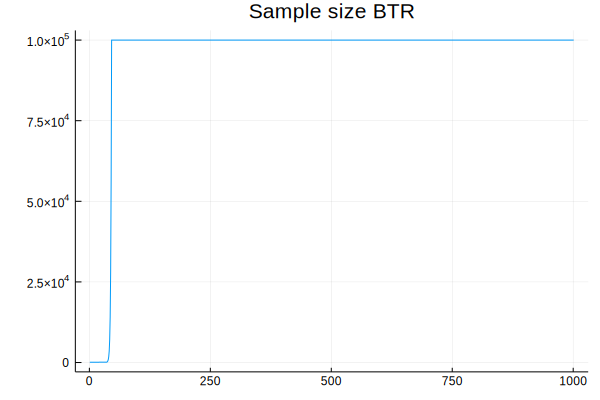

In [160]:
plot(samplingBTR[1], legend=false, title="Sample size BTR")

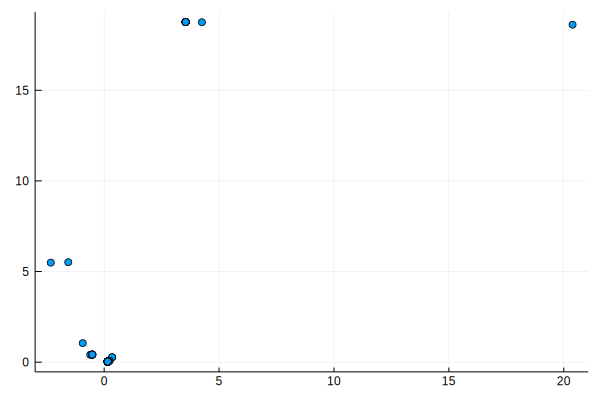

In [161]:
scatter(getindex.(paramBTR, 1), getindex.(paramBTR, 2), legend=false)

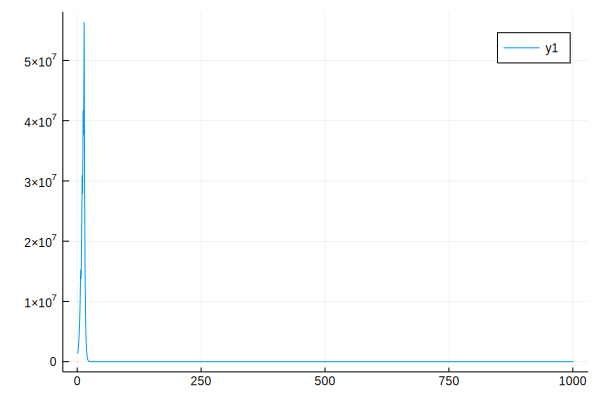

In [132]:
plot(resultBTR[:DeltaAccumulator])

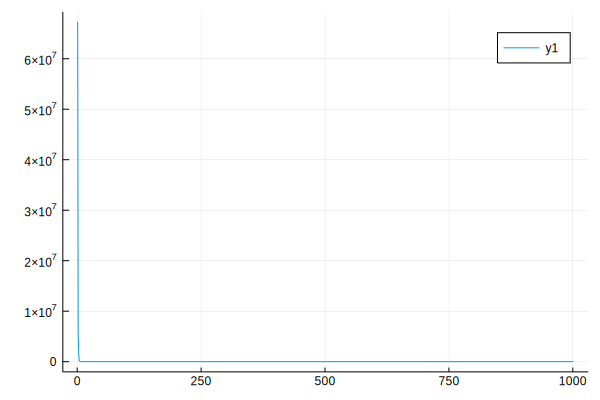

In [133]:
plot(fBTR)

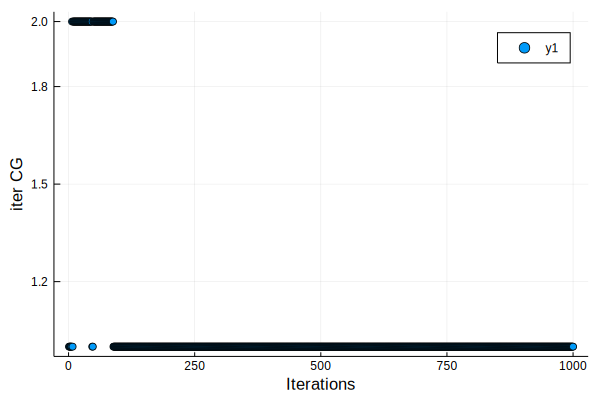

In [134]:
scatter(getData(accumulatorBtr).Field_iterCG, xlabel="Iterations", ylabel="iter CG")

In [135]:
verbose = false
iterMax = 2000

samplingStrategyIR = Geraldine.InexactRestoration{Geraldine.IndComRN}(Nobs(mo_RSG), 1.2)

Geraldine.InexactRestoration{Geraldine.IndComRN,Int64}(100, 100, 100, 100, 100000, Geraldine.NoVariance{Float64}(0.0, 0.0, 0.0, Float64[], Float64[], Float64[]), #undef, ConstantCoeffSubSampling(100, 0.1), Geraldine.var"#58#61"{Int64}(100000), 7.748604158327802e-304, 1.2, 1.707660277e-315, 0.0)

In [136]:
# BTR
accBtrIR =  Accumulator(ValueAccumulator(), DeltaAccumulator(), FieldAccumulator(:iterCG), ParamAccumulator(), SamplingSize())

"here's an Accumulator"

In [137]:
btr =  Geraldine.BTRStruct(;Nmax=iterMax, eps_g=eps, sam=typeof(samplingStrategyIR))

BTRStruct{Geraldine.TrueHessian{Float64},TruncatedConjugateGradient!{Geraldine.Norm2Constraint},Geraldine.InexactRestoration{Geraldine.IndComRN,Int64}}(TruncatedConjugateGradient!{Geraldine.Norm2Constraint}(Geraldine.stopCGBase, 10), Geraldine.StopParam{Geraldine.ONEVEC{Float64},Float64}([1.0], 1.0, 0.001, 1.0e-8, 1.0e-6, 2000, 3600.0, 1.0e12))

In [138]:
state, accumulatorBtrIR = btr(mo_RSG, copy(x0), samplingStrategyIR, accumulator = accBtrIR, verbose = verbose)

Nprevious = 100
Length shu = 100
N = 120
Length shu N = 120
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 0  and  max = 2000
Nprevious = 120
Length shu = 120
N = 144
Length shu N = 144
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 1  and  max = 2000
Nprevious = 144
Length shu = 144
N = 173
Length shu N = 173
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 2  and  max = 2000
Nprevious = 173
Length shu = 173
N = 208
Length shu N = 208
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 3  and  max = 2000
Nprevious = 208
Length shu = 208
N = 250
Length shu N = 250
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 4  and  max = 2000
Nprevious = 250
Length shu = 250
N = 300
Length shu N = 300
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 5  and  max = 2000
Nprevious = 300
Length shu = 300
N = 360
Length shu N = 360
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 6  and  max = 2000
Nprevious = 360
Length shu = 360
N = 432
Length shu N = 432
 -

Length shu = 500
N = 600
Length shu N = 600
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 64  and  max = 2000
Nprevious = 600
Length shu = 600
N = 720
Length shu N = 720
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 65  and  max = 2000
Nprevious = 720
Length shu = 720
N = 864
Length shu N = 864
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 66  and  max = 2000
Nprevious = 864
Length shu = 864
N = 1037
Length shu N = 1037
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 67  and  max = 2000
Nprevious = 1037
Length shu = 1037
N = 1245
Length shu N = 1245
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 68  and  max = 2000
N shu = 1245
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 69  and  max = 2000
Nprevious = 294
Length shu = 294
N = 353
Length shu N = 353
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 70  and  max = 2000
Nprevious = 353
Length shu = 353
N = 424
Length shu N = 424
 -- Optimality Inexact Restoration
Nmax reached ? 
k

Length shu = 1058
N = 1270
Length shu N = 1270
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 133  and  max = 2000
N shu = 1270
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 134  and  max = 2000
Nprevious = 324
Length shu = 324
N = 389
Length shu N = 389
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 135  and  max = 2000
Nprevious = 389
Length shu = 389
N = 467
Length shu N = 467
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 136  and  max = 2000
Nprevious = 467
Length shu = 467
N = 561
Length shu N = 561
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 137  and  max = 2000
Nprevious = 561
Length shu = 561
N = 674
Length shu N = 674
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 138  and  max = 2000
Nprevious = 674
Length shu = 674
N = 809
Length shu N = 809
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 139  and  max = 2000
Nprevious = 809
Length shu = 809
N = 971
Length shu N = 971
 -- Optimality Inexact Restoration
Nmax reached 

 -- Optimality Inexact Restoration
Nmax reached ? 
k = 199  and  max = 2000
Nprevious = 240
Length shu = 240
N = 288
Length shu N = 288
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 200  and  max = 2000
Nprevious = 288
Length shu = 288
N = 346
Length shu N = 346
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 201  and  max = 2000
Nprevious = 346
Length shu = 346
N = 416
Length shu N = 416
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 202  and  max = 2000
Nprevious = 416
Length shu = 416
N = 500
Length shu N = 500
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 203  and  max = 2000
Nprevious = 500
Length shu = 500
N = 600
Length shu N = 600
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 204  and  max = 2000
Nprevious = 600
Length shu = 600
N = 720
Length shu N = 720
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 205  and  max = 2000
Nprevious = 720
Length shu = 720
N = 864
Length shu N = 864
 -- Optimality Inexact Restoration
Nmax reached 

N = 1245
Length shu N = 1245
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 264  and  max = 2000
N shu = 1245
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 265  and  max = 2000
Nprevious = 294
Length shu = 294
N = 353
Length shu N = 353
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 266  and  max = 2000
Nprevious = 353
Length shu = 353
N = 424
Length shu N = 424
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 267  and  max = 2000
Nprevious = 424
Length shu = 424
N = 509
Length shu N = 509
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 268  and  max = 2000
Nprevious = 509
Length shu = 509
N = 611
Length shu N = 611
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 269  and  max = 2000
Nprevious = 611
Length shu = 611
N = 734
Length shu N = 734
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 270  and  max = 2000
Nprevious = 734
Length shu = 734
N = 881
Length shu N = 881
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 271  and  m

N = 1058
Length shu N = 1058
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 328  and  max = 2000
Nprevious = 1058
Length shu = 1058
N = 1270
Length shu N = 1270
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 329  and  max = 2000
N shu = 1270
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 330  and  max = 2000
Nprevious = 324
Length shu = 324
N = 389
Length shu N = 389
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 331  and  max = 2000
Nprevious = 389
Length shu = 389
N = 467
Length shu N = 467
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 332  and  max = 2000
Nprevious = 467
Length shu = 467
N = 561
Length shu N = 561
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 333  and  max = 2000
Nprevious = 561
Length shu = 561
N = 674
Length shu N = 674
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 334  and  max = 2000
Nprevious = 674
Length shu = 674
N = 809
Length shu N = 809
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 335  an

Length shu = 240
N = 288
Length shu N = 288
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 396  and  max = 2000
Nprevious = 288
Length shu = 288
N = 346
Length shu N = 346
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 397  and  max = 2000
Nprevious = 346
Length shu = 346
N = 416
Length shu N = 416
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 398  and  max = 2000
Nprevious = 416
Length shu = 416
N = 500
Length shu N = 500
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 399  and  max = 2000
Nprevious = 500
Length shu = 500
N = 600
Length shu N = 600
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 400  and  max = 2000
Nprevious = 600
Length shu = 600
N = 720
Length shu N = 720
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 401  and  max = 2000
Nprevious = 720
Length shu = 720
N = 864
Length shu N = 864
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 402  and  max = 2000
Nprevious = 864
Length shu = 864
N = 1037
Length shu N = 1037
 -

Length shu = 864
N = 1037
Length shu N = 1037
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 459  and  max = 2000
Nprevious = 1037
Length shu = 1037
N = 1245
Length shu N = 1245
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 460  and  max = 2000
N shu = 1245
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 461  and  max = 2000
Nprevious = 294
Length shu = 294
N = 353
Length shu N = 353
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 462  and  max = 2000
Nprevious = 353
Length shu = 353
N = 424
Length shu N = 424
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 463  and  max = 2000
Nprevious = 424
Length shu = 424
N = 509
Length shu N = 509
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 464  and  max = 2000
Nprevious = 509
Length shu = 509
N = 611
Length shu N = 611
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 465  and  max = 2000
Nprevious = 611
Length shu = 611
N = 734
Length shu N = 734
 -- Optimality Inexact Restoration
Nmax reach

Length shu = 611
N = 734
Length shu N = 734
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 522  and  max = 2000
Nprevious = 734
Length shu = 734
N = 881
Length shu N = 881
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 523  and  max = 2000
Nprevious = 881
Length shu = 881
N = 1058
Length shu N = 1058
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 524  and  max = 2000
Nprevious = 1058
Length shu = 1058
N = 1270
Length shu N = 1270
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 525  and  max = 2000
N shu = 1270
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 526  and  max = 2000
Nprevious = 324
Length shu = 324
N = 389
Length shu N = 389
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 527  and  max = 2000
Nprevious = 389
Length shu = 389
N = 467
Length shu N = 467
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 528  and  max = 2000
Nprevious = 467
Length shu = 467
N = 561
Length shu N = 561
 -- Optimality Inexact Restoration
Nmax reach

N = 1166
Length shu N = 1166
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 589  and  max = 2000
N shu = 1166
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 590  and  max = 2000
Nprevious = 200
Length shu = 200
N = 240
Length shu N = 240
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 591  and  max = 2000
Nprevious = 240
Length shu = 240
N = 288
Length shu N = 288
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 592  and  max = 2000
Nprevious = 288
Length shu = 288
N = 346
Length shu N = 346
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 593  and  max = 2000
Nprevious = 346
Length shu = 346
N = 416
Length shu N = 416
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 594  and  max = 2000
Nprevious = 416
Length shu = 416
N = 500
Length shu N = 500
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 595  and  max = 2000
Nprevious = 500
Length shu = 500
N = 600
Length shu N = 600
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 596  and  m

Nprevious = 600
Length shu = 600
N = 720
Length shu N = 720
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 653  and  max = 2000
Nprevious = 720
Length shu = 720
N = 864
Length shu N = 864
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 654  and  max = 2000
Nprevious = 864
Length shu = 864
N = 1037
Length shu N = 1037
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 655  and  max = 2000
Nprevious = 1037
Length shu = 1037
N = 1245
Length shu N = 1245
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 656  and  max = 2000
N shu = 1245
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 657  and  max = 2000
Nprevious = 294
Length shu = 294
N = 353
Length shu N = 353
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 658  and  max = 2000
Nprevious = 353
Length shu = 353
N = 424
Length shu N = 424
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 659  and  max = 2000
Nprevious = 424
Length shu = 424
N = 509
Length shu N = 509
 -- Optimality Inexact Restor

N = 881
Length shu N = 881
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 719  and  max = 2000
Nprevious = 881
Length shu = 881
N = 1058
Length shu N = 1058
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 720  and  max = 2000
Nprevious = 1058
Length shu = 1058
N = 1270
Length shu N = 1270
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 721  and  max = 2000
N shu = 1270
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 722  and  max = 2000
Nprevious = 324
Length shu = 324
N = 389
Length shu N = 389
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 723  and  max = 2000
Nprevious = 389
Length shu = 389
N = 467
Length shu N = 467
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 724  and  max = 2000
Nprevious = 467
Length shu = 467
N = 561
Length shu N = 561
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 725  and  max = 2000
Nprevious = 561
Length shu = 561
N = 674
Length shu N = 674
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 726  an

N = 971
Length shu N = 971
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 784  and  max = 2000
Nprevious = 971
Length shu = 971
N = 1166
Length shu N = 1166
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 785  and  max = 2000
N shu = 1166
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 786  and  max = 2000
Nprevious = 200
Length shu = 200
N = 240
Length shu N = 240
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 787  and  max = 2000
Nprevious = 240
Length shu = 240
N = 288
Length shu N = 288
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 788  and  max = 2000
Nprevious = 288
Length shu = 288
N = 346
Length shu N = 346
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 789  and  max = 2000
Nprevious = 346
Length shu = 346
N = 416
Length shu N = 416
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 790  and  max = 2000
Nprevious = 416
Length shu = 416
N = 500
Length shu N = 500
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 791  and  m

N = 500
Length shu N = 500
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 847  and  max = 2000
Nprevious = 500
Length shu = 500
N = 600
Length shu N = 600
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 848  and  max = 2000
Nprevious = 600
Length shu = 600
N = 720
Length shu N = 720
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 849  and  max = 2000
Nprevious = 720
Length shu = 720
N = 864
Length shu N = 864
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 850  and  max = 2000
Nprevious = 864
Length shu = 864
N = 1037
Length shu N = 1037
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 851  and  max = 2000
Nprevious = 1037
Length shu = 1037
N = 1245
Length shu N = 1245
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 852  and  max = 2000
N shu = 1245
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 853  and  max = 2000
Nprevious = 294
Length shu = 294
N = 353
Length shu N = 353
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 854  an

N = 353
Length shu N = 353
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 910  and  max = 2000
Nprevious = 353
Length shu = 353
N = 424
Length shu N = 424
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 911  and  max = 2000
Nprevious = 424
Length shu = 424
N = 509
Length shu N = 509
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 912  and  max = 2000
Nprevious = 509
Length shu = 509
N = 611
Length shu N = 611
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 913  and  max = 2000
Nprevious = 611
Length shu = 611
N = 734
Length shu N = 734
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 914  and  max = 2000
Nprevious = 734
Length shu = 734
N = 881
Length shu N = 881
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 915  and  max = 2000
Nprevious = 881
Length shu = 881
N = 1058
Length shu N = 1058
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 916  and  max = 2000
Nprevious = 1058
Length shu = 1058
N = 1270
Length shu N = 1270
 -- Optimality 

N = 467
Length shu N = 467
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 976  and  max = 2000
Nprevious = 467
Length shu = 467
N = 561
Length shu N = 561
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 977  and  max = 2000
Nprevious = 561
Length shu = 561
N = 674
Length shu N = 674
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 978  and  max = 2000
Nprevious = 674
Length shu = 674
N = 809
Length shu N = 809
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 979  and  max = 2000
Nprevious = 809
Length shu = 809
N = 971
Length shu N = 971
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 980  and  max = 2000
Nprevious = 971
Length shu = 971
N = 1166
Length shu N = 1166
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 981  and  max = 2000
N shu = 1166
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 982  and  max = 2000
Nprevious = 200
Length shu = 200
N = 240
Length shu N = 240
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 983  and  m

Nprevious = 864
Length shu = 864
N = 1037
Length shu N = 1037
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 1047  and  max = 2000
Nprevious = 1037
Length shu = 1037
N = 1245
Length shu N = 1245
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 1048  and  max = 2000
N shu = 1245
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 1049  and  max = 2000
Nprevious = 294
Length shu = 294
N = 353
Length shu N = 353
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 1050  and  max = 2000
Nprevious = 353
Length shu = 353
N = 424
Length shu N = 424
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 1051  and  max = 2000
Nprevious = 424
Length shu = 424
N = 509
Length shu N = 509
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 1052  and  max = 2000
Nprevious = 509
Length shu = 509
N = 611
Length shu N = 611
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 1053  and  max = 2000
Nprevious = 611
Length shu = 611
N = 734
Length shu N = 734
 -- Optimality Inexact

Length shu = 611
N = 734
Length shu N = 734
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 1110  and  max = 2000
Nprevious = 734
Length shu = 734
N = 881
Length shu N = 881
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 1111  and  max = 2000
Nprevious = 881
Length shu = 881
N = 1058
Length shu N = 1058
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 1112  and  max = 2000
Nprevious = 1058
Length shu = 1058
N = 1270
Length shu N = 1270
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 1113  and  max = 2000
N shu = 1270
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 1114  and  max = 2000
Nprevious = 324
Length shu = 324
N = 389
Length shu N = 389
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 1115  and  max = 2000
Nprevious = 389
Length shu = 389
N = 467
Length shu N = 467
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 1116  and  max = 2000
Nprevious = 467
Length shu = 467
N = 561
Length shu N = 561
 -- Optimality Inexact Restoration
Nma

Length shu = 467
N = 561
Length shu N = 561
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 1173  and  max = 2000
Nprevious = 561
Length shu = 561
N = 674
Length shu N = 674
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 1174  and  max = 2000
Nprevious = 674
Length shu = 674
N = 809
Length shu N = 809
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 1175  and  max = 2000
Nprevious = 809
Length shu = 809
N = 971
Length shu N = 971
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 1176  and  max = 2000
Nprevious = 971
Length shu = 971
N = 1166
Length shu N = 1166
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 1177  and  max = 2000
N shu = 1166
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 1178  and  max = 2000
Nprevious = 200
Length shu = 200
N = 240
Length shu N = 240
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 1179  and  max = 2000
Nprevious = 240
Length shu = 240
N = 288
Length shu N = 288
 -- Optimality Inexact Restoration
Nmax re

N = 416
Length shu N = 416
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 1238  and  max = 2000
Nprevious = 416
Length shu = 416
N = 500
Length shu N = 500
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 1239  and  max = 2000
Nprevious = 500
Length shu = 500
N = 600
Length shu N = 600
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 1240  and  max = 2000
Nprevious = 600
Length shu = 600
N = 720
Length shu N = 720
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 1241  and  max = 2000
Nprevious = 720
Length shu = 720
N = 864
Length shu N = 864
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 1242  and  max = 2000
Nprevious = 864
Length shu = 864
N = 1037
Length shu N = 1037
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 1243  and  max = 2000
Nprevious = 1037
Length shu = 1037
N = 1245
Length shu N = 1245
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 1244  and  max = 2000
N shu = 1245
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 

N = 353
Length shu N = 353
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 1302  and  max = 2000
Nprevious = 353
Length shu = 353
N = 424
Length shu N = 424
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 1303  and  max = 2000
Nprevious = 424
Length shu = 424
N = 509
Length shu N = 509
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 1304  and  max = 2000
Nprevious = 509
Length shu = 509
N = 611
Length shu N = 611
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 1305  and  max = 2000
Nprevious = 611
Length shu = 611
N = 734
Length shu N = 734
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 1306  and  max = 2000
Nprevious = 734
Length shu = 734
N = 881
Length shu N = 881
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 1307  and  max = 2000
Nprevious = 881
Length shu = 881
N = 1058
Length shu N = 1058
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 1308  and  max = 2000
Nprevious = 1058
Length shu = 1058
N = 1270
Length shu N = 1270
 -- Opti

Length shu = 674
N = 809
Length shu N = 809
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 1371  and  max = 2000
Nprevious = 809
Length shu = 809
N = 971
Length shu N = 971
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 1372  and  max = 2000
Nprevious = 971
Length shu = 971
N = 1166
Length shu N = 1166
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 1373  and  max = 2000
N shu = 1166
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 1374  and  max = 2000
Nprevious = 200
Length shu = 200
N = 240
Length shu N = 240
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 1375  and  max = 2000
Nprevious = 240
Length shu = 240
N = 288
Length shu N = 288
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 1376  and  max = 2000
Nprevious = 288
Length shu = 288
N = 346
Length shu N = 346
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 1377  and  max = 2000
Nprevious = 346
Length shu = 346
N = 416
Length shu N = 416
 -- Optimality Inexact Restoration
Nmax re

Length shu = 600
N = 720
Length shu N = 720
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 1437  and  max = 2000
Nprevious = 720
Length shu = 720
N = 864
Length shu N = 864
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 1438  and  max = 2000
Nprevious = 864
Length shu = 864
N = 1037
Length shu N = 1037
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 1439  and  max = 2000
Nprevious = 1037
Length shu = 1037
N = 1245
Length shu N = 1245
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 1440  and  max = 2000
N shu = 1245
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 1441  and  max = 2000
Nprevious = 294
Length shu = 294
N = 353
Length shu N = 353
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 1442  and  max = 2000
Nprevious = 353
Length shu = 353
N = 424
Length shu N = 424
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 1443  and  max = 2000
Nprevious = 424
Length shu = 424
N = 509
Length shu N = 509
 -- Optimality Inexact Restoration
Nma

Length shu = 509
N = 611
Length shu N = 611
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 1501  and  max = 2000
Nprevious = 611
Length shu = 611
N = 734
Length shu N = 734
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 1502  and  max = 2000
Nprevious = 734
Length shu = 734
N = 881
Length shu N = 881
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 1503  and  max = 2000
Nprevious = 881
Length shu = 881
N = 1058
Length shu N = 1058
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 1504  and  max = 2000
Nprevious = 1058
Length shu = 1058
N = 1270
Length shu N = 1270
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 1505  and  max = 2000
N shu = 1270
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 1506  and  max = 2000
Nprevious = 324
Length shu = 324
N = 389
Length shu N = 389
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 1507  and  max = 2000
Nprevious = 389
Length shu = 389
N = 467
Length shu N = 467
 -- Optimality Inexact Restoration
Nma

N = 809
Length shu N = 809
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 1567  and  max = 2000
Nprevious = 809
Length shu = 809
N = 971
Length shu N = 971
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 1568  and  max = 2000
Nprevious = 971
Length shu = 971
N = 1166
Length shu N = 1166
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 1569  and  max = 2000
N shu = 1166
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 1570  and  max = 2000
Nprevious = 200
Length shu = 200
N = 240
Length shu N = 240
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 1571  and  max = 2000
Nprevious = 240
Length shu = 240
N = 288
Length shu N = 288
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 1572  and  max = 2000
Nprevious = 288
Length shu = 288
N = 346
Length shu N = 346
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 1573  and  max = 2000
Nprevious = 346
Length shu = 346
N = 416
Length shu N = 416
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 1574

Length shu = 600
N = 720
Length shu N = 720
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 1633  and  max = 2000
Nprevious = 720
Length shu = 720
N = 864
Length shu N = 864
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 1634  and  max = 2000
Nprevious = 864
Length shu = 864
N = 1037
Length shu N = 1037
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 1635  and  max = 2000
Nprevious = 1037
Length shu = 1037
N = 1245
Length shu N = 1245
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 1636  and  max = 2000
N shu = 1245
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 1637  and  max = 2000
Nprevious = 294
Length shu = 294
N = 353
Length shu N = 353
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 1638  and  max = 2000
Nprevious = 353
Length shu = 353
N = 424
Length shu N = 424
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 1639  and  max = 2000
Nprevious = 424
Length shu = 424
N = 509
Length shu N = 509
 -- Optimality Inexact Restoration
Nma

Nprevious = 734
Length shu = 734
N = 881
Length shu N = 881
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 1699  and  max = 2000
Nprevious = 881
Length shu = 881
N = 1058
Length shu N = 1058
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 1700  and  max = 2000
Nprevious = 1058
Length shu = 1058
N = 1270
Length shu N = 1270
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 1701  and  max = 2000
N shu = 1270
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 1702  and  max = 2000
Nprevious = 324
Length shu = 324
N = 389
Length shu N = 389
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 1703  and  max = 2000
Nprevious = 389
Length shu = 389
N = 467
Length shu N = 467
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 1704  and  max = 2000
Nprevious = 467
Length shu = 467
N = 561
Length shu N = 561
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 1705  and  max = 2000
Nprevious = 561
Length shu = 561
N = 674
Length shu N = 674
 -- Optimality Inexact

N = 674
Length shu N = 674
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 1762  and  max = 2000
Nprevious = 674
Length shu = 674
N = 809
Length shu N = 809
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 1763  and  max = 2000
Nprevious = 809
Length shu = 809
N = 971
Length shu N = 971
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 1764  and  max = 2000
Nprevious = 971
Length shu = 971
N = 1166
Length shu N = 1166
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 1765  and  max = 2000
N shu = 1166
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 1766  and  max = 2000
Nprevious = 200
Length shu = 200
N = 240
Length shu N = 240
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 1767  and  max = 2000
Nprevious = 240
Length shu = 240
N = 288
Length shu N = 288
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 1768  and  max = 2000
Nprevious = 288
Length shu = 288
N = 346
Length shu N = 346
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 1769

N = 346
Length shu N = 346
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 1825  and  max = 2000
Nprevious = 346
Length shu = 346
N = 416
Length shu N = 416
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 1826  and  max = 2000
Nprevious = 416
Length shu = 416
N = 500
Length shu N = 500
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 1827  and  max = 2000
Nprevious = 500
Length shu = 500
N = 600
Length shu N = 600
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 1828  and  max = 2000
Nprevious = 600
Length shu = 600
N = 720
Length shu N = 720
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 1829  and  max = 2000
Nprevious = 720
Length shu = 720
N = 864
Length shu N = 864
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 1830  and  max = 2000
Nprevious = 864
Length shu = 864
N = 1037
Length shu N = 1037
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 1831  and  max = 2000
Nprevious = 1037
Length shu = 1037
N = 1245
Length shu N = 1245
 -- Opti

k = 1887  and  max = 2000
Nprevious = 1037
Length shu = 1037
N = 1245
Length shu N = 1245
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 1888  and  max = 2000
N shu = 1245
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 1889  and  max = 2000
Nprevious = 294
Length shu = 294
N = 353
Length shu N = 353
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 1890  and  max = 2000
Nprevious = 353
Length shu = 353
N = 424
Length shu N = 424
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 1891  and  max = 2000
Nprevious = 424
Length shu = 424
N = 509
Length shu N = 509
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 1892  and  max = 2000
Nprevious = 509
Length shu = 509
N = 611
Length shu N = 611
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 1893  and  max = 2000
Nprevious = 611
Length shu = 611
N = 734
Length shu N = 734
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 1894  and  max = 2000
Nprevious = 734
Length shu = 734
N = 881
Length shu N = 88

Length shu = 467
N = 561
Length shu N = 561
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 1957  and  max = 2000
Nprevious = 561
Length shu = 561
N = 674
Length shu N = 674
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 1958  and  max = 2000
Nprevious = 674
Length shu = 674
N = 809
Length shu N = 809
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 1959  and  max = 2000
Nprevious = 809
Length shu = 809
N = 971
Length shu N = 971
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 1960  and  max = 2000
Nprevious = 971
Length shu = 971
N = 1166
Length shu N = 1166
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 1961  and  max = 2000
N shu = 1166
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 1962  and  max = 2000
Nprevious = 200
Length shu = 200
N = 240
Length shu N = 240
 -- Optimality Inexact Restoration
Nmax reached ? 
k = 1963  and  max = 2000
Nprevious = 240
Length shu = 240
N = 288
Length shu N = 288
 -- Optimality Inexact Restoration
Nmax re

"here's a state""here's an Accumulator"

In [139]:
# Collecting results
resultIR = Geraldine.structToDict(accumulatorBtrIR)

samplingIR = resultIR[:SamplingSizeAccumulator]
fIR = resultIR[:ValueAccumulator]
paramIR = resultIR[:ParamAccumulator]

2001-element Array{Array{T,1} where T,1}:
 [20.382634066249317, 18.6165162875591]
 [16.695654354440517, 18.649139498029296]
 [13.034726411792025, 18.690330203369548]
 [10.27148704150358, 18.730685220933935]
 [1.6113376200757479, 18.890051116648184]
 [7.389243402124146, 17.272706139912646]
 [5.675757681790444, 17.315866345713577]
 [4.584290183136307, 17.347401318895347]
 [3.688784439437671, 17.371547211522007]
 [3.135397574030292, 17.371502649409162]
 [2.2475266070034934, 11.379005874912261]
 [1.7500968213695118, 4.825905216180145]
 [1.277333656390224, 1.267773457691249]
 ⋮
 [0.15083735411642668, 0.02789853627955656]
 [0.15340948003562865, 0.028804926815138198]
 [0.15432382407250356, 0.02881864194476813]
 [0.1525476379065294, 0.027827257049739717]
 [0.156080610123725, 0.02848337908823123]
 [0.15394511788395643, 0.027878976454906113]
 [0.15195361028556714, 0.02744725871984313]
 [0.15216434263062445, 0.027029478117195468]
 [0.15283610440194773, 0.028149095837194868]
 [0.15328683366228746,

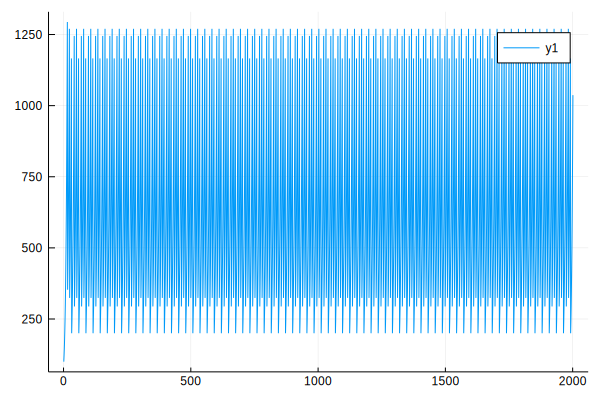

In [140]:
gr()
plot(samplingIR[1])

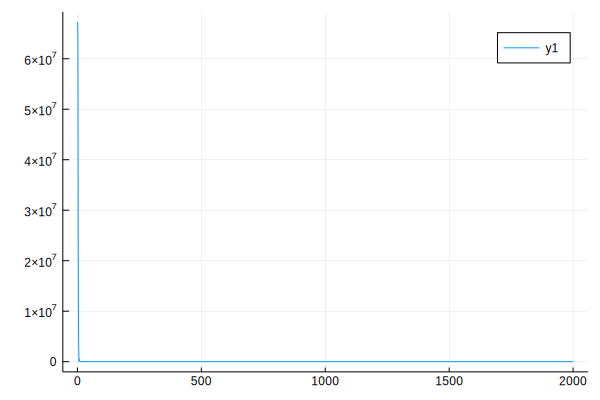

In [141]:
plot(fIR)

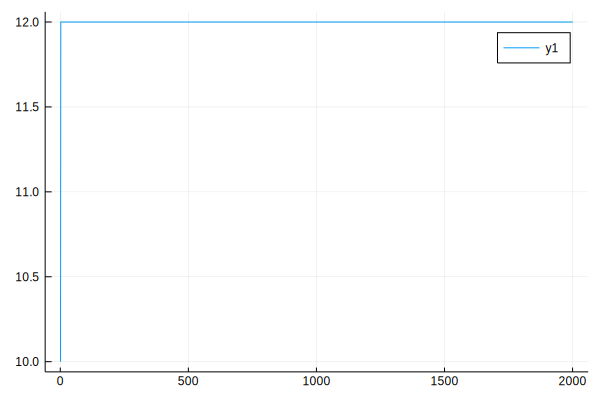

In [142]:
plot(resultIR[:DeltaAccumulator])

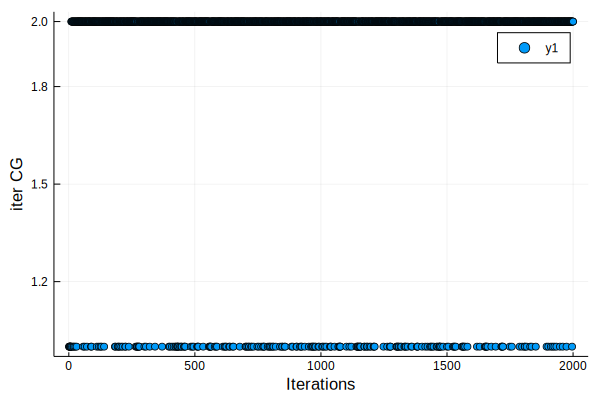

In [143]:
scatter(getData(accumulatorBtrIR).Field_iterCG, xlabel="Iterations", ylabel="iter CG")

In [144]:
println("For BTR --- ")
show(stdout, "text/plain", paramBTR[end])
println("\n")
println("For Inexact restoration --- ")
show(stdout, "text/plain", paramIR[end])

For BTR --- 
2-element Array{Float64,1}:
 0.15360410897143617
 0.02952489043479547

For Inexact restoration --- 
2-element Array{Float64,1}:
 0.1549911745387963
 0.030047738412394408

In [145]:
paramBTR[end] - paramIR[end]

2-element Array{Float64,1}:
 -0.001387065567360124
 -0.0005228479775989392

# Playing with contour Plots

In [ ]:
# p = scatter(getindex.(paramBTR, 1), getindex.(paramBTR, 2))

x = range(-2,stop=25,length=100)
y = range(-2,stop=25,length=100)

z = [Sofia.F([xi, yi], mo_RSG) for xi in x, yi in y]

In [ ]:
min(z...)

In [ ]:
p = contour(x,y,z', levels=100)

In [ ]:
scatter!(p, getindex.(paramBTR, 1), getindex.(paramBTR, 2))
# scatter!(p, getindex.(paramAdam, 1), getindex.(paramAdam, 2))
# scatter!(p, getindex.(paramSGD, 1), getindex.(paramSGD, 2))